# 기본 세팅

In [ ]:
#! pip install gcsfs

In [ ]:
#! pip install koreanize_matplotlib

In [ ]:
#!pip install seaborn

In [40]:
#!pip install scikit-learn

In [5]:
#!pip install plotly

In [1]:

# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import os

# GCS 파일 경로에서 데이터 불러오기 위한 라이브러리
from google.cloud import storage
from google.oauth2 import service_account


# 클러스터링
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
# 가설 검정
from scipy.stats import chi2_contingency

In [3]:
# Pandas 보기 옵션
# pd.set_option('display.max_columns',100)
# pd.set_option('display.max_rows',100)

In [2]:

# 기본 정보 확인 함수 
def show_df_info(df, df_name):
    """
    DataFrame의 기본 정보와 통계 요약을 출력하는 함수
    """
    print(f"\n{df_name} 형태:")
    display(df.shape)
    print(f"\n{df_name} 첫 5행:")
    display(df.head())
    print(f"\n{df_name} 정보:")
    df.info()
    print(f"\n{df_name} 통계 요약:")
    display(df.describe())
    print(f"\n{df_name} 통계 요약:")
    display(df.describe(include = 'O'))
    print(f"\n{df_name} 결측치 확인:")
    display(df.isnull().sum())
    # print(f"\n{df_name} 중복값 확인:")
    # print(df.iloc[:,1:].duplicated().sum())

# 데이터 불러오기 및 확인

In [14]:
# 인증
key_path = "../config/codeit_project_vm_key.json"
credentials = service_account.Credentials.from_service_account_file(key_path)

# GCS 클라이언트 생성
client = storage.Client(credentials=credentials)
bucket = client.bucket("part4_project")

# 'hackle/' 경로에 있는 .parquet 파일 리스트 가져오기
blobs = bucket.list_blobs(prefix="hackle/")
hackle_file_list = [f"gs://part4_project/{blob.name}" for blob in blobs if blob.name.endswith(".parquet")]

# 결과 확인
hackle_file_list

['gs://part4_project/hackle/device_properties.parquet',
 'gs://part4_project/hackle/final.parquet',
 'gs://part4_project/hackle/final_hackle.parquet',
 'gs://part4_project/hackle/hackle_events.parquet',
 'gs://part4_project/hackle/hackle_properties.parquet',
 'gs://part4_project/hackle/user_properties.parquet']

In [15]:
# 파일들을 각각 변수로 불러오기
# 'final'이 파일명에 포함되지 않은 파일만 필터링
non_final_files = [title for title in hackle_file_list if 'final' not in title]

for title in non_final_files:
    # GCS 경로에서 파일명 추출
    file_name = title.split('/')[-1].replace('.parquet', '')
    
    # Parquet 파일 읽기
    df = pd.read_parquet(title, storage_options={"token": key_path})
    
    # 각각의 이름_df로 저장 (ex. device_properties_df)
    globals()[f"{file_name}_df"] = df
    
    # 선택적으로 출력 확인
    print(f"{file_name}_df 불러오기 완료, shape: {df.shape}")


device_properties_df 불러오기 완료, shape: (252380, 4)
hackle_events_df 불러오기 완료, shape: (11441319, 11)
hackle_properties_df 불러오기 완료, shape: (525350, 8)
user_properties_df 불러오기 완료, shape: (230819, 5)


# EDA

## 1. hackle_properties

|테이블명|	컬럼명	|컬럼 설명|
|-------|----------|--------|
|hackle_properties|	session_id|	세션 식별자|
|		|user_id|	사용자 ID|
|		|language|	사용 언어|
|		|osname|	운영 체제 이름|
|		|osversion|	운영 체제 버전|
|		|versionname|	앱 버전 이름|
|		|device_id|	장치 ID|

In [27]:
show_df_info(hackle_properties_df, 'hackle_properties_df')


hackle_properties_df 형태:


(525350, 8)


hackle_properties_df 첫 5행:


,id,session_id,user_id,language,osname,osversion,versionname,device_id
0,1,4OzYh3seq3VKytpSn5pvQkZNQii1,,ko-KR,iOS,16.0,2.0.0,590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74
1,2,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,1046711,ko-KR,iOS,16.5.1,2.0.3,D5417226-F71B-4A9E-A180-CD072F2AB279
2,3,6bcea65d-9f40-46fc-888c-700fe707483f,1545130,ko,Android,13,2.0.5,6bcea65d-9f40-46fc-888c-700fe707483f
3,4,XVYNT6zfhFWqIg9omwg2AHDjTLx2,1224793,ko,Android,13,2.0.5,a05c1595-3e05-434b-8684-218b528bd725
4,5,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,1329450,ko-US,iOS,16.5.1,2.0.5,EAC6C0B3-7CE8-40EA-8A91-9977C0BA5EF3



hackle_properties_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525350 entries, 0 to 525349
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           525350 non-null  int64 
 1   session_id   525350 non-null  object
 2   user_id      525350 non-null  object
 3   language     525350 non-null  object
 4   osname       525350 non-null  object
 5   osversion    525350 non-null  object
 6   versionname  525350 non-null  object
 7   device_id    525350 non-null  object
dtypes: int64(1), object(7)
memory usage: 32.1+ MB

hackle_properties_df 통계 요약:


,id
count,525350.000000
mean,262675.500000
std,151655.626297
min,1.000000
25%,131338.250000
50%,262675.500000
75%,394012.750000
max,525350.000000



hackle_properties_df 통계 요약:


,session_id,user_id,language,osname,osversion,versionname,device_id
count,525350,525350,525350,525350,525350,525350,525350
unique,253616,327381,151,2,74,16,251720
top,040914e1-61ac-40ef-b76a-718066d880dc,,ko-KR,iOS,16.5.1,2.0.5,040914e1-61ac-40ef-b76a-718066d880dc
freq,9,82255,340900,359479,218699,309644,9



hackle_properties_df 결측치 확인:


id             0
session_id     0
user_id        0
language       0
osname         0
osversion      0
versionname    0
device_id      0
dtype: int64

In [ ]:
# id 컬럼 제외하고 중복 확인 - 없음
hackle_properties_df.iloc[:,1:].duplicated().sum()

0

In [28]:
# user_id 가 공백??
hackle_properties_df[hackle_properties_df['user_id'] == ''].shape

(82255, 8)

- user_id가 공백으로 입력되어 있는 경우 82255 개 
- 해당 경우 'unknown' 으로 변경

In [29]:
# user_id에 공백만 입력된 경우 'unknown'으로 변경
hackle_properties_df['user_id'] = hackle_properties_df['user_id'].apply(lambda x: 'unknown' if isinstance(x, str) and x.strip() == '' else x)
hackle_properties_df['user_id'].value_counts()

user_id
unknown    82255
1578652       17
1459833       13
1571506       13
1239584       12
           ...  
1085617        1
1499469        1
1075954        1
1021052        1
1043127        1
Name: count, Length: 327381, dtype: int64

- 공백만 unknown으로 변경된 것 확인! (개수 동일하게 82255개)

In [41]:
# session_id마다 user_id는 몇 개? (hackle_events에서 session_id를 user_id와 동일 취급 가능한가?)
session_user_cnt_df = hackle_properties_df.groupby('session_id')['user_id'].nunique().reset_index(name = 'user_id_count').sort_values(by ='user_id_count', ascending = False)
session_user_cnt_df

,session_id,user_id_count
1129,040914e1-61ac-40ef-b76a-718066d880dc,6
3209,0CC53548-EB9A-4AE5-A72E-5D765B3BB1F9,4
75081,B941F9F9-CF53-4DAE-A204-75E666B5D277,4
14354,23235867-49A8-4240-8B34-6342357440F9,4
56337,87046FBA-B84B-4124-ADE9-EA03DF95E7B8,4
...,...,...
56361,871DDDB5-20CC-4076-8CEC-A5087B69C72A,1
161330,ZRKVAinfU8NVuLTBKnlrsT7P9453,1
161329,ZRJnnLID7XUiXzlNnQEXywhpNWl2,1
56362,871E5518-6794-43AD-923F-2465934E709F,1


In [45]:
print(session_user_cnt_df['user_id_count'].value_counts())
print(session_user_cnt_df['user_id_count'].value_counts(normalize = True))

user_id_count
2    148802
1    101802
3      3007
4         4
6         1
Name: count, dtype: int64
user_id_count
2    0.586722
1    0.401402
3    0.011857
4    0.000016
6    0.000004
Name: proportion, dtype: float64


In [40]:
# user_id마다 session_id는 몇 개? (hackle_events에서 session_id를 user_id와 동일 취급 가능한가?)
user_session_cnt_df = hackle_properties_df.groupby('user_id')['session_id'].nunique().reset_index(name='session_id_count').sort_values(by='session_id_count', ascending=False)
user_session_cnt_df

,user_id,session_id_count
319303,unknown,78197
158764,1459833,13
195272,1578652,13
192533,1571506,13
210229,855879,12
...,...,...
109620,1302497,1
109619,1302488,1
109618,1302487,1
109617,1302485,1


- user_id 형태가 다른 숫자형(으로 보이지만 object)과는 다르게 zzzYYwN42NdbhcyXHgyeAxyNH7J2 와 같은게 있음...!

In [44]:
print(user_session_cnt_df['session_id_count'].value_counts())
print(user_session_cnt_df['session_id_count'].value_counts(normalize = True))

session_id_count
1        325065
2          2062
3           146
4            44
5            19
6            15
7             8
8             7
9             5
13            3
12            3
11            2
78197         1
10            1
Name: count, dtype: int64
session_id_count
1        0.992926
2        0.006298
3        0.000446
4        0.000134
5        0.000058
6        0.000046
7        0.000024
8        0.000021
9        0.000015
13       0.000009
12       0.000009
11       0.000006
78197    0.000003
10       0.000003
Name: proportion, dtype: float64


In [118]:
# 샘플 아무거나 확인 
hackle_properties_df[hackle_properties_df['user_id'].apply(len) > 7]['user_id'].nunique()

96527

- user_id가 눈으로 보기에도 찐 문자열인 것들이 있음 
- session_id와 user_id가 같은 경우도 있음

In [ ]:
96527 / 327381 * 100 # 약 30%가 허수 ? 

29.484606620420855

In [32]:
# 한 user_id에 session_id 갯수 13개인 것 샘플 확인 
hackle_properties_df[hackle_properties_df['user_id'] == '1459833']

,id,session_id,user_id,language,osname,osversion,versionname,device_id
2255,2256,E7291C7D-54D9-459B-B93D-EB3DB0B5EB54,1459833,ko-KR,iOS,16.3.1,2.0.5,E7291C7D-54D9-459B-B93D-EB3DB0B5EB54
24115,24116,EF35B630-C9C9-4CEF-B70A-C5EB2703C17F,1459833,ko-KR,iOS,16.3.1,2.0.5,EF35B630-C9C9-4CEF-B70A-C5EB2703C17F
30217,30218,3CF3AF75-ECF6-4A07-A4F3-66EE0D114428,1459833,ko-KR,iOS,16.3.1,2.0.5,3CF3AF75-ECF6-4A07-A4F3-66EE0D114428
61146,61147,91AC528E-4CE9-4E3E-9283-98DD3F0E40C1,1459833,ko-KR,iOS,16.3.1,2.0.5,91AC528E-4CE9-4E3E-9283-98DD3F0E40C1
64455,64456,4BC78F41-A9F2-400E-AEC6-1C9449163BC2,1459833,ko-KR,iOS,16.3.1,2.0.3,4BC78F41-A9F2-400E-AEC6-1C9449163BC2
106580,106581,09BE6E5A-527E-4B50-AD7F-AC1680BD569D,1459833,ko-KR,iOS,16.3.1,2.0.5,09BE6E5A-527E-4B50-AD7F-AC1680BD569D
109773,109774,44A0482C-3668-432A-A367-6545D06EE753,1459833,ko-KR,iOS,16.3.1,2.0.5,44A0482C-3668-432A-A367-6545D06EE753
129211,129212,9C58E582-94AB-40E4-A77F-6044F43322E1,1459833,ko-KR,iOS,16.3.1,2.0.5,9C58E582-94AB-40E4-A77F-6044F43322E1
160205,160206,09D832EA-FAEF-460D-9612-62B8795EC54F,1459833,ko-KR,iOS,16.3.1,2.0.5,09D832EA-FAEF-460D-9612-62B8795EC54F
162316,162317,7033EC1F-1684-4887-8204-092EBEC2253A,1459833,ko-KR,iOS,16.3.1,2.0.3,7033EC1F-1684-4887-8204-092EBEC2253A


- 뭐지...? 아까 화면 공유로 봤을 때 user_id에 session_id도 다 1개씩 이었던 거 같은데?
- 그렇다면 hackle_events 테이블에서 session_id를 user_id로 봐도 되는게 맞나..?

In [1]:
## 여기서 처리하고 hackle_evnets와 merge???
'''
python
# user_id가 ''인 경우는 결측치로 처리
df['user_id'] = df['user_id'].replace('', pd.NA)

# 동일한 session_id + device_id 조합으로 user_id가 있는 값 추출
lookup = (
    df[df['user_id'].notna()]
    .groupby(['session_id', 'device_id'])['user_id']
    .first()
    .reset_index()
)

# 원래 df에 join해서 빈 user_id 채우기
df = df.merge(lookup, on=['session_id', 'device_id'], how='left', suffixes=('', '_fill'))

# user_id가 비어있던 경우에만 fill된 값으로 대체
df['user_id'] = df['user_id'].combine_first(df['user_id_fill'])

# 보조 컬럼 삭제
df.drop(columns=['user_id_fill'], inplace=True)
print(df.isnull().sum())
'''

"\npython\n# user_id가 ''인 경우는 결측치로 처리\ndf['user_id'] = df['user_id'].replace('', pd.NA)\n\n# 동일한 session_id + device_id 조합으로 user_id가 있는 값 추출\nlookup = (\n    df[df['user_id'].notna()]\n    .groupby(['session_id', 'device_id'])['user_id']\n    .first()\n    .reset_index()\n)\n\n# 원래 df에 join해서 빈 user_id 채우기\ndf = df.merge(lookup, on=['session_id', 'device_id'], how='left', suffixes=('', '_fill'))\n\n# user_id가 비어있던 경우에만 fill된 값으로 대체\ndf['user_id'] = df['user_id'].combine_first(df['user_id_fill'])\n\n# 보조 컬럼 삭제\ndf.drop(columns=['user_id_fill'], inplace=True)\nprint(df.isnull().sum())\n"

### user_id & session_id 확인 : 
- 사용자의 OS 버전(os_version)이 바뀌면 session_id도 바뀌는가?

In [33]:
hackle_properties_df.head()

,id,session_id,user_id,language,osname,osversion,versionname,device_id
0,1,4OzYh3seq3VKytpSn5pvQkZNQii1,unknown,ko-KR,iOS,16.0,2.0.0,590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74
1,2,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,1046711,ko-KR,iOS,16.5.1,2.0.3,D5417226-F71B-4A9E-A180-CD072F2AB279
2,3,6bcea65d-9f40-46fc-888c-700fe707483f,1545130,ko,Android,13,2.0.5,6bcea65d-9f40-46fc-888c-700fe707483f
3,4,XVYNT6zfhFWqIg9omwg2AHDjTLx2,1224793,ko,Android,13,2.0.5,a05c1595-3e05-434b-8684-218b528bd725
4,5,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,1329450,ko-US,iOS,16.5.1,2.0.5,EAC6C0B3-7CE8-40EA-8A91-9977C0BA5EF3


In [34]:
# id 컬럼 제외하고 중복 확인 - 없음
hackle_properties_df.iloc[:,1:].duplicated().sum()

0

In [63]:
# user_id별로 행이 2개 이상인 경우 필터
# 1. user_id별 row 수 계산
user_counts = df_not_sorted['user_id'].value_counts()

# 2. 2개 이상인 user만 필터링
multi_user_ids = user_counts[user_counts >= 2].index

# 3. 해당 user만 필터링
target_df = hackle_properties_df[hackle_properties_df['user_id'].isin(multi_user_ids)].copy()

In [65]:
# groupby 후 shift를 사용해서 이전 값과 비교
target_df['prev_osversion'] = target_df.groupby('user_id')['osversion'].shift(1)
target_df['prev_session_id'] = target_df.groupby('user_id')['session_id'].shift(1)

# osversion이 바뀐 경우
target_df['osversion_changed'] = target_df['osversion'] != target_df['prev_osversion']

# session_id도 바뀐 경우
target_df['session_id_changed'] = target_df['session_id'] != target_df['prev_session_id']

# 둘 다 바뀐 경우
target_df['both_changed'] = target_df['osversion_changed'] & target_df['session_id_changed']

target_df.head()

,id,session_id,user_id,language,osname,osversion,versionname,device_id,prev_osversion,prev_session_id,osversion_changed,session_id_changed,both_changed
0,1,4OzYh3seq3VKytpSn5pvQkZNQii1,unknown,ko-KR,iOS,16.0,2.0.0,590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74,NaN,NaN,True,True,True
1,2,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,1046711,ko-KR,iOS,16.5.1,2.0.3,D5417226-F71B-4A9E-A180-CD072F2AB279,NaN,NaN,True,True,True
6,7,d2b3ca43-4716-4852-b0e2-334848eb66f4,1018001,ko,Android,13,2.0.5,d2b3ca43-4716-4852-b0e2-334848eb66f4,NaN,NaN,True,True,True
7,8,414540BA-1980-4371-BF37-5BFA71158C4D,1475326,ko-KR,iOS,16.5.1,2.0.5,414540BA-1980-4371-BF37-5BFA71158C4D,NaN,NaN,True,True,True
9,10,94860349-d46f-4e98-8505-e96877376cee,1537177,ko,Android,13,2.0.3,94860349-d46f-4e98-8505-e96877376cee,NaN,NaN,True,True,True


In [67]:
# osversion 변경이 있었던 row만 추출
df_multi_with_change = target_df[target_df['osversion_changed']]

# 필요한 컬럼만 보기 좋게 정리
result = df_multi_with_change[[
    'user_id', 'osversion', 'prev_osversion', 'session_id', 'prev_session_id', 'osversion_changed','session_id_changed','both_changed'
]]

result

,user_id,osversion,prev_osversion,session_id,prev_session_id,osversion_changed,session_id_changed,both_changed
0,unknown,16.0,NaN,4OzYh3seq3VKytpSn5pvQkZNQii1,NaN,True,True,True
1,1046711,16.5.1,NaN,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,NaN,True,True,True
6,1018001,13,NaN,d2b3ca43-4716-4852-b0e2-334848eb66f4,NaN,True,True,True
7,1475326,16.5.1,NaN,414540BA-1980-4371-BF37-5BFA71158C4D,NaN,True,True,True
9,1537177,13,NaN,94860349-d46f-4e98-8505-e96877376cee,NaN,True,True,True
...,...,...,...,...,...,...,...,...
525316,unknown,16.3,13,C59904D1-2B1A-4B3A-8318-B00B69C55045,ded338e7-ee48-47b9-aa0f-767d18e6b2f1,True,True,True
525317,1424487,16.5.1,16.6,FjYimz1xTmZjMQmL1HGdifT8Ct53,FjYimz1xTmZjMQmL1HGdifT8Ct53,True,False,False
525319,unknown,16.5.1,16.3,1A54B0B9-5FEC-4999-B51B-7349F6B14FB6,C59904D1-2B1A-4B3A-8318-B00B69C55045,True,True,True
525336,unknown,16.1,16.5.1,IZUKxswvnIWkNW1JzNE7gBZJGiy2,D02C5530-AC9F-46F4-A2A2-D0B3DFB62C01,True,True,True


In [115]:
result.describe()

,user_id,osversion,prev_osversion,session_id,prev_session_id,osversion_changed,session_id_changed,both_changed
count,177541,177541,82339,177541,82339,177541,177541,177541
unique,95202,73,71,141863,74532,1,2,2
top,unknown,16.5.1,16.5.1,vheiXNIAkbRNz8OPRfItfkKxm1A2,vheiXNIAkbRNz8OPRfItfkKxm1A2,True,True,True
freq,63520,65269,28960,8,6,177541,159889,159889


In [ ]:
result['user_id'].nunique() # 95202 유저가 os version 변화 있었음

95202

In [ ]:
# 177541개의 os_version 변화 중 159889개만 session_id도 변화함

In [ ]:
159889 / 177541 * 100 # 약 90% 행 

90.05750784325875

In [ ]:
target_df['both_changed'].value_counts() 

both_changed
True     159889
False    133282
Name: count, dtype: int64

In [74]:
# osversion, session_id의 유일한 개수를 user_id별로 세기
check_df = (
    hackle_properties_df
    .groupby('user_id')
    .agg(
        osversion_nunique=('osversion', 'nunique'),
        session_id_nunique=('session_id', 'nunique'),
        count=('user_id', 'count')
    )
    .reset_index()
)

# osversion이 2개 이상인 경우 (즉, 변화가 있었던 유저)
check_df['osversion_changed'] = check_df['osversion_nunique'] > 1

# session_id도 바뀌었는지 여부
check_df['session_changed'] = check_df['session_id_nunique'] > 1

# 둘 다 바뀐 경우
check_df['both_changed'] = check_df['osversion_changed'] & check_df['session_changed']

check_df


,user_id,osversion_nunique,session_id_nunique,count,osversion_changed,session_changed,both_changed
0,001zjRPEGWWVou4CbhLU7JQ9K9W2,1,1,1,False,False,False
1,002KHtytQcVvLzOzvprOv0sxVTM2,1,1,1,False,False,False
2,002r3iOqdkTogNK959c80mHZpIz2,1,1,1,False,False,False
3,008tC2rC0BaMMbCssEPu71R8kGm1,1,1,1,False,False,False
4,008z44k3maMuxmjuEes7csnOpei2,1,1,1,False,False,False
...,...,...,...,...,...,...,...
327376,zzggGjI3IrcP5CslbG9WlzgouC42,1,1,1,False,False,False
327377,zzmejla6kTSFw2iDl00M44BPRMb2,1,1,2,False,False,False
327378,zzmuHNWHEdfyEezUX9zbngaerZC3,1,1,1,False,False,False
327379,zzzPTZp5ttgt5M0gs6R5B4NNKbC3,1,1,1,False,False,False


In [ ]:
check_df['user_id'].nunique() # 327381의 유저 

327381

In [ ]:
check_df[check_df['both_changed'] == True]['user_id'].nunique() # 927유저만 os, session 변화 모두 겪음 

927

In [ ]:
check_df['osversion_changed'].value_counts() # 311993은 os 변화 없음 

osversion_changed
False    311993
True      15388
Name: count, dtype: int64

In [96]:
check_df['session_changed'].value_counts()

session_changed
False    325065
True       2316
Name: count, dtype: int64

In [ ]:
check_df[(check_df['osversion_changed']) & (~check_df['session_changed'])]['user_id'].nunique() # 14461 유저는 os 변화만 


14461

In [ ]:
15388 / 327381 * 100 # 전체 유저 중 4.7%만 변화 존재

4.70033386176962

In [ ]:
print(927 / 327381 * 100)
print(927 / 15388 * 100) #os 변화가 있는 유저 중 6%는 session_id도 변함

0.28315632244998945
6.024174681570055


In [ ]:
print(14461 / 327381 * 100)
print(14461 / 15388 * 100) # os 변화가 있던 거 중에는 94% 정도는 session은 안 변함 

4.41717753931963
93.97582531842995


## 2. device_properties

| # |      테이블명     |     컬럼명    |  컬럼 설명  |
|:-:|:-----------------:|:-------------:|:-----------:|
| 2 | device_properties | device_id     | 장치 ID     |
|   |                   | device_model  | 장치 모델명 |
|   |                   | device_vendor | 장치 제조사 |

In [82]:
show_df_info(device_properties_df, 'device_properties_df')


device_properties_df 형태:


(252380, 4)


device_properties_df 첫 5행:


,id,device_id,device_model,device_vendor
0,1,000007C9-E103-4EB5-9777-A9084D4952DF,"iPhone14,7",Apple
1,2,00002245-458F-4CDD-8533-B448CD43DBD2,"iPhone14,7",Apple
2,3,00012620-313A-4502-9F8D-8DAB7443215B,"iPhone14,5",Apple
3,4,000137bc-80de-4bb5-b61d-df7f217a4501,SM-F711N,samsung
4,5,000227D6-B782-4367-91C4-486B76DF9E37,"iPhone12,3",Apple



device_properties_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252380 entries, 0 to 252379
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             252380 non-null  int64 
 1   device_id      252380 non-null  object
 2   device_model   252380 non-null  object
 3   device_vendor  252380 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.7+ MB

device_properties_df 통계 요약:


,id
count,252380.000000
mean,126190.500000
std,72855.974806
min,1.000000
25%,63095.750000
50%,126190.500000
75%,189285.250000
max,252380.000000



device_properties_df 통계 요약:


,device_id,device_model,device_vendor
count,252380,252380,252380
unique,251720,522,36
top,5dab2e2f-54fd-4c4d-9996-1cccfa6c7428,"iPhone14,5",Apple
freq,2,27656,174444



device_properties_df 결측치 확인:


id               0
device_id        0
device_model     0
device_vendor    0
dtype: int64

In [83]:
# id 컬럼 제외하고 중복 확인 - 없음
device_properties_df.iloc[:,1:].duplicated().sum()

0

In [ ]:
# 제조사별 갯수 확인 
device_properties_df['device_vendor'].value_counts()

device_vendor
Apple            174444
samsung           75887
LGE                1578
Xiaomi              284
OnePlus              49
Google               31
LENOVO               24
Chinoe               19
FYD                   7
motorola              6
Lenovo                5
Nothing               4
Samsung               4
HUAWEI                3
Amazon                3
ZTE                   3
vivo                  3
blackshark            3
Sony                  2
APEX                  2
Teclast               2
incar                 2
asus                  2
Shanling              1
E-dong                1
IMUZ                  1
HXY                   1
Razer                 1
realme                1
Alldocube             1
Teclast_korea         1
bnd                   1
Digital               1
vsmart                1
Foxconn               1
iMUZ                  1
Name: count, dtype: int64

- Apple이 제일 많음
- 그 다음 samsung, Samsung 
- 제조사가 'nothing' 인 경우 4개 있음 

## 3. hackle_events

| # |    테이블명   |     컬럼명     |        컬럼 설명        |
|:-:|:-------------:|:--------------:|:-----------------------:|
| 3 | hackle_events | event_id       | 고유 이벤트 ID          |
|   |               | event_datetime | 이벤트 발생 시간        |
|   |               | event_key      | 이벤트 키               |
|   |               | session_id     | 세션 ID                 |
|   |               | item_name      | 이벤트 관련 아이템 이름 |
|   |               | page_name      | 이벤트 발생 페이지 이름 |
|   |               | friend_count   | 친구 수                 |
|   |               | votes_count    | 받은 투표 수            |
|   |               | heart_balance  | 잔여 하트               |
|   |               | question_id    | 고유 질문 ID            |

In [5]:
show_df_info(hackle_events_df, 'hackle_events_df')


hackle_events_df 형태:


(11441319, 11)


hackle_events_df 첫 5행:


,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
0,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN
1,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN
2,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,2023-08-06 20:18:03,click_bottom_navigation_profile,6bcea65d-9f40-46fc-888c-700fe707483f,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,,,26.0,174.0,4729.0,NaN
3,00000981-5e2a-4111-993e-4f1891ad9a53,2023-08-05 01:46:10,view_shop,XVYNT6zfhFWqIg9omwg2AHDjTLx2,00000981-5e2a-4111-993e-4f1891ad9a53,,,61.0,44.0,142.0,NaN
4,00000a7a-ba72-4332-b4a9-7910670aaeb2,2023-07-24 15:03:37,click_bottom_navigation_lab,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,00000a7a-ba72-4332-b4a9-7910670aaeb2,,,119.0,545.0,3287.0,NaN



hackle_events_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11441319 entries, 0 to 11441318
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_id        object        
 1   event_datetime  datetime64[ms]
 2   event_key       object        
 3   session_id      object        
 4   id              object        
 5   item_name       object        
 6   page_name       object        
 7   friend_count    float64       
 8   votes_count     float64       
 9   heart_balance   float64       
 10  question_id     float64       
dtypes: datetime64[ms](1), float64(4), object(6)
memory usage: 960.2+ MB

hackle_events_df 통계 요약:


,event_datetime,friend_count,votes_count,heart_balance,question_id
count,11441319,1.068876e+07,1.068676e+07,1.071268e+07,449484.000000
mean,2023-07-29 01:58:17.236000,5.434357e+01,2.572742e+02,1.626929e+04,2766.385262
min,2023-07-18 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,99.000000
25%,2023-07-22 21:31:17,3.200000e+01,9.700000e+01,4.340000e+02,1393.000000
50%,2023-07-28 17:08:58,4.900000e+01,2.100000e+02,1.249000e+03,2569.000000
75%,2023-08-04 17:59:10,7.100000e+01,3.620000e+02,3.188000e+03,4459.000000
max,2023-08-10 23:59:59,1.365000e+03,3.017000e+03,8.849998e+08,5133.000000
std,NaN,3.350798e+01,2.180682e+02,3.317340e+06,1599.967343



hackle_events_df 통계 요약:


,event_id,event_key,session_id,id,item_name,page_name
count,11441319,11441319,11441319,11441319,11441319,11441319
unique,11441319,44,253616,11441319,6,13
top,00000533-3f1c-4b3b-81f1-0c8f35754b4e,view_lab_tap,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,
freq,1,1266665,8157,1,11428280,10652540



hackle_events_df 결측치 확인:


event_id                 0
event_datetime           0
event_key                0
session_id               0
id                       0
item_name                0
page_name                0
friend_count        752556
votes_count         754554
heart_balance       728643
question_id       10991835
dtype: int64

In [86]:
# event_id와 id가 같은 건가?
hackle_events_df[hackle_events_df['event_id'] == hackle_events_df['id']].shape 

(11441319, 11)

- event_id는 id와 같음!!

In [87]:
# hackle_properties의 session_id 고유값 개수와 hackle_events의 session_id 고유값 개수가 253616개로 동일함
# session_id 리스트도 같은지 비교!
set(hackle_properties_df['session_id'].unique()) == set(hackle_events_df['session_id'].unique())

True

- hackle_properties의 session_id와 hackle_events의 session_id는 동일함!!

In [5]:
# hackle_events_df event_datetime 기준 오름차순 정렬
hackle_events_df = hackle_events_df.sort_values(by='event_datetime').reset_index(drop=True)

In [5]:
# 가장 많이 등장한 session_id 확인
hackle_events_df[hackle_events_df['session_id'] == 'A40CA2FA-CEB6-4E94-857D-7C229ECC2598'].head(50)

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
383,00023b13-c39b-4813-aa14-3517839d86dd,2023-07-26 14:33:37,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,00023b13-c39b-4813-aa14-3517839d86dd,,,78.0,33.0,706.0,NaN
666,0003e4ee-74bc-48d2-9f8a-b91af7103fb1,2023-07-25 01:05:52,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,0003e4ee-74bc-48d2-9f8a-b91af7103fb1,,,78.0,33.0,650.0,NaN
4980,001d46ad-785f-442e-9b45-9b41b7423e33,2023-07-25 01:20:49,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,001d46ad-785f-442e-9b45-9b41b7423e33,,,78.0,33.0,650.0,NaN
6267,0024bef1-1588-49f8-b008-335b4374841a,2023-07-24 16:06:37,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,0024bef1-1588-49f8-b008-335b4374841a,,,78.0,33.0,76.0,NaN
8782,003300bd-f7ac-4efc-9a39-b28ddc4e6815,2023-07-26 14:33:55,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,003300bd-f7ac-4efc-9a39-b28ddc4e6815,,,78.0,33.0,706.0,NaN
8841,003353ac-ca75-4278-b088-b6be269aa0c2,2023-07-25 01:08:09,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,003353ac-ca75-4278-b088-b6be269aa0c2,,,78.0,33.0,650.0,NaN
13303,004d168b-b448-45ec-9775-7cd2af964e6f,2023-07-24 23:49:18,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,004d168b-b448-45ec-9775-7cd2af964e6f,,,78.0,33.0,650.0,NaN
15785,005b4e71-f136-4626-af52-8f2c158464b3,2023-07-24 14:11:39,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,005b4e71-f136-4626-af52-8f2c158464b3,,,78.0,33.0,76.0,NaN
16605,00600805-b8a5-4522-94c3-889eb2527b4e,2023-07-24 13:53:57,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,00600805-b8a5-4522-94c3-889eb2527b4e,,,78.0,33.0,76.0,NaN
17523,00654ad7-20da-4564-850b-b3933e7f7424,2023-07-24 15:00:11,click_random_ask_shuffle,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,00654ad7-20da-4564-850b-b3933e7f7424,,,78.0,33.0,76.0,NaN


In [6]:
# 이벤트 목록 별 개수
hackle_events_df['event_key'].value_counts().reset_index()

,event_key,count
0,view_lab_tap,1266665
1,view_timeline_tap,1194508
2,$session_start,1036852
3,launch_app,986388
4,click_question_open,816801
5,click_bottom_navigation_questions,769163
6,click_bottom_navigation_profile,653507
7,$session_end,649658
8,click_bottom_navigation_timeline,536051
9,skip_question,454981


- launch_app과 $session_start 는 항상 세트로 나오는건 아닌듯, 개수 다름! session_start가 더 많은데..?
- launch_app or $session_start 둘 중 하나와 $session_end는 짝이 맞아야 하는거 아님..? 왜 숫자 다름..
- skip_question 꽤 많이 누르나봄 
- click_quesion_open (받은 질문을 열 때)는 꽤 상위권인데 click_question_start (홈 화면에서 질문 start 클릭) 하는 건 더 아래...! 받은 질문 외에는 잘 안하는 걸지도
- complete_question (질문 완료)도 받은 질문을 열거나, 질문 start 클릭하거나, 질문 suffle 클릭 보다 아래! -> 시작해도 완료하지는 않는 경향이 은근 있음
- click_puchase (구매할 하트 상품 클릭 ), complete_purchase(하트 구입 완료) 도 하위권 -> 수익성 문제 (클릭한 것 중 약 16.9%만 구입 완료)
- 

In [36]:
# session_id 별 접속 후 지속 시간 확인
# 1. 필요한 이벤트만 필터링
filtered_df = hackle_events_df[hackle_events_df['event_key'].isin(['$session_start', '$session_end'])].copy()

# 2. 시간 정렬
filtered_df['event_datetime'] = pd.to_datetime(filtered_df['event_datetime'])
filtered_df = filtered_df.sort_values(by=['session_id', 'event_datetime'])

# 3. 각 session_id별로 다음 이벤트 및 시간 붙이기(다음 이벤트 = session_end)
filtered_df['next_event'] = filtered_df.groupby('session_id')['event_key'].shift(-1)
filtered_df['next_time'] = filtered_df.groupby('session_id')['event_datetime'].shift(-1)

# 4. launch_app 다음이 $session_end인 경우만 추출
paired_df = filtered_df[(filtered_df['event_key'] == '$session_start') & (filtered_df['next_event'] == '$session_end')].copy()

# 5. duration 계산
paired_df['duration'] = (paired_df['next_time'] - paired_df['event_datetime']).dt.total_seconds()

# 6. 결과 정리
paired_result = paired_df[['session_id', 'event_datetime', 'next_time', 'duration']]
paired_result


,session_id,event_datetime,next_time,duration
4676254,0004F43C-3A7A-4DE4-A02B-55AFDF07E9AD,2023-07-26 18:53:38,2023-07-26 18:53:57,19.0
10482299,0004F43C-3A7A-4DE4-A02B-55AFDF07E9AD,2023-08-07 15:56:16,2023-08-07 15:56:16,0.0
4520025,00057831-A672-4163-9C02-AB920A371F2C,2023-07-26 09:47:51,2023-07-26 09:49:07,76.0
4589257,00057831-A672-4163-9C02-AB920A371F2C,2023-07-26 14:11:16,2023-07-26 14:11:37,21.0
4646006,00057831-A672-4163-9C02-AB920A371F2C,2023-07-26 17:11:20,2023-07-26 17:11:52,32.0
...,...,...,...,...
4100382,zzpvEdFFcXQVI5M4ZSAxczNGSA12,2023-07-25 04:43:31,2023-07-25 04:43:31,0.0
4100387,zzpvEdFFcXQVI5M4ZSAxczNGSA12,2023-07-25 04:43:33,2023-07-25 04:46:50,197.0
9029769,zzqcZU6eYRQZtZzDABeLgNFmjTj2,2023-08-05 20:27:16,2023-08-05 20:27:16,0.0
3056375,zzs9GsFAvyXJRhU2BqwaGS0iCVp2,2023-07-23 11:08:17,2023-07-23 11:08:17,0.0


In [37]:
paired_result['duration'].describe()

count    5.767980e+05
mean     6.290133e+03
std      6.412203e+04
min      0.000000e+00
25%      5.000000e+00
50%      3.400000e+01
75%      1.630000e+02
max      2.025571e+06
Name: duration, dtype: float64

In [ ]:
# session_id 별 이벤트 개수
hackle_events_df.groupby(['session_id', 'event_key']).size().reset_index(name = 'event_count').sort_values(by = 'event_count', ascending = False)

,session_id,event_key,event_count
775940,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,click_random_ask_shuffle,6532
888477,C284A888-BE02-47A4-9B72-323856B96376,click_appbar_alarm_center,3674
1950896,cfa76079-ab4e-4ea1-a7df-38ceaa5ef011,skip_question,3496
896393,C61C0505-24EA-4959-B5D7-8145C6D49F0B,click_random_ask_shuffle,3289
2188644,i2CZSAtuv3PDAE6pKLstSWAA9Go1,click_random_ask_shuffle,2720
...,...,...,...
1506350,RHtynwQ3IpRcGNrwSp3qOjeZWfl1,click_notice_detail,1
227183,2xSlDeN6WWTZVVgEzix4uWfGQ6O2,click_notice_detail,1
1506348,RHtynwQ3IpRcGNrwSp3qOjeZWfl1,click_appbar_alarm_center,1
227185,2xSlDeN6WWTZVVgEzix4uWfGQ6O2,click_timeline_chat_start,1


In [63]:
hackle_events_df[hackle_events_df['session_id'] == 'A40CA2FA-CEB6-4E94-857D-7C229ECC2598']['event_key'].value_counts()

event_key
click_random_ask_shuffle             6532
click_random_ask_normal               215
view_timeline_tap                     185
view_lab_tap                          138
skip_question                         123
click_question_open                   117
click_bottom_navigation_timeline      110
click_bottom_navigation_questions     102
click_question_ask                     75
click_bottom_navigation_profile        69
click_bottom_navigation_lab            65
$session_start                         48
click_question_start                   47
$session_end                           47
launch_app                             37
complete_question                      37
click_appbar_chat_rooms                36
view_questions_tap                     31
click_appbar_friend_plus               30
click_appbar_alarm_center              26
click_attendance                       22
click_random_ask_other                 17
view_profile_tap                       16
click_notice_detail     

- 이 session_id를 가진 유저는 question 관련 활동이 활발함!
- 가장 많이 등장한 session_id였음

In [7]:
# event_key가 skip_question인 경우 확인
skip_question_df = hackle_events_df[hackle_events_df['event_key'] == 'skip_question']

# 질문별 갯수 확인
skip_question_df['question_id'].value_counts()

question_id
1629.0    403
5051.0    342
4435.0    338
5127.0    334
5039.0    329
         ... 
498.0      44
1282.0     42
1479.0     42
1200.0     42
625.0      41
Name: count, Length: 3897, dtype: int64

In [8]:
# polls_question 불러오기
# GCS 파일 경로
gcs_path = "gs://part4_project/votes/polls_question.parquet"
# 데이터 불러오기
polls_question_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(polls_question_df.head())


# polls_questionreport 불러오기
# GCS 파일 경로
gcs_path = "gs://part4_project/votes/polls_questionreport.parquet"
# 데이터 불러오기
polls_questionreport_df = pd.read_parquet(gcs_path, storage_options={"token": None})

# 확인
display(polls_questionreport_df.head())


,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55


,id,reason,created_at,question_id,user_id
0,1,이 질문은 재미없어요,2023-04-19 06:20:35,250,837556
1,2,이 질문은 재미없어요,2023-04-19 06:58:09,113,837672
2,3,불쾌한 내용이 포함되어 있음,2023-04-19 06:58:17,113,837672
3,4,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:42,119,837922
4,5,어떻게 이런 생각을? 이 질문 최고!,2023-04-19 08:12:50,119,837922


In [9]:
# 질문 내용 + 신고 사유 merge
merged_q_report_df = pd.merge(polls_question_df, polls_questionreport_df[['question_id','reason','created_at','user_id']], left_on = 'id', right_on = 'question_id', how = 'left')

In [ ]:
merged_q_report_df.isnull().sum() # 1890개 질문은 신고 이력 없음 

id                  0
question_text       0
created_at_x        0
question_id      1890
reason           1890
created_at_y     1890
user_id          1890
dtype: int64

In [10]:
# 가장 많이 skip된 질문 확인
merged_q_report_df[merged_q_report_df['question_id'] == 1629]

,id,question_text,created_at_x,question_id,reason,created_at_y,user_id
48513,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,나랑 맞지 않는 질문인 것 같음,2023-05-16 06:33:37,1172228.0
48514,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,한 친구가 질문을 반복적으로 보냄,2023-05-16 14:05:18,1237912.0
48515,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,그냥 싫어,2023-05-17 08:24:11,1259412.0
48516,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,자꾸 같은 내용의 질문 반복,2023-05-17 22:05:08,1107432.0
48517,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,그냥 싫어,2023-05-19 09:56:57,1018194.0
48518,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,그냥 싫어,2023-05-20 11:16:52,1303374.0
48519,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,그냥 싫어,2023-05-20 14:48:01,1399374.0
48520,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,그냥 싫어,2023-05-20 14:55:00,1405025.0
48521,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,그냥 싫어,2023-05-20 14:55:22,1405025.0
48522,1629,화해하고 싶은 친구는?,2023-05-15 14:04:52,1629.0,그냥 싫어,2023-05-21 01:02:03,1400045.0


In [12]:
# skip된 question_id의 내용 및 신고 이력 확인
merged_skip_q_report_df = pd.merge(skip_question_df[['event_datetime','session_id','friend_count','votes_count','heart_balance','question_id']], merged_q_report_df[['question_id', 'question_text','created_at_x','reason','created_at_y','user_id']], on = 'question_id', how = 'left')

In [16]:
merged_skip_q_report_df.isnull().sum()

event_datetime           0
session_id               0
friend_count             0
votes_count              0
heart_balance            0
question_id       10389330
question_text       192360
created_at_x        192360
reason            10581690
created_at_y      10581690
user_id           10581690
dtype: int64

- hackle_events에서 skip_question 버튼이 눌린 것 중에, 192360개는 votes의 polls_question에 존재하지 않는 질문

In [21]:
merged_skip_q_report_df.tail(15)

,event_datetime,session_id,friend_count,votes_count,heart_balance,question_id,question_text,created_at_x,reason,created_at_y,user_id
15325095,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,그냥 싫어,2023-05-20 17:14:57,1397958.0
15325096,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,자꾸 같은 내용의 질문 반복,2023-05-21 07:02:41,1180634.0
15325097,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,그냥 싫어,2023-05-21 09:02:55,1382117.0
15325098,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,그냥 싫어,2023-05-21 14:56:03,965214.0
15325099,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,그냥 싫어,2023-05-22 10:01:40,1400298.0
15325100,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,그냥 싫어,2023-05-22 12:21:03,1180240.0
15325101,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,그냥 싫어,2023-05-23 13:40:30,1226941.0
15325102,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,그냥 싫어,2023-05-24 15:28:48,1007705.0
15325103,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,나랑 맞지 않는 질문인 것 같음,2023-05-24 16:24:58,1347370.0
15325104,2023-08-10 23:59:58,9E824AC1-AD94-42B0-8BA3-C5BDEB059DF3,71.0,774.0,2651.0,805.0,같이 릴스찍고 싶은 사람은?,2023-05-15 13:59:11,나랑 맞지 않는 질문인 것 같음,2023-05-25 14:58:12,1054326.0


In [29]:
# skip된 질문들의 내용과 신고 이유 및 건수
merged_skip_q_report_df[['question_text','reason']].value_counts().reset_index()

,question_text,reason,count
0,마스크가 잘 어울리는 사람은?,그냥 싫어,57904
1,발냄새가 호두과자 냄새일 것 같은 사람은?,그냥 싫어,47875
2,등빨이 가장 좋은 사람은?,그냥 싫어,47677
3,어깨가 가장 넓은 사람은?,그냥 싫어,35793
4,발냄새가 호두과자 냄새일 것 같은 사람은?,불쾌한 질문 내용,35500
...,...,...,...
8025,춤 잘출것 같은 사람은?,자꾸 같은 내용의 질문 반복,42
8026,춤 잘출것 같은 사람은?,한 친구가 질문을 반복적으로 보냄,42
8027,외계인과도 친하게 지낼 것 같은 친구는?,자꾸 같은 내용의 질문 반복,42
8028,은근 집돌이 집순이일 것 같은 사람은?,한 친구가 질문을 반복적으로 보냄,41


## 4. user_properties

| # |     테이블명    |   컬럼명  |    컬럼 설명   |
|:-:|:---------------:|:---------:|:--------------:|
| 4 | user_properties | class     | 사용자 반      |
|   |                 | gender    | 사용자 성별    |
|   |                 | grade     | 사용자 학년    |
|   |                 | school_id | 사용자 학교 ID |

In [88]:
show_df_info(user_properties_df, 'user_properties_df')


user_properties_df 형태:


(230819, 5)


user_properties_df 첫 5행:


,user_id,class,gender,grade,school_id
0,1000000,1,M,1,1885
1,1000009,10,F,2,3869
2,1000012,10,F,1,5091
3,1000013,8,F,2,1743
4,1000015,2,F,3,5078



user_properties_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230819 entries, 0 to 230818
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    230819 non-null  object
 1   class      230819 non-null  int64 
 2   gender     230819 non-null  object
 3   grade      230819 non-null  int64 
 4   school_id  230819 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 8.8+ MB

user_properties_df 통계 요약:


,class,grade,school_id
count,230819.000000,230819.000000,230819.000000
mean,4.594999,2.002197,3083.383335
std,3.151979,0.762048,1711.671162
min,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1594.000000
50%,4.000000,2.000000,3138.000000
75%,6.000000,3.000000,4640.000000
max,20.000000,3.000000,5964.000000



user_properties_df 통계 요약:


,user_id,gender
count,230819,230819
unique,230819,2
top,1000000,F
freq,1,132610



user_properties_df 결측치 확인:


user_id      0
class        0
gender       0
grade        0
school_id    0
dtype: int64

In [ ]:
# user_id 컬럼 제외하고 중복 확인
user_properties_df.iloc[:,1:].duplicated().sum()

146925

In [91]:
user_properties_df[user_properties_df.iloc[:,1:].duplicated(keep = False)]

,user_id,class,gender,grade,school_id
1,1000009,10,F,2,3869
2,1000012,10,F,1,5091
3,1000013,8,F,2,1743
4,1000015,2,F,3,5078
5,1000018,2,F,3,2523
...,...,...,...,...,...
230813,999990,3,F,2,5104
230814,999992,1,M,2,2240
230816,999997,2,M,3,2502
230817,nhj4wh46MAf5K0IHDu4DGyRsdWn2,5,F,2,3499


In [94]:
user_properties_df[(user_properties_df['school_id'] == 3869) & (user_properties_df['grade'] == 2) &( user_properties_df['class'] == 10)]

,user_id,class,gender,grade,school_id
1,1000009,10,F,2,3869
36059,1100349,10,F,2,3869
41133,1114057,10,F,2,3869
113903,1320610,10,F,2,3869
218883,952243,10,F,2,3869
219168,953354,10,M,2,3869


In [ ]:
# user_properties_df의 user_id가 hackle_properties_df의 user_id에 포함되는 지 확인
set(user_properties_df['user_id'].unique()).issubset(set(hackle_properties_df['user_id'].unique()))


False

In [ ]:
# hackle_properties의 user_id에 없는 user_properties의 user_id 확인
not_in_hackle = set(user_properties_df['user_id'].unique()) - set(hackle_properties_df['user_id'].unique())
print("hackle_properties에 없는 user_id 수:", len(not_in_hackle))
print("예시:", list(not_in_hackle)[:5])  


hackle_properties에 없는 user_id 수: 1
예시: ['1243402']


In [100]:
hackle_properties_df[hackle_properties_df['user_id'] == '1243402']

,id,session_id,user_id,language,osname,osversion,versionname,device_id


## hackle_properties + hackle_events merge

In [17]:
## 아예 승희 코드 버전으로 확인
events = hackle_events_df[['event_id','event_datetime','event_key','session_id','friend_count','heart_balance','question_id']]
properties = hackle_properties_df[['id','session_id','user_id','device_id']]

df = events.merge(properties,on='session_id',how='left')
print(df.isnull().sum())
print(df.duplicated().sum())

# user_id가 ''인 경우는 결측치로 처리
df['user_id'] = df['user_id'].replace('', pd.NA)

# 동일한 session_id + device_id 조합으로 user_id가 있는 값 추출
lookup = (
    df[df['user_id'].notna()]
    .groupby(['session_id', 'device_id'])['user_id']
    .first()
    .reset_index()
)

# 원래 df에 join해서 빈 user_id 채우기
df = df.merge(lookup, on=['session_id', 'device_id'], how='left', suffixes=('', '_fill'))

# user_id가 비어있던 경우에만 fill된 값으로 대체
df['user_id'] = df['user_id'].combine_first(df['user_id_fill'])

# 보조 컬럼 삭제
df.drop(columns=['user_id_fill'], inplace=True)
print(df.isnull().sum())

event_id                 0
event_datetime           0
event_key                0
session_id               0
friend_count       1803675
heart_balance      1741337
question_id       26233412
id                       0
user_id                  0
device_id                0
dtype: int64
0
event_id                 0
event_datetime           0
event_key                0
session_id               0
friend_count       1803675
heart_balance      1741337
question_id       26233412
id                       0
user_id              46807
device_id                0
dtype: int64


In [ ]:
# hackle_events 기준으로 right merge 했을 때랑 동일한 결과! 
# 46807 / 27333186 * 100 # 전체 행의 0.17% -> 버려!! 

In [18]:
# user_id 결측인 행 날리기
df = df.dropna(subset=['user_id'])
df.shape

(27286379, 10)

In [19]:
# # session_id 컬럼 버리기
# df = df.drop(columns = ['session_id'])
# df.shape

In [ ]:
# # parquet으로 내보내기
# df.to_parquet("../data/user_events_df.parquet", engine="pyarrow", compression="snappy")

In [6]:
# # 불러와서 확인해보기
# # 230506 불러오기 테스트
# merged_pro_events_df_test = pd.read_parquet("/home/codeit_project_vm/codeit_project/codeit-project-docker/data/merged_pro_events_df.parquet")

# print(merged_pro_events_df_test.shape)
# merged_pro_events_df_test.head()

In [ ]:
#################승희컴에서는 결측치가 다 사라진다고 함...그냥 승희가 parquet파일 올려주기로!!#####################
#################승희도 46807 나온다고 함! 그냥 버리고 승희가 parquet 파일 올려주기로!! #################

# 지표 도출_요일/시간대별 사용량 (session_start 기준)

In [16]:
show_df_info(hackle_events_df,'hackle_events_df')


hackle_events_df 형태:


(11441319, 11)


hackle_events_df 첫 5행:


,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
0,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN
1,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN
2,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,2023-08-06 20:18:03,click_bottom_navigation_profile,6bcea65d-9f40-46fc-888c-700fe707483f,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,,,26.0,174.0,4729.0,NaN
3,00000981-5e2a-4111-993e-4f1891ad9a53,2023-08-05 01:46:10,view_shop,XVYNT6zfhFWqIg9omwg2AHDjTLx2,00000981-5e2a-4111-993e-4f1891ad9a53,,,61.0,44.0,142.0,NaN
4,00000a7a-ba72-4332-b4a9-7910670aaeb2,2023-07-24 15:03:37,click_bottom_navigation_lab,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,00000a7a-ba72-4332-b4a9-7910670aaeb2,,,119.0,545.0,3287.0,NaN



hackle_events_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11441319 entries, 0 to 11441318
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_id        object        
 1   event_datetime  datetime64[ms]
 2   event_key       object        
 3   session_id      object        
 4   id              object        
 5   item_name       object        
 6   page_name       object        
 7   friend_count    float64       
 8   votes_count     float64       
 9   heart_balance   float64       
 10  question_id     float64       
dtypes: datetime64[ms](1), float64(4), object(6)
memory usage: 960.2+ MB

hackle_events_df 통계 요약:


,event_datetime,friend_count,votes_count,heart_balance,question_id
count,11441319,1.068876e+07,1.068676e+07,1.071268e+07,449484.000000
mean,2023-07-29 01:58:17.236000,5.434357e+01,2.572742e+02,1.626929e+04,2766.385262
min,2023-07-18 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,99.000000
25%,2023-07-22 21:31:17,3.200000e+01,9.700000e+01,4.340000e+02,1393.000000
50%,2023-07-28 17:08:58,4.900000e+01,2.100000e+02,1.249000e+03,2569.000000
75%,2023-08-04 17:59:10,7.100000e+01,3.620000e+02,3.188000e+03,4459.000000
max,2023-08-10 23:59:59,1.365000e+03,3.017000e+03,8.849998e+08,5133.000000
std,NaN,3.350798e+01,2.180682e+02,3.317340e+06,1599.967343



hackle_events_df 통계 요약:


,event_id,event_key,session_id,id,item_name,page_name
count,11441319,11441319,11441319,11441319,11441319,11441319
unique,11441319,44,253616,11441319,6,13
top,00000533-3f1c-4b3b-81f1-0c8f35754b4e,view_lab_tap,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,
freq,1,1266665,8157,1,11428280,10652540



hackle_events_df 결측치 확인:


event_id                 0
event_datetime           0
event_key                0
session_id               0
id                       0
item_name                0
page_name                0
friend_count        752556
votes_count         754554
heart_balance       728643
question_id       10991835
dtype: int64

In [17]:
# event_datetime에서 년, 월, 일, 시간대, 요일 추출 컬럼 생성
hackle_events_df['event_hour'] = hackle_events_df['event_datetime'].dt.hour
hackle_events_df['event_day_of_week'] = hackle_events_df['event_datetime'].dt.day_of_week
hackle_events_df['event_day_name'] = hackle_events_df['event_datetime'].dt.day_name()

In [15]:
hackle_events_df.head()

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id,event_hour,event_day_of_week,event_day_name
0,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN,19,1,Tuesday
1,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN,21,1,Tuesday
2,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,2023-08-06 20:18:03,click_bottom_navigation_profile,6bcea65d-9f40-46fc-888c-700fe707483f,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,,,26.0,174.0,4729.0,NaN,20,6,Sunday
3,00000981-5e2a-4111-993e-4f1891ad9a53,2023-08-05 01:46:10,view_shop,XVYNT6zfhFWqIg9omwg2AHDjTLx2,00000981-5e2a-4111-993e-4f1891ad9a53,,,61.0,44.0,142.0,NaN,1,5,Saturday
4,00000a7a-ba72-4332-b4a9-7910670aaeb2,2023-07-24 15:03:37,click_bottom_navigation_lab,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,00000a7a-ba72-4332-b4a9-7910670aaeb2,,,119.0,545.0,3287.0,NaN,15,0,Monday


In [18]:
# session_id별로 event_key가 session_start인 경우의 요일, 시간대 알아내기
session_start_df = hackle_events_df[hackle_events_df['event_key'] == '$session_start'].copy()

# 요일별로 session_start 수 집계
session_start_week_counts = session_start_df.groupby(['event_day_of_week', 'event_day_name']).size().reset_index(name='session_start_count')
display(session_start_week_counts)
display(session_start_week_counts['session_start_count'].describe())
                                                                                                                                                                                                                                                               

,event_day_of_week,event_day_name,session_start_count
0,0,Monday,103662
1,1,Tuesday,157767
2,2,Wednesday,133224
3,3,Thursday,172194
4,4,Friday,165217
5,5,Saturday,150705
6,6,Sunday,154083


count         7.000000
mean     148121.714286
std       23114.114185
min      103662.000000
25%      141964.500000
50%      154083.000000
75%      161492.000000
max      172194.000000
Name: session_start_count, dtype: float64

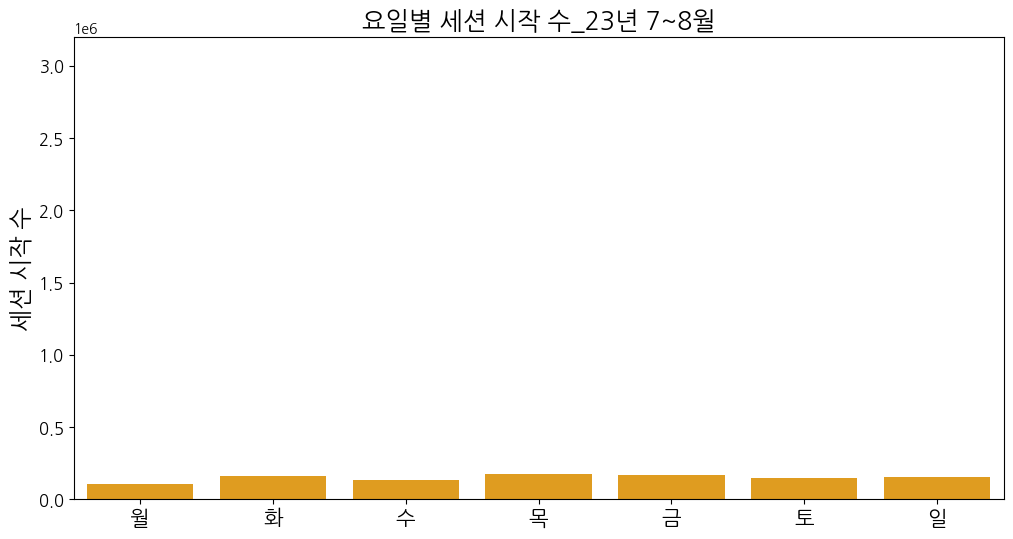

In [41]:
# 요일별로 session_start 수 시각화_추가 hackle 스케일 맞춘버전
plt.figure(figsize=(12, 6))
sns.barplot(data = session_start_week_counts, x = 'event_day_of_week', y = 'session_start_count', color='Orange')
plt.title('요일별 세션 시작 수_23년 7~8월', fontsize = 18)
plt.xlabel('')
plt.ylabel('세션 시작 수', fontsize = 17)   
plt.xticks(ticks = range(7), labels = ['월', '화', '수', '목', '금', '토', '일'], fontsize = 15)
plt.yticks(fontsize = 12)
plt.ylim(0, 3197374) # y스케일 추가 hackle에 맞추기
plt.show()  

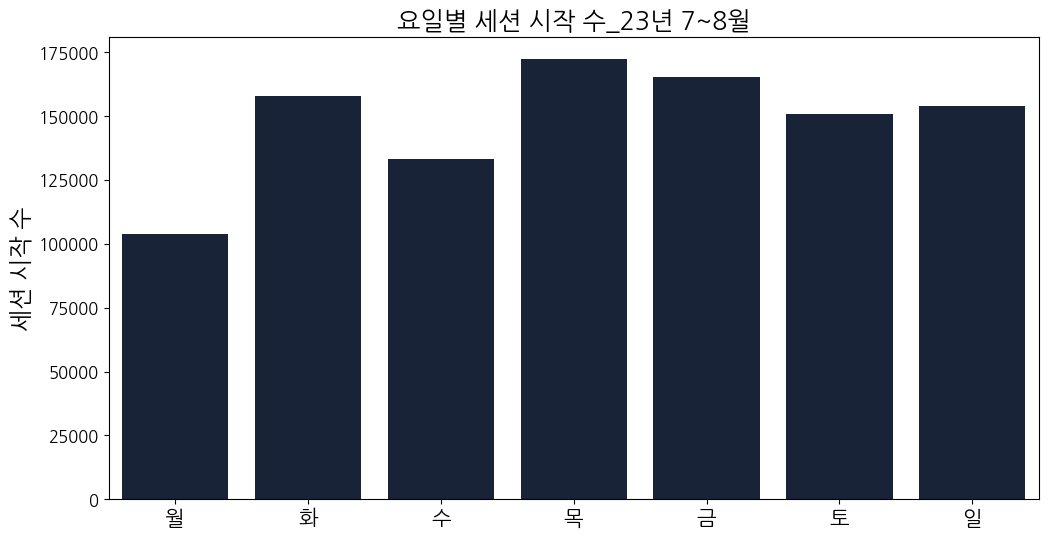

In [25]:
# 요일별로 session_start 수 시각화
# 색상 맵 설정
#custom_palette = sns.light_palette("#14213D", n_colors=7)

plt.figure(figsize=(12, 6))
sns.barplot(data = session_start_week_counts, x = 'event_day_of_week', y = 'session_start_count', color='#14213D')
plt.title('요일별 세션 시작 수_23년 7~8월', fontsize = 18)
plt.xlabel('', fontsize = 17)
plt.ylabel('세션 시작 수', fontsize = 17)   
plt.xticks(ticks = range(7), labels = ['월', '화', '수', '목', '금', '토', '일'], fontsize = 15)
plt.yticks(fontsize = 12)
plt.show()  

,event_hour,count
0,0,60560
1,1,42052
2,2,26708
3,3,15375
4,4,8228
5,5,5714
6,6,7192
7,7,16187
8,8,24154
9,9,25329


count        24.000000
mean      43202.166667
std       26676.819856
min        5714.000000
25%       25035.250000
50%       38731.000000
75%       62775.000000
max      103491.000000
Name: count, dtype: float64

/tmp/ipykernel_12064/1748509207.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = session_start_hour_counts, x = 'event_hour', y = 'count', palette='Oranges')


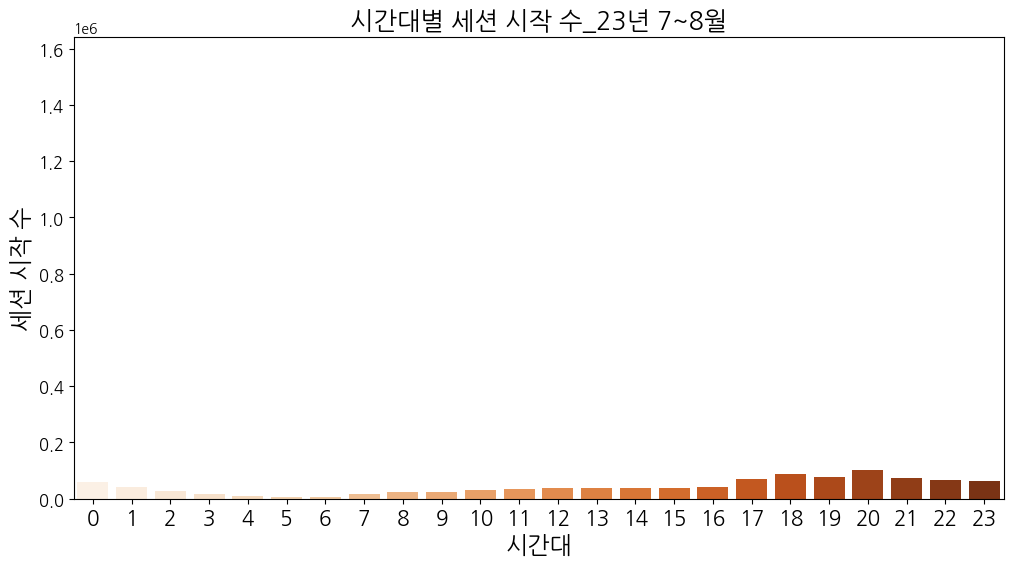

In [21]:

# 시간대별로 session_start 이벤트 개수 집계_추가 hackle 스케일 맞춘버전
session_start_hour_counts = session_start_df['event_hour'].value_counts().sort_index().reset_index()
display(session_start_hour_counts)
display(session_start_hour_counts['count'].describe())

# 시간대별로 session_start 이벤트 개수 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data = session_start_hour_counts, x = 'event_hour', y = 'count', palette='Oranges')
plt.title('시간대별 세션 시작 수_23년 7~8월', fontsize = 18)
plt.xlabel('시간대', fontsize = 17)   
plt.ylabel('세션 시작 수', fontsize = 17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 12)   
plt.ylim(0,1642400) # y스케일 추가 hackle에 맞추기
plt.show()    

/tmp/ipykernel_12064/1731571775.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = session_start_hour_counts, x = 'event_hour', y = 'count', palette=custom_palette)


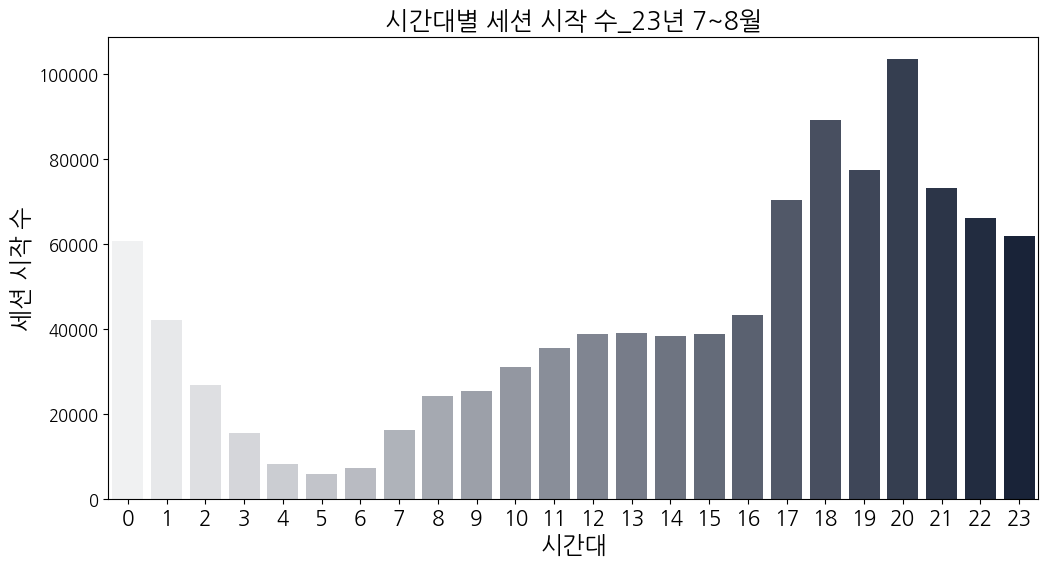

In [24]:
# 시간대별로 session_start 이벤트 개수 시각화
# 색상 맵 설정
custom_palette = sns.light_palette("#14213D", n_colors=24)

plt.figure(figsize=(12, 6))
sns.barplot(data = session_start_hour_counts, x = 'event_hour', y = 'count', palette=custom_palette)
plt.title('시간대별 세션 시작 수_23년 7~8월', fontsize = 18)
plt.xlabel('시간대', fontsize = 17)   
plt.ylabel('세션 시작 수', fontsize = 17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 12)
plt.show()  

# 지표 도출_세션 지속 시간

In [3]:
# 파일 불러오기 (properties + events 파일로! // final.parquet; 정제 후 병합)
# 경로 설정
file_path = "gs://part4_project/hackle/final.parquet"
key_path = "../config/codeit_project_vm_key.json"

# GCS에서 parquet 불러오기
final_hackle_df = pd.read_parquet(file_path, storage_options={"token": key_path})

# 확인
print(final_hackle_df.shape)

(11406944, 12)


In [4]:
show_df_info(final_hackle_df, 'final_hackle_df')


final_hackle_df 형태:


(11406944, 12)


final_hackle_df 첫 5행:


,event_id,event_datetime,event_key,session_id,friend_count,question_id,heart_balance,id,user_id,device_id,osname,osversion
0,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,NaN,NaN,NaN,367093,1041414,590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74,iOS,16.0
1,00114c10-8321-4978-a73f-fd452162b9f2,2023-07-31 19:11:51,click_notice_detail,4OzYh3seq3VKytpSn5pvQkZNQii1,51.0,NaN,1719.0,367093,1041414,590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74,iOS,16.0
2,01f136ac-3257-4cf9-b0a9-c0c37fe7e572,2023-07-31 19:14:34,click_question_open,4OzYh3seq3VKytpSn5pvQkZNQii1,51.0,NaN,1719.0,367093,1041414,590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74,iOS,16.0
3,02cc364e-23ec-46cf-a02f-14cf60f97ec1,2023-07-31 19:13:18,click_question_open,4OzYh3seq3VKytpSn5pvQkZNQii1,51.0,NaN,1719.0,367093,1041414,590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74,iOS,16.0
4,05d05a79-cdb3-43fe-b931-5cb0992a36a1,2023-07-31 19:12:50,click_question_open,4OzYh3seq3VKytpSn5pvQkZNQii1,51.0,NaN,1719.0,367093,1041414,590E7C79-CBA0-44D8-8BE3-3C9BFABBBC74,iOS,16.0



final_hackle_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11406944 entries, 0 to 11406943
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_id        object        
 1   event_datetime  datetime64[ms]
 2   event_key       object        
 3   session_id      object        
 4   friend_count    float64       
 5   question_id     float64       
 6   heart_balance   float64       
 7   id              int64         
 8   user_id         object        
 9   device_id       object        
 10  osname          object        
 11  osversion       object        
dtypes: datetime64[ms](1), float64(3), int64(1), object(7)
memory usage: 1.0+ GB

final_hackle_df 통계 요약:


,event_datetime,friend_count,question_id,heart_balance,id
count,11406944,1.068659e+07,449484.000000,1.071048e+07,1.140694e+07
mean,2023-07-29 02:00:13.502000,5.434417e+01,2766.385262,1.627222e+04,1.703786e+05
min,2023-07-18 00:00:00,0.000000e+00,99.000000,0.000000e+00,2.000000e+00
25%,2023-07-22 21:34:18,3.200000e+01,1393.000000,4.340000e+02,4.501400e+04
50%,2023-07-28 17:09:13,4.900000e+01,2569.000000,1.249000e+03,1.292080e+05
75%,2023-08-04 17:59:48.250000,7.100000e+01,4459.000000,3.188000e+03,2.665000e+05
max,2023-08-10 23:59:59,1.365000e+03,5133.000000,8.849998e+08,5.253470e+05
std,NaN,3.350873e+01,1599.967343,3.317680e+06,1.466598e+05



final_hackle_df 통계 요약:


,event_id,event_key,session_id,user_id,device_id,osname,osversion
count,11406944,11406944,11406944,11406944,11406944,11406944,11406944
unique,11406944,44,242445,239650,242118,2,73
top,00000533-3f1c-4b3b-81f1-0c8f35754b4e,view_lab_tap,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,1134987,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,iOS,16.5.1
freq,1,1266665,8157,17526,8157,7174703,4107821



final_hackle_df 결측치 확인:


event_id                 0
event_datetime           0
event_key                0
session_id               0
friend_count        720352
question_id       10957460
heart_balance       696462
id                       0
user_id                  0
device_id                0
osname                   0
osversion                0
dtype: int64

In [5]:
# id 컬럼 제외하고 중복값 확인 
final_hackle_df.drop(columns = ['id']).duplicated().sum() # 중복없음 !

0

## 세션 관련 EDA (세션 시작과 끝을 무엇으로 볼 것인가?)

### session start/end 개수 기반 탐색

In [ ]:
# 세션 아이디 별로 event_key별 개수 확인 
group_session_event_cnt_df = hackle_events_df.groupby('session_id')['event_key'].value_counts().reset_index(name='count')
print(group_session_event_cnt_df.shape)
group_session_event_cnt_df.head()

(2804315, 3)


,session_id,event_key,count
0,000137bc-80de-4bb5-b61d-df7f217a4501,launch_app,1
1,000137bc-80de-4bb5-b61d-df7f217a4501,$session_start,1
2,00025EE1-BA46-4853-8FDD-B991FABA328F,view_timeline_tap,6
3,00025EE1-BA46-4853-8FDD-B991FABA328F,view_lab_tap,6
4,00025EE1-BA46-4853-8FDD-B991FABA328F,click_notice_detail,6


In [49]:
group_session_event_cnt_df['session_id'].nunique() # session_id 253616 개 

253616

In [47]:
# event_key가 session_start와 session_end인 경우만 필터링
group_session_start_end_df = group_session_event_cnt_df[group_session_event_cnt_df['event_key'].isin(['$session_start', '$session_end'])]

# session_id별로 session_start와 session_end의 개수 확인 
pivot_session_start_end_df = group_session_start_end_df.pivot(index='session_id', columns='event_key', values='count').fillna(0).reset_index()

# 결과 확인
show_df_info(pivot_session_start_end_df,'pivot_session_start_end_df')


pivot_session_start_end_df 형태:


(252883, 3)


pivot_session_start_end_df 첫 5행:


event_key,session_id,$session_end,$session_start
0,000137bc-80de-4bb5-b61d-df7f217a4501,0.0,1.0
1,00025EE1-BA46-4853-8FDD-B991FABA328F,0.0,3.0
2,00039F52-AC9A-4474-A645-DFE225C56753,0.0,1.0
3,0004482B-03B0-4638-8C5A-C2E49C085C7F,0.0,1.0
4,0004F43C-3A7A-4DE4-A02B-55AFDF07E9AD,2.0,4.0



pivot_session_start_end_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252883 entries, 0 to 252882
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   session_id      252883 non-null  object 
 1   $session_end    252883 non-null  float64
 2   $session_start  252883 non-null  float64
dtypes: float64(2), object(1)
memory usage: 5.8+ MB

pivot_session_start_end_df 통계 요약:


event_key,$session_end,$session_start
count,252883.000000,252883.000000
mean,2.569006,4.100125
std,7.389767,7.616743
min,0.000000,0.000000
25%,1.000000,2.000000
50%,1.000000,2.000000
75%,2.000000,4.000000
max,285.000000,284.000000



pivot_session_start_end_df 통계 요약:


event_key,session_id
count,252883
unique,252883
top,000137bc-80de-4bb5-b61d-df7f217a4501
freq,1



pivot_session_start_end_df 결측치 확인:


event_key
session_id        0
$session_end      0
$session_start    0
dtype: int64

- 전체 고유한 session_id 253616개 중에, session_start/end 가 없는 session_id 733개 (약 0.29 %)
- session_start가 있어도 session_end는 없는 경우도 존재
- session_start와 session_end 개수 max 값이 비정상적으로 큼?! 

In [45]:
# session_start/end 별 0 개수 
print((pivot_session_start_end_df['$session_start'] == 0).sum())
print((pivot_session_start_end_df['$session_end'] == 0).sum())

6
51334


- session_start는 거의 0이 없음 (6개)
- session_end는 0인 경우가 많음

In [74]:
# session_start는 0이고 session_end는 1이상인 경우
print(((pivot_session_start_end_df['$session_start'] == 0) & (pivot_session_start_end_df['$session_end'] >= 1)).sum())

# session_end가 0이고 session_start는 1이상인 경우 
print(((pivot_session_start_end_df['$session_end'] == 0) & (pivot_session_start_end_df['$session_start'] >= 1)).sum())

6
51334


- sesion_start가 찍히지 않고 session_end만 있는 경우 6개 
- session_end가 찍히지 않고 session_start만 있는 경우 51334개 (약 20.3%)

In [ ]:
# session_start와 session_end 개수가 동일한 경우 추출 
pivot_session_start_end_df[pivot_session_start_end_df['$session_end'] == pivot_session_start_end_df['$session_start']] 

event_key,session_id,$session_end,$session_start
30,001B9F54-531A-4460-9440-526CC96F2463,2.0,2.0
94,005C4D5D-BF73-428A-96D0-160B200497E3,3.0,3.0
141,008DAA55-8DF3-4405-9E11-D4A95E76825C,178.0,178.0
156,009l5WfLYVTlVCItggiEJyKwWtv2,1.0,1.0
275,00kFYscZytOemEnsUJjkVmgtwNP2,2.0,2.0
...,...,...,...
252414,zqDRFKkjlvZSePNWWHdhDrcITLZ2,4.0,4.0
252445,zqxoadIXYCMnteAw85HIwgBcRyb2,2.0,2.0
252446,zqzSSNaGHkPNTh2VZBxiS3Vjm382,2.0,2.0
252637,zugUBuAPZiOpH5CWXeSbGAriJaN2,2.0,2.0


- 252883개 session_id 중에 3924개만 session_start와 session_end 개수가 동일함 (약 1.55%)

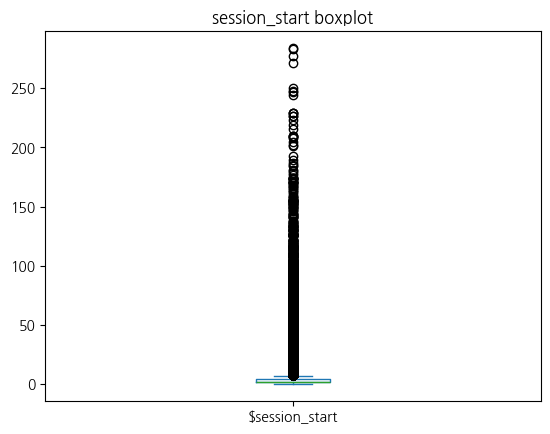

In [88]:
pivot_session_start_end_df['$session_start'].plot(kind = 'box')
plt.title('session_start boxplot')
plt.show()

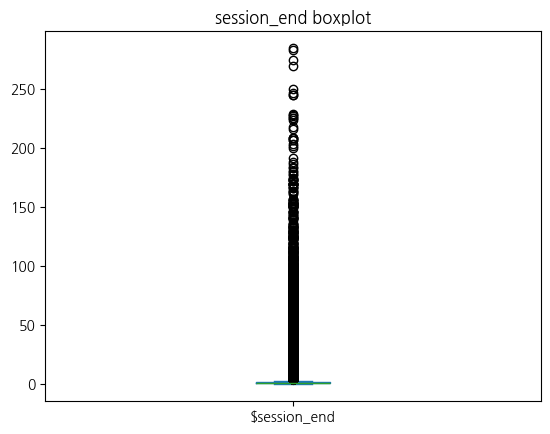

In [89]:
pivot_session_start_end_df['$session_end'].plot(kind = 'box')
plt.title('session_end boxplot')
plt.show()

In [97]:
# 이상치 확인하기
q3 = pivot_session_start_end_df['$session_start'].quantile(0.75)
q1 = pivot_session_start_end_df['$session_start'].quantile(0.25)
iqr = q3 - q1

upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr

# 이상치 행 탐색
pivot_session_start_end_df[(pivot_session_start_end_df['$session_start'] >= upper) | ((pivot_session_start_end_df['$session_start'] <= lower))]
    

event_key,session_id,$session_end,$session_start
5,00057831-A672-4163-9C02-AB920A371F2C,6.0,8.0
9,000C66B7-BD0A-4238-9560-A86E4A3A60A4,5.0,7.0
16,00132348-2ae9-4622-96ab-eabca19e1899,16.0,18.0
18,001384f2-7407-479c-a260-c5b525549274,4.0,7.0
22,00150b66-4b8c-44aa-9005-e4fbdda9506e,51.0,54.0
...,...,...,...
252838,zz8I7PEUOiS7P3Yd0gpqwoa47En2,15.0,17.0
252845,zzM1vj0lTSaztBEYG8yoV8NptCC3,4.0,8.0
252863,zzeFmOTzkLPa4kJ9kWsWnWRJPML2,13.0,16.0
252870,zzmI60yQ07Y0kHefIyC3NMk8oTX2,6.0,7.0


- 이상치로 분류된 session_id 약 10.67%

In [90]:
# 이상치 확인하기
q3 = pivot_session_start_end_df['$session_end'].quantile(0.75)
q1 = pivot_session_start_end_df['$session_end'].quantile(0.25)
iqr = q3 - q1

upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr

# 이상치 행 탐색
pivot_session_start_end_df[(pivot_session_start_end_df['$session_end'] >= upper) | ((pivot_session_start_end_df['$session_end'] <= lower))]
    

event_key,session_id,$session_end,$session_start
5,00057831-A672-4163-9C02-AB920A371F2C,6.0,8.0
6,000638C3-2BC2-4068-A482-861B526B2651,4.0,5.0
9,000C66B7-BD0A-4238-9560-A86E4A3A60A4,5.0,7.0
16,00132348-2ae9-4622-96ab-eabca19e1899,16.0,18.0
18,001384f2-7407-479c-a260-c5b525549274,4.0,7.0
...,...,...,...
252840,zz9NMJdDkRaXsS6XXchFYEsiNyH3,4.0,6.0
252845,zzM1vj0lTSaztBEYG8yoV8NptCC3,4.0,8.0
252863,zzeFmOTzkLPa4kJ9kWsWnWRJPML2,13.0,16.0
252870,zzmI60yQ07Y0kHefIyC3NMk8oTX2,6.0,7.0


- 이상치로 분류된 session_id 약 13.07%

### session start/end 페어링 기반 탐색

In [6]:
# 필요한 컬럼만 추출
session_df = final_hackle_df[final_hackle_df['event_key'].isin(['$session_start', '$session_end'])][['user_id','event_key','event_datetime']]
show_df_info(session_df,'session_df')


session_df 형태:


(1669091, 3)


session_df 첫 5행:


,user_id,event_key,event_datetime
0,1041414,$session_start,2023-07-18 19:40:17
21,1041414,$session_start,2023-07-18 19:40:21
37,1041414,$session_start,2023-07-31 19:11:17
44,1041414,$session_end,2023-07-18 19:40:17
62,1046711,$session_start,2023-07-18 21:01:38



session_df 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 1669091 entries, 0 to 11406942
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   user_id         1669091 non-null  object        
 1   event_key       1669091 non-null  object        
 2   event_datetime  1669091 non-null  datetime64[ms]
dtypes: datetime64[ms](1), object(2)
memory usage: 50.9+ MB

session_df 통계 요약:


,event_datetime
count,1669091
mean,2023-07-28 04:48:07.695000
min,2023-07-18 00:00:00
25%,2023-07-21 20:28:59.500000
50%,2023-07-27 17:00:25
75%,2023-08-03 11:03:48
max,2023-08-10 23:59:58



session_df 통계 요약:


,user_id,event_key
count,1669091,1669091
unique,239210,2
top,1239557,$session_start
freq,573,1022128



session_df 결측치 확인:


user_id           0
event_key         0
event_datetime    0
dtype: int64

In [7]:
# 중복값 확인
session_df.duplicated().sum()

2640

In [ ]:
# 중복값 탐색
session_df[session_df.duplicated()] # 동시간대에 session_start or session_end가 2개 이상 찍힌 경우 (동일 event_key인데 event_id가 다름! )

,user_id,event_key,event_datetime
10921,1106511,$session_start,2023-07-20 21:44:55
30560,1510437,$session_start,2023-08-05 21:20:08
44413,1022880,$session_start,2023-07-28 17:42:01
114810,1211927,$session_start,2023-08-01 02:58:18
157926,1306560,$session_start,2023-07-22 02:40:03
...,...,...,...
11401947,Pe3nY7CXizMiqUrfbarBLfy1z2x2,$session_start,2023-07-19 11:11:56
11401973,962500,$session_start,2023-07-21 20:20:40
11402726,lcIGV9P3i5NtuNr5jJskem9hgBx1,$session_start,2023-08-04 21:23:36
11404472,tJsMCD6KnoglffY1MA7r1EqCmVu2,$session_start,2023-07-20 21:49:45


In [20]:
# 샘플 확인
final_hackle_df[final_hackle_df['user_id'] == '1510437'].sort_values('event_datetime').head(10)

,event_id,event_datetime,event_key,session_id,friend_count,question_id,heart_balance,id,user_id,device_id,osname,osversion
30566,c666a6d2-813e-4e18-9059-2321eaf16ff5,2023-07-25 22:57:00,launch_app,P96SFNCiviS9nOCyNudzLR1bs2B2,NaN,NaN,NaN,76,1510437,e19e3713-7c35-4514-990b-9191eaa77a79,Android,9
30574,f1d93c19-6636-4b25-a5c8-cdb720a90422,2023-07-25 22:57:00,$session_start,P96SFNCiviS9nOCyNudzLR1bs2B2,NaN,NaN,NaN,76,1510437,e19e3713-7c35-4514-990b-9191eaa77a79,Android,9
30555,88f8e6cc-7a8b-429d-aed9-4def1767edd6,2023-08-05 21:20:08,launch_app,P96SFNCiviS9nOCyNudzLR1bs2B2,NaN,NaN,NaN,76,1510437,e19e3713-7c35-4514-990b-9191eaa77a79,Android,9
30543,29888d09-d28d-440f-bdee-7dad541dfad5,2023-08-05 21:20:08,$session_start,P96SFNCiviS9nOCyNudzLR1bs2B2,NaN,NaN,NaN,76,1510437,e19e3713-7c35-4514-990b-9191eaa77a79,Android,9
30560,a6831b9f-4bc1-4cdb-ad64-240d67dff321,2023-08-05 21:20:08,$session_start,P96SFNCiviS9nOCyNudzLR1bs2B2,NaN,NaN,NaN,76,1510437,e19e3713-7c35-4514-990b-9191eaa77a79,Android,9
30539,00ef597b-cbd8-4783-affe-86eab8062203,2023-08-05 21:20:08,$session_end,P96SFNCiviS9nOCyNudzLR1bs2B2,NaN,NaN,NaN,76,1510437,e19e3713-7c35-4514-990b-9191eaa77a79,Android,9
30571,e82cc05d-694e-4b18-ad0c-51ad363f6f67,2023-08-05 21:20:33,view_timeline_tap,P96SFNCiviS9nOCyNudzLR1bs2B2,67.0,NaN,3354.0,76,1510437,e19e3713-7c35-4514-990b-9191eaa77a79,Android,9
30573,ee91a1d2-a883-4491-acff-e82f25bd5598,2023-08-05 21:20:33,click_bottom_navigation_profile,P96SFNCiviS9nOCyNudzLR1bs2B2,67.0,NaN,3354.0,76,1510437,e19e3713-7c35-4514-990b-9191eaa77a79,Android,9
30563,c4f98ee5-4cf5-4c8f-82dd-f6c9181e7ac6,2023-08-05 21:20:33,view_profile_tap,P96SFNCiviS9nOCyNudzLR1bs2B2,67.0,NaN,3354.0,76,1510437,e19e3713-7c35-4514-990b-9191eaa77a79,Android,9
30537,0000683d-7cfe-4b78-8ee7-c59593187d04,2023-08-05 21:20:33,view_lab_tap,P96SFNCiviS9nOCyNudzLR1bs2B2,67.0,NaN,3354.0,76,1510437,e19e3713-7c35-4514-990b-9191eaa77a79,Android,9


In [16]:
# 샘플 확인
hackle_properties_df[hackle_properties_df['user_id'] == '1510437']

,id,session_id,user_id,language,osname,osversion,versionname,device_id
75,76,P96SFNCiviS9nOCyNudzLR1bs2B2,1510437,ko,Android,9,2.0.5,e19e3713-7c35-4514-990b-9191eaa77a79


In [19]:
# 샘플 확인인
hackle_events_df[hackle_events_df['session_id'] == 'P96SFNCiviS9nOCyNudzLR1bs2B2'].sort_values('event_datetime').head(10)

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
8867844,c666a6d2-813e-4e18-9059-2321eaf16ff5,2023-07-25 22:57:00,launch_app,P96SFNCiviS9nOCyNudzLR1bs2B2,c666a6d2-813e-4e18-9059-2321eaf16ff5,,,NaN,NaN,NaN,NaN
10809981,f1d93c19-6636-4b25-a5c8-cdb720a90422,2023-07-25 22:57:00,$session_start,P96SFNCiviS9nOCyNudzLR1bs2B2,f1d93c19-6636-4b25-a5c8-cdb720a90422,,,NaN,NaN,NaN,NaN
6124309,88f8e6cc-7a8b-429d-aed9-4def1767edd6,2023-08-05 21:20:08,launch_app,P96SFNCiviS9nOCyNudzLR1bs2B2,88f8e6cc-7a8b-429d-aed9-4def1767edd6,,,NaN,NaN,NaN,NaN
1856183,29888d09-d28d-440f-bdee-7dad541dfad5,2023-08-05 21:20:08,$session_start,P96SFNCiviS9nOCyNudzLR1bs2B2,29888d09-d28d-440f-bdee-7dad541dfad5,,,NaN,NaN,NaN,NaN
7442471,a6831b9f-4bc1-4cdb-ad64-240d67dff321,2023-08-05 21:20:08,$session_start,P96SFNCiviS9nOCyNudzLR1bs2B2,a6831b9f-4bc1-4cdb-ad64-240d67dff321,,,NaN,NaN,NaN,NaN
41520,00ef597b-cbd8-4783-affe-86eab8062203,2023-08-05 21:20:08,$session_end,P96SFNCiviS9nOCyNudzLR1bs2B2,00ef597b-cbd8-4783-affe-86eab8062203,,,NaN,NaN,NaN,NaN
10377044,e82cc05d-694e-4b18-ad0c-51ad363f6f67,2023-08-05 21:20:33,view_timeline_tap,P96SFNCiviS9nOCyNudzLR1bs2B2,e82cc05d-694e-4b18-ad0c-51ad363f6f67,,,67.0,136.0,3354.0,NaN
10663418,ee91a1d2-a883-4491-acff-e82f25bd5598,2023-08-05 21:20:33,click_bottom_navigation_profile,P96SFNCiviS9nOCyNudzLR1bs2B2,ee91a1d2-a883-4491-acff-e82f25bd5598,,,67.0,136.0,3354.0,NaN
8803853,c4f98ee5-4cf5-4c8f-82dd-f6c9181e7ac6,2023-08-05 21:20:33,view_profile_tap,P96SFNCiviS9nOCyNudzLR1bs2B2,c4f98ee5-4cf5-4c8f-82dd-f6c9181e7ac6,,,67.0,136.0,3354.0,NaN
75,0000683d-7cfe-4b78-8ee7-c59593187d04,2023-08-05 21:20:33,view_lab_tap,P96SFNCiviS9nOCyNudzLR1bs2B2,0000683d-7cfe-4b78-8ee7-c59593187d04,,,67.0,136.0,3354.0,NaN


- 동시간대에 session_start or session_end가 2개 이상 찍힌 경우가 중복값으로 잡힘 (동일 event_key인데 event_id가 다름!)
- session_start와 session_end가 동시간대인 경우도 있지만, 이건 짝 지어주고 나서 나중에 처리! 
- 우선 중복값 제거 결정!

In [22]:
# 중복값 제거
session_df = session_df.drop_duplicates()
session_df.shape

(1666451, 3)

In [23]:
session_df.describe(include='all')

,user_id,event_key,event_datetime
count,1666451,1666451,1666451
unique,239210,2,NaN
top,1239557,$session_start,NaN
freq,573,1019954,NaN
mean,NaN,NaN,2023-07-28 04:50:52.596000
min,NaN,NaN,2023-07-18 00:00:00
25%,NaN,NaN,2023-07-21 20:29:47
50%,NaN,NaN,2023-07-27 17:05:40
75%,NaN,NaN,2023-08-03 11:08:24.500000
max,NaN,NaN,2023-08-10 23:59:58


In [ ]:
# final_hackle : 327380 유저 중 326940 유저만 session_start/end 보유! -> 440명의 유저는 둘다 없음 (0.13%)
# final : 239650 유저 중 239210 유저만 session_start/end 보유! -> 440명의 유저는 둘다 없음 (0.18%)

In [27]:
# session_df 정렬 
session_df = session_df.sort_values(by=['user_id', 'event_datetime']).reset_index(drop=True)

matched_sessions = []

for user_id, group in session_df.groupby('user_id'):
    starts = []
    used_indices = set()
    group = group.sort_values(by='event_datetime').reset_index(drop=True)

    for idx, row in group.iterrows():
        if row['event_key'] == '$session_start':
            starts.append({
                'index': idx,
                'start_time': row['event_datetime'],
                'end_time': pd.NaT,
                'matched': False
            })

    for idx, row in group.iterrows():
        if row['event_key'] == '$session_end':
            # 가능한 start 중 end보다 같거나 작고, 아직 매칭되지 않은 가장 최근 start 찾기
            candidates = [s for s in starts if not s['matched'] and s['start_time'] <= row['event_datetime']]
            if candidates:
                latest_start = max(candidates, key=lambda x: x['start_time'])
                latest_start['end_time'] = row['event_datetime']
                latest_start['matched'] = True
            else:
                # 매칭 안 되는 end는 따로 기록
                matched_sessions.append({
                    'user_id': user_id,
                    'start_time': pd.NaT,
                    'end_time': row['event_datetime'],
                    'session_duration_sec': np.nan
                })

    # 최종 세션 리스트로 구성
    for s in starts:
        matched_sessions.append({
            'user_id': user_id,
            'start_time': s['start_time'],
            'end_time': s['end_time'],
            'session_duration_sec': (
                (s['end_time'] - s['start_time']).total_seconds() if pd.notna(s['end_time']) else np.nan
            )
        })

matched_session_df = pd.DataFrame(matched_sessions)
matched_session_df = matched_session_df.sort_values(by=['user_id', 'start_time', 'end_time']).reset_index(drop=True)

print(matched_session_df.shape)

# 4분 8초 걸림

(1023842, 4)


In [28]:
# matched_session_id 기본 사항 확인 
show_df_info(matched_session_df,'matched_session_df')


matched_session_df 형태:


(1023842, 4)


matched_session_df 첫 5행:


,user_id,start_time,end_time,session_duration_sec
0,012Si5t33QgB3g18oOpcd2RDx5U2,2023-07-25 12:59:58,NaT,NaN
1,01BFWYlo11eFmY64kiY6n5PQAcs1,2023-07-18 20:45:12,NaT,NaN
2,01pPQO7oPmgKZOU7f8XGc93rCWg2,2023-07-25 22:15:41,NaT,NaN
3,02Ika66GtzVQj5Epl6xtwcGf72u1,2023-07-20 21:59:56,NaT,NaN
4,02QVyNBCraNN7i04MPRQVrGbGPR2,2023-07-21 08:59:54,2023-07-21 08:59:58,4.0



matched_session_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023842 entries, 0 to 1023841
Data columns (total 4 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   user_id               1023842 non-null  object        
 1   start_time            1019954 non-null  datetime64[ns]
 2   end_time              646497 non-null   datetime64[ns]
 3   session_duration_sec  642609 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 31.2+ MB

matched_session_df 통계 요약:


,start_time,end_time,session_duration_sec
count,1019954,646497,6.426090e+05
mean,2023-07-28 10:42:17.204904704,2023-07-27 19:36:28.201991168,1.646716e+03
min,2023-07-18 00:00:00,2023-07-18 00:00:00,0.000000e+00
25%,2023-07-21 23:19:15.249999872,2023-07-21 17:35:10,1.000000e+00
50%,2023-07-27 19:10:43,2023-07-26 20:54:51,1.900000e+01
75%,2023-08-03 21:10:44,2023-08-02 15:48:59,1.240000e+02
max,2023-08-10 23:59:58,2023-08-10 23:59:54,1.972598e+06
std,NaN,NaN,2.910615e+04



matched_session_df 통계 요약:


,user_id
count,1023842
unique,239210
top,1239557
freq,287



matched_session_df 결측치 확인:


user_id                      0
start_time                3888
end_time                377345
session_duration_sec    381233
dtype: int64

In [29]:
# start_time과 end_time 모두 있는 경우 : matched
# start만 : start_only
# end만 : end_only

# 페어링 여부 컬럼 추가 
def check_matched(row):
    if pd.notnull(row['start_time']) and pd.notnull(row['end_time']):
        return 'matched'
    elif pd.notnull(row['start_time']) and pd.isna(row['end_time']):
        return 'start_only'
    elif pd.isna(row['start_time']) and pd.notnull(row['end_time']):
        return 'end_only'
    else:
        return 'unknown'

matched_session_df['session_flag'] = matched_session_df.apply(check_matched, axis=1) 
print(matched_session_df.shape)

(1023842, 5)


In [ ]:
## matched_session_df 불러오기 (저장해놓고 불러오면서 쓰기)
matched_session_df = pd.read_parquet("/home/codeit_project_vm/codeit_project/codeit-project-docker/data/matched_session_df.parquet")

print(matched_session_df.shape)

(1023842, 5)


In [30]:
# 중복값 확인
matched_session_df.duplicated().sum() # 중복값 없음

0

In [5]:
# session_flag 별 확인
print('\nsession 매칭 여부 별 개수')
print(matched_session_df['session_flag'].value_counts())
print('\nsession 매칭 여부 별 개수 비율')
print(matched_session_df['session_flag'].value_counts(normalize=True))  # 비율


session 매칭 여부 별 개수
session_flag
matched       642609
start_only    377345
end_only        3888
Name: count, dtype: int64

session 매칭 여부 별 개수 비율
session_flag
matched       0.627645
start_only    0.368558
end_only      0.003797
Name: proportion, dtype: float64


In [5]:
show_df_info(matched_session_df,'matched_session_df')


matched_session_df 형태:


(1023842, 5)


matched_session_df 첫 5행:


,user_id,start_time,end_time,session_duration_sec,session_flag
0,012Si5t33QgB3g18oOpcd2RDx5U2,2023-07-25 12:59:58,NaT,NaN,start_only
1,01BFWYlo11eFmY64kiY6n5PQAcs1,2023-07-18 20:45:12,NaT,NaN,start_only
2,01pPQO7oPmgKZOU7f8XGc93rCWg2,2023-07-25 22:15:41,NaT,NaN,start_only
3,02Ika66GtzVQj5Epl6xtwcGf72u1,2023-07-20 21:59:56,NaT,NaN,start_only
4,02QVyNBCraNN7i04MPRQVrGbGPR2,2023-07-21 08:59:54,2023-07-21 08:59:58,4.0,matched



matched_session_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023842 entries, 0 to 1023841
Data columns (total 5 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   user_id               1023842 non-null  object        
 1   start_time            1019954 non-null  datetime64[ns]
 2   end_time              646497 non-null   datetime64[ns]
 3   session_duration_sec  642609 non-null   float64       
 4   session_flag          1023842 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 39.1+ MB

matched_session_df 통계 요약:


,start_time,end_time,session_duration_sec
count,1019954,646497,6.426090e+05
mean,2023-07-28 10:42:17.204904704,2023-07-27 19:36:28.201991168,1.646716e+03
min,2023-07-18 00:00:00,2023-07-18 00:00:00,0.000000e+00
25%,2023-07-21 23:19:15.249999872,2023-07-21 17:35:10,1.000000e+00
50%,2023-07-27 19:10:43,2023-07-26 20:54:51,1.900000e+01
75%,2023-08-03 21:10:44,2023-08-02 15:48:59,1.240000e+02
max,2023-08-10 23:59:58,2023-08-10 23:59:54,1.972598e+06
std,NaN,NaN,2.910615e+04



matched_session_df 통계 요약:


,user_id,session_flag
count,1023842,1023842
unique,239210,3
top,1239557,matched
freq,287,642609



matched_session_df 결측치 확인:


user_id                      0
start_time                3888
end_time                377345
session_duration_sec    381233
session_flag                 0
dtype: int64

In [33]:
517357 / 1340790 * 100 # 전체 행의 약 47% 결측치 -> 37% -> user_id로 바꾸면 38.6% -> final_hackle 38.5%
381233 / 1023842 * 100 # 전체 행의 약 37% 결측치 (final)

37.23553048224238

In [28]:
# session 매칭 확인 
# session_id == 003C3A7D-E37A-43DE-B34D-BDB80CFBAB2B
# session_id == 0004F43C-3A7A-4DE4-A02B-55AFDF07E9AD

In [34]:
matched_session_df[matched_session_df['session_flag'] == 'matched']['user_id'].nunique() 

# final_hackle : 326940 유저 중 284547 유저가 matched 세션 보유 (약 87%)
# final : 239210 유저 중 196997 유저가 matched 세션 보유 (약 82.4%)

196997

In [40]:
matched_session_df[matched_session_df['start_time'] > matched_session_df['end_time']] # end_time이 더 빠른 경우 없음

,user_id,start_time,end_time,session_duration_sec,session_flag


In [41]:
# matched_session_df parquet으로 내보내기 
matched_session_df.to_parquet("../data/matched_session_df.parquet", engine="pyarrow", compression="snappy")

### start_only, end_only 보정? 
- 직전 이벤트와 end_time의 시간 차이, 직후 이벤트와 start_time의 시간 차이 구하고 결정하자

(처음 생각)     
session_start와 session_end 가 짝지어진 것으로 부터 구하기
- session_end 없는 경우          
session_end와 바로 직전 event의 시간 차이를 구하고, 그 시간차의 평균,중앙값 등으로 end 없는 경우 보정

- session_start 없는 경우      
session_start와 바로 직후 event의 시간 차이로 보정! 

In [ ]:
# # 1. user_events_df를 시간 기준 정렬 (만약 정렬이 안 되어 있으면)
# user_events_df = user_events_df.sort_values(['user_id', 'event_datetime']).reset_index(drop=True)

# # 2. session_start 이벤트 다음 이벤트 찾기
# # shift(-1)으로 다음 이벤트 가져오기
# user_events_df['next_event_key'] = user_events_df.groupby('user_id')['event_key'].shift(-1)
# user_events_df['next_event_time'] = user_events_df.groupby('user_id')['event_datetime'].shift(-1)
# # shift(1)로 이전 이벤트 가져오기
# user_events_df['prev_event_key'] = user_events_df.groupby('user_id')['event_key'].shift(1)
# user_events_df['prev_event_time'] = user_events_df.groupby('user_id')['event_datetime'].shift(1)

# # 3. start 이벤트에서 다음 이벤트와 시간차 계산
# start_events = user_events_df[user_events_df['event_key'] == '$session_start'].copy()
# start_events['time_to_next'] = (start_events['next_event_time'] - start_events['event_datetime']).dt.total_seconds()

# # 4. end 이벤트에서 이전 이벤트와 시간차 계산
# end_events = user_events_df[user_events_df['event_key'] == '$session_end'].copy()
# end_events['time_from_prev'] = (end_events['event_datetime'] - end_events['prev_event_time']).dt.total_seconds()

# # 5. 결과 확인
# print("Start events + next event 시간차 분포")
# print(start_events['time_to_next'].describe())

# print("End events + prev event 시간차 분포")
# print(end_events['time_from_prev'].describe())


Start events + next event 시간차 분포
count    1.296429e+06
mean     1.524910e+04
std      1.135809e+05
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      7.000000e+00
max      2.036672e+06
Name: time_to_next, dtype: float64
End events + prev event 시간차 분포
count    7.680660e+05
mean     5.365429e+03
std      5.940002e+04
min      0.000000e+00
25%      1.000000e+00
50%      4.000000e+00
75%      1.200000e+01
max      2.043603e+06
Name: time_from_prev, dtype: float64


- start와 직후 이벤트 시간차이의 중앙값 : 2초   
- end와 직전 이벤트 시간차이의 중앙값 : 4초

### ❌ 보정한 데이터를 쓸 때의 위험

| 보정 방식 | 위험 요소 |
| --- | --- |
| 중앙값 duration 덧셈 방식(추가 hackle) | 실제로 매우 짧거나 긴 세션을 평균적으로 덮어버림 → 평균 세션 시간이 **왜곡**됨 |
| 직후/직전 이벤트 시간차 기반 추정(기존 hackle) | 직후/직전 이벤트가 session 경계가 아닐 수 있음 → **정확한 종료/시작 시점이 아닐 수 있음** |
| 둘 다 공통 | 결국 **정확한 session_duration이 아님** → 평균 계산에 **노이즈를 넣는 셈** |

---

### ✅ 결론: **정확한 평균을 원한다면, 보정하지 마라**

> "정확한 세션 지속 시간"이 목적이라면
> 
> 
> → **start와 end가 정확히 짝지어진 쌍만 사용해야 함**
> 
- 지금 전체 데이터 중 **약 60%가 짝지어진 상태**면 충분히 유의미한 수치를 도출할 수 있음
- 오히려 나머지 40%를 보정하려다가 **정확도를 희생**하는 게 더 위험

## 지표 작업

### matched_df 정제

In [4]:
# matched인 경우만 따로 추출
matched_df = matched_session_df[matched_session_df['session_flag'] == 'matched']
matched_df.shape

(642609, 5)

In [28]:
show_df_info(matched_df,'matched_df')


matched_df 형태:


(642609, 5)


matched_df 첫 5행:


,user_id,start_time,end_time,session_duration_sec,session_flag
4,02QVyNBCraNN7i04MPRQVrGbGPR2,2023-07-21 08:59:54,2023-07-21 08:59:58,4.0,matched
9,02XESxpLLGgCRmrko2FsQJgmr0Z2,2023-08-06 19:53:16,2023-08-06 19:53:16,0.0,matched
13,03dEZCajSgbBSj7wPNeXjBp8QnI2,2023-07-18 07:22:11,2023-07-18 07:22:12,1.0,matched
15,03dEZCajSgbBSj7wPNeXjBp8QnI2,2023-07-25 17:01:31,2023-07-25 17:01:32,1.0,matched
16,03dEZCajSgbBSj7wPNeXjBp8QnI2,2023-07-25 21:15:39,2023-07-25 21:15:46,7.0,matched



matched_df 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 642609 entries, 4 to 1023840
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   user_id               642609 non-null  object        
 1   start_time            642609 non-null  datetime64[ns]
 2   end_time              642609 non-null  datetime64[ns]
 3   session_duration_sec  642609 non-null  float64       
 4   session_flag          642609 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 29.4+ MB

matched_df 통계 요약:


,start_time,end_time,session_duration_sec
count,642609,642609,6.426090e+05
mean,2023-07-27 19:47:02.039316480,2023-07-27 20:14:28.755688704,1.646716e+03
min,2023-07-18 00:00:00,2023-07-18 00:00:00,0.000000e+00
25%,2023-07-21 17:59:12,2023-07-21 18:23:12,1.000000e+00
50%,2023-07-26 21:13:32,2023-07-26 21:44:38,1.900000e+01
75%,2023-08-02 15:58:21,2023-08-02 16:34:27,1.240000e+02
max,2023-08-10 23:59:54,2023-08-10 23:59:54,1.972598e+06
std,NaN,NaN,2.910615e+04



matched_df 통계 요약:


,user_id,session_flag
count,642609,642609
unique,196997,1
top,1239557,matched
freq,286,642609



matched_df 결측치 확인:


user_id                 0
start_time              0
end_time                0
session_duration_sec    0
session_flag            0
dtype: int64

In [11]:
matched_df['session_duration_sec'].value_counts()

session_duration_sec
0.0         154535
1.0          25330
5.0          13464
4.0          13115
6.0          12697
             ...  
5311.0           1
7403.0           1
5290.0           1
7357.0           1
236603.0         1
Name: count, Length: 10924, dtype: int64

In [12]:
matched_df[matched_df['start_time'] == matched_df['end_time']].shape # 전체 행의 약 24% 

(154535, 5)

- start_time과 end_time이 동일한 경우 존재..! 
- 평균 왜곡 가능성 존재, 비정상적인 로그이기도 함! 키자마자 동시에 종료? 
- 우선 따로 빼두고 matched_df에는 start_time != end_time 경우만 남기기

In [5]:
# start_time == end_time 만 추출해놓기
same_time_df = matched_df[matched_df['start_time'] == matched_df['end_time']]
# start_time == end_time 제외
matched_df = matched_df[matched_df['start_time'] != matched_df['end_time']]

In [73]:
matched_df.describe()

,start_time,end_time,session_duration_sec
count,488074,488074,4.880740e+05
mean,2023-07-28 00:47:30.812720896,2023-07-28 01:23:38.915837952,2.168103e+03
min,2023-07-18 00:00:03,2023-07-18 00:00:09,1.000000e+00
25%,2023-07-21 19:40:13,2023-07-21 19:49:59,1.000000e+01
50%,2023-07-27 00:43:51,2023-07-27 01:21:25.500000,5.400000e+01
75%,2023-08-02 21:32:39.249999872,2023-08-02 22:12:08,1.980000e+02
max,2023-08-10 23:58:48,2023-08-10 23:59:53,1.972598e+06
std,NaN,NaN,3.338068e+04


In [28]:
Q1 = matched_df['session_duration_sec'].quantile(0.25)
Q3 = matched_df['session_duration_sec'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR # 480초(8분)
lower_bound, upper_bound

(-272.0, 480.0)

In [29]:
(matched_df['session_duration_sec'] > upper_bound).sum() / len(matched_df['session_duration_sec']) * 100 # 15%가 이상치

15.56280400103263

In [14]:
# 초 → HH:MM:SS 변환 함수
def seconds_to_hms(seconds):
    seconds = int(seconds)
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    return f'{hours:02}:{minutes:02}:{secs:02}'

# 상위 1% ~ 0.1%까지 확인
percentiles = [0.990, 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999]
summary_list = []

# 반복 처리
for p in percentiles:
    cut = matched_df['session_duration_sec'].quantile(p)
    temp = matched_df[matched_df['session_duration_sec'] > cut]
    
    summary = {
        '상위 비율': f'{round((1 - p) * 100, 1)}%',
        '컷오프 (초)': round(cut, 2),
        '컷오프 (시:분:초)': seconds_to_hms(cut),
        '개수': temp.shape[0],
        '최소': seconds_to_hms(temp['session_duration_sec'].min()),
        '25%': seconds_to_hms(temp['session_duration_sec'].quantile(0.25)),
        '50% (중앙값)': seconds_to_hms(temp['session_duration_sec'].quantile(0.5)),
        '75%': seconds_to_hms(temp['session_duration_sec'].quantile(0.75)),
        '평균': seconds_to_hms(temp['session_duration_sec'].mean()),
        '최대': seconds_to_hms(temp['session_duration_sec'].max())
    }
    summary_list.append(summary)

# 결과 데이터프레임
summary_df = pd.DataFrame(summary_list)
display(summary_df)



,상위 비율,컷오프 (초),컷오프 (시:분:초),개수,최소,25%,50% (중앙값),75%,평균,최대
0,1.0%,8420.08,02:20:20,4881,02:20:23,05:30:32,20:40:17,64:38:59,52:10:55,547:56:38
1,0.9%,10873.34,03:01:13,4393,03:01:14,08:52:51,24:09:11,71:45:52,57:41:08,547:56:38
2,0.8%,15384.08,04:16:24,3905,04:16:27,13:24:17,29:27:35,80:05:44,64:27:02,547:56:38
3,0.7%,27561.49,07:39:21,3417,07:39:22,18:36:17,39:46:50,92:53:49,72:50:27,547:56:38
4,0.6%,48248.24,13:24:08,2929,13:24:17,24:09:11,49:16:23,106:59:23,83:15:20,547:56:38
5,0.5%,74416.27,20:40:16,2441,20:40:17,34:48:17,64:38:59,123:52:50,96:32:56,547:56:38
6,0.4%,106046.24,29:27:26,1953,29:27:35,49:16:23,80:05:44,147:29:40,114:34:39,547:56:38
7,0.3%,177365.70,49:16:05,1465,49:16:23,71:45:52,106:59:23,181:30:56,139:35:04,547:56:38
8,0.2%,288336.26,80:05:36,977,80:05:44,106:59:23,147:29:40,220:27:49,177:28:52,547:56:38
9,0.1%,530933.06,147:28:53,489,147:29:40,181:30:56,220:27:49,287:09:13,245:05:21,547:56:38


In [6]:
# 상위 0.5% 커트 기준
cutoff = matched_df['session_duration_sec'].quantile(0.995)

# 이상치 제거된 데이터프레임
cleaned_df = matched_df[matched_df['session_duration_sec'] <= cutoff]

# 상위 0.5% 이상치 따로 저장 
outliers_df = matched_df[matched_df['session_duration_sec'] > cutoff]


In [9]:
print(cleaned_df.shape) # matched_df의 약 99% 유지됨! (start_time != end_time 인 경우의 matched_df)
cleaned_df.describe(include = 'all')

(485633, 5)


,user_id,start_time,end_time,session_duration_sec,session_flag
count,485633,485633,485633,485633.000000,485633
unique,116812,NaN,NaN,NaN,1
top,1253311,NaN,NaN,NaN,matched
freq,283,NaN,NaN,NaN,485633
mean,NaN,2023-07-28 00:59:54.254381312,2023-07-28 01:07:06.186667520,431.932286,NaN
min,NaN,2023-07-18 00:00:03,2023-07-18 00:00:09,1.000000,NaN
25%,NaN,2023-07-21 19:40:53,2023-07-21 19:46:17,10.000000,NaN
50%,NaN,2023-07-27 00:55:29,2023-07-27 01:02:19,53.000000,NaN
75%,NaN,2023-08-02 21:56:39,2023-08-02 22:03:14,193.000000,NaN
max,NaN,2023-08-10 23:58:48,2023-08-10 23:59:34,74415.000000,NaN


### 유저별 평균 세션 지속 시간 집계

In [7]:
# 유저별 평균 세션 지속시간
avg_duration_df = cleaned_df.groupby('user_id')['session_duration_sec'].mean().reset_index(name = 'avg_duration_sec')
show_df_info(avg_duration_df, 'avg_duration_df')


avg_duration_df 형태:


(116812, 2)


avg_duration_df 첫 5행:


,user_id,avg_duration_sec
0,02QVyNBCraNN7i04MPRQVrGbGPR2,4.0
1,03dEZCajSgbBSj7wPNeXjBp8QnI2,2.2
2,07JXIRPEnuSSpzQ5cKYrvwrMq3I3,1.0
3,08g6HjWIPUZttChnM4McJAlbgyl1,174.0
4,08tcnzqYmaZ81F7s29QPu5PUrP13,4.0



avg_duration_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116812 entries, 0 to 116811
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           116812 non-null  object 
 1   avg_duration_sec  116812 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.8+ MB

avg_duration_df 통계 요약:


,avg_duration_sec
count,116812.000000
mean,299.900599
std,1625.894811
min,1.000000
25%,18.000000
50%,75.333333
75%,231.333333
max,73566.000000



avg_duration_df 통계 요약:


,user_id
count,116812
unique,116812
top,02QVyNBCraNN7i04MPRQVrGbGPR2
freq,1



avg_duration_df 결측치 확인:


user_id             0
avg_duration_sec    0
dtype: int64

In [153]:
avg_duration_df.sort_values('avg_duration_sec',ascending=False)

,user_id,avg_duration_sec
65492,1361836,73566.0
30441,1159331,73463.0
78949,1452437,72726.0
37109,1193947,72361.0
92994,1544364,71263.0
...,...,...
57425,1310993,1.0
57422,1310969,1.0
57421,1310967,1.0
57393,1310795,1.0


In [115]:
# 최장 세션길이 탐색
matched_df[matched_df['user_id'] == '1361836']

,user_id,start_time,end_time,session_duration_sec,session_flag
538930,1361836,2023-08-04 18:15:54,2023-08-05 14:42:00,73566.0,matched


In [121]:
final_hackle_df[final_hackle_df['user_id'] == '1361836'].sort_values('event_datetime')

,event_id,event_datetime,event_key,session_id,friend_count,question_id,heart_balance,id,user_id,device_id,osname,osversion
8032019,dc8a6202-6ed8-477a-97d8-1e6a83d64004,2023-08-04 18:15:54,$session_start,SltpzIM3K6bzsSdFSzmhdtAcVnm2,NaN,NaN,NaN,103836,1361836,8E3D24C3-8A3A-4E1E-86CE-B3FCBCECDEE8,iOS,16.6
8031993,7987966b-f8e9-4e9b-9888-0df0a7d11295,2023-08-04 18:15:54,launch_app,SltpzIM3K6bzsSdFSzmhdtAcVnm2,NaN,NaN,NaN,103836,1361836,8E3D24C3-8A3A-4E1E-86CE-B3FCBCECDEE8,iOS,16.6
8031986,3c69645c-cf8c-41fc-be38-fa14b70ab689,2023-08-05 14:39:21,$session_start,SltpzIM3K6bzsSdFSzmhdtAcVnm2,31.0,NaN,6535.0,103836,1361836,8E3D24C3-8A3A-4E1E-86CE-B3FCBCECDEE8,iOS,16.6
8032017,d6695582-d1ee-4bd6-8b40-b6c60bba41da,2023-08-05 14:39:21,$session_end,SltpzIM3K6bzsSdFSzmhdtAcVnm2,31.0,NaN,6535.0,103836,1361836,8E3D24C3-8A3A-4E1E-86CE-B3FCBCECDEE8,iOS,16.6
8031971,0e84ac50-0afe-4824-a297-79a13db03289,2023-08-05 14:39:21,launch_app,SltpzIM3K6bzsSdFSzmhdtAcVnm2,31.0,NaN,6535.0,103836,1361836,8E3D24C3-8A3A-4E1E-86CE-B3FCBCECDEE8,iOS,16.6
8031997,8d1476fb-d826-459a-ac90-e170e3667397,2023-08-05 14:39:21,$session_start,SltpzIM3K6bzsSdFSzmhdtAcVnm2,31.0,NaN,6535.0,103836,1361836,8E3D24C3-8A3A-4E1E-86CE-B3FCBCECDEE8,iOS,16.6
8032000,8f9a97e3-58f9-45a8-9260-c238bb27a651,2023-08-05 14:39:26,click_appbar_alarm_center,SltpzIM3K6bzsSdFSzmhdtAcVnm2,31.0,NaN,6535.0,103836,1361836,8E3D24C3-8A3A-4E1E-86CE-B3FCBCECDEE8,iOS,16.6
8031984,30a1f50f-4ac6-49a6-b25b-5c40cb7c6747,2023-08-05 14:39:28,click_bottom_navigation_questions,SltpzIM3K6bzsSdFSzmhdtAcVnm2,31.0,NaN,6535.0,103836,1361836,8E3D24C3-8A3A-4E1E-86CE-B3FCBCECDEE8,iOS,16.6
8032020,dc952bcd-53a9-4003-837a-270970bd184e,2023-08-05 14:39:29,click_bottom_navigation_questions,SltpzIM3K6bzsSdFSzmhdtAcVnm2,31.0,NaN,6535.0,103836,1361836,8E3D24C3-8A3A-4E1E-86CE-B3FCBCECDEE8,iOS,16.6
8032002,9694ebcf-6496-43a0-abb0-15b4fde43a08,2023-08-05 14:39:29,click_bottom_navigation_questions,SltpzIM3K6bzsSdFSzmhdtAcVnm2,31.0,NaN,6535.0,103836,1361836,8E3D24C3-8A3A-4E1E-86CE-B3FCBCECDEE8,iOS,16.6


- 2023-08-04 18:15:54 에 session_start 한 후 제대로 session_end가 남지 않음!
- 2023-08-05 14:39:21 session_start 2개여서 -> 중복 제거 후 1개만 남았을 것 
- 동시간대에 session_start, session_end가 찍혀서 -> 이건 matched_df에서는 제외됨!
- 그 다음 처음 나온 session_end가 2023-08-05 14:42:00! 

In [154]:
avg_duration_df['avg_duration_sec'].describe() # max 값 73566초 (20시간 26분)

count    116812.000000
mean        299.900599
std        1625.894811
min           1.000000
25%          18.000000
50%          75.333333
75%         231.333333
max       73566.000000
Name: avg_duration_sec, dtype: float64

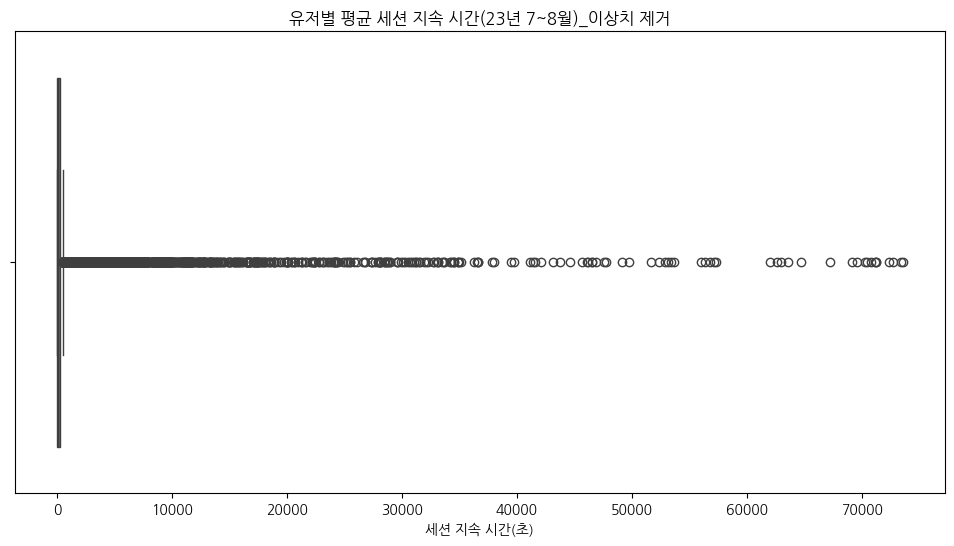

In [155]:
plt.figure(figsize=(12,6))
sns.boxplot(data=avg_duration_df, x='avg_duration_sec')
plt.title('유저별 평균 세션 지속 시간(23년 7~8월)_이상치 제거')
plt.xlabel('세션 지속 시간(초)')
plt.show()

In [127]:
# # 시각화
# plt.figure(figsize=(12,6))
# sns.histplot(data=avg_duration_df[avg_duration_df['avg_duration_sec'] < 60000], # 16시간 
#              x='avg_duration_sec')
# plt.title('유저별 평균 세션 지속 시간 (16시간 미만)_이상치 제거')
# plt.xlabel('세션 지속 시간(초)')
# plt.show()

### 유저별 세션 쌍 개수 집계

In [8]:
#  유저별 세션 개수 구하기
session_counts_df = cleaned_df.groupby('user_id').size().reset_index(name='session_count')
show_df_info(session_counts_df,'session_counts_df')


session_counts_df 형태:


(116812, 2)


session_counts_df 첫 5행:


,user_id,session_count
0,02QVyNBCraNN7i04MPRQVrGbGPR2,1
1,03dEZCajSgbBSj7wPNeXjBp8QnI2,5
2,07JXIRPEnuSSpzQ5cKYrvwrMq3I3,1
3,08g6HjWIPUZttChnM4McJAlbgyl1,1
4,08tcnzqYmaZ81F7s29QPu5PUrP13,1



session_counts_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116812 entries, 0 to 116811
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        116812 non-null  object
 1   session_count  116812 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB

session_counts_df 통계 요약:


,session_count
count,116812.000000
mean,4.157390
std,10.219206
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,283.000000



session_counts_df 통계 요약:


,user_id
count,116812
unique,116812
top,02QVyNBCraNN7i04MPRQVrGbGPR2
freq,1



session_counts_df 결측치 확인:


user_id          0
session_count    0
dtype: int64

In [158]:
# 세션 쌍 개수 최대인 유저 탐색
session_counts_df[session_counts_df['session_count'] == 283]

,user_id,session_count
48113,1253311,283


In [148]:
matched_df[matched_df['user_id'].isin(['1253311'])].sort_values('session_duration_sec', ascending = False) # 최대 6시간 13분

,user_id,start_time,end_time,session_duration_sec,session_flag
391625,1253311,2023-07-20 22:01:36,2023-07-21 04:14:46,22390.0,matched
391670,1253311,2023-07-24 22:37:07,2023-07-25 03:09:04,16317.0,matched
391616,1253311,2023-07-20 00:30:57,2023-07-20 04:24:41,14024.0,matched
391812,1253311,2023-08-04 20:51:49,2023-08-05 00:45:06,13997.0,matched
391647,1253311,2023-07-23 00:03:50,2023-07-23 03:55:34,13904.0,matched
...,...,...,...,...,...
391673,1253311,2023-07-25 13:57:49,2023-07-25 13:57:53,4.0,matched
391747,1253311,2023-07-31 07:26:05,2023-07-31 07:26:09,4.0,matched
391800,1253311,2023-08-03 19:38:01,2023-08-03 19:38:04,3.0,matched
391681,1253311,2023-07-25 21:47:45,2023-07-25 21:47:48,3.0,matched


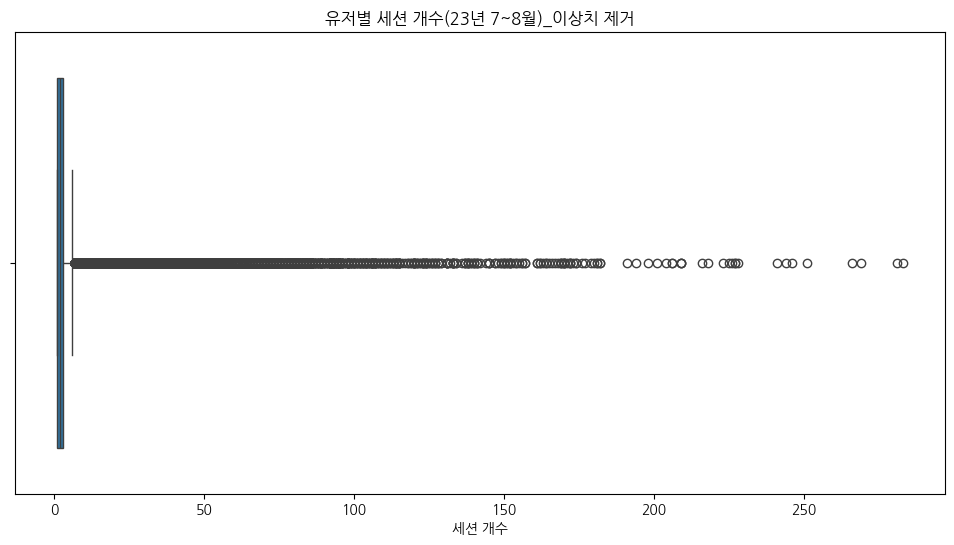

In [160]:
# 박스플롯
plt.figure(figsize=(12,6))
sns.boxplot(data=session_counts_df, x='session_count')
plt.title('유저별 세션 개수(23년 7~8월)_이상치 제거')
plt.xlabel('세션 개수')
plt.show()

In [9]:
# 유저별 평균 세션 지속 시간 + 세션 쌍 개수 merge
session_cnt_duration_df = pd.merge(avg_duration_df, session_counts_df, on = 'user_id', how = 'left')
show_df_info(session_cnt_duration_df,'session_cnt_duration_df')


session_cnt_duration_df 형태:


(116812, 3)


session_cnt_duration_df 첫 5행:


,user_id,avg_duration_sec,session_count
0,02QVyNBCraNN7i04MPRQVrGbGPR2,4.0,1
1,03dEZCajSgbBSj7wPNeXjBp8QnI2,2.2,5
2,07JXIRPEnuSSpzQ5cKYrvwrMq3I3,1.0,1
3,08g6HjWIPUZttChnM4McJAlbgyl1,174.0,1
4,08tcnzqYmaZ81F7s29QPu5PUrP13,4.0,1



session_cnt_duration_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116812 entries, 0 to 116811
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           116812 non-null  object 
 1   avg_duration_sec  116812 non-null  float64
 2   session_count     116812 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.7+ MB

session_cnt_duration_df 통계 요약:


,avg_duration_sec,session_count
count,116812.000000,116812.000000
mean,299.900599,4.157390
std,1625.894811,10.219206
min,1.000000,1.000000
25%,18.000000,1.000000
50%,75.333333,2.000000
75%,231.333333,3.000000
max,73566.000000,283.000000



session_cnt_duration_df 통계 요약:


,user_id
count,116812
unique,116812
top,02QVyNBCraNN7i04MPRQVrGbGPR2
freq,1



session_cnt_duration_df 결측치 확인:


user_id             0
avg_duration_sec    0
session_count       0
dtype: int64

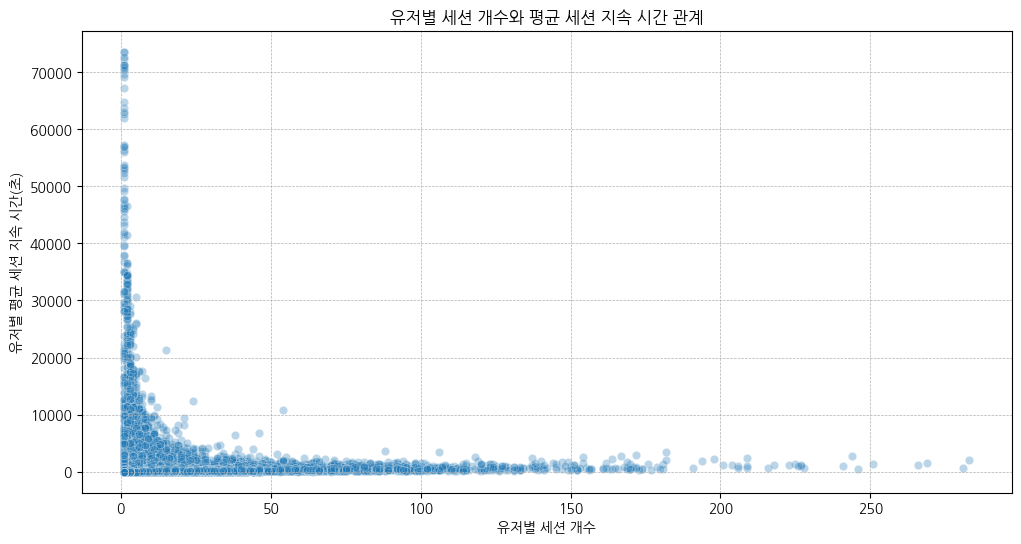

In [162]:
# 유저별 세션 개수와 평균 세션 지속 시간 관계
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=session_cnt_duration_df,
    x='session_count',
    y='avg_duration_sec',
    alpha=0.3
)
plt.xlabel('유저별 세션 개수')
plt.ylabel('유저별 평균 세션 지속 시간(초)')
plt.title('유저별 세션 개수와 평균 세션 지속 시간 관계')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

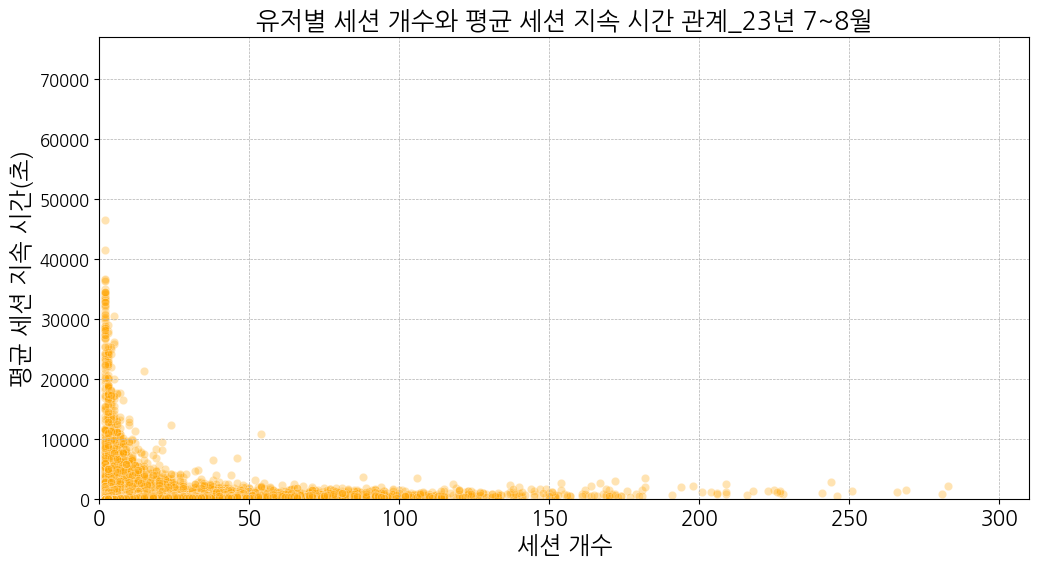

In [13]:
# 세션 개수가 2 이상인 경우만 추출_추가 hackle 스케일 맞춘 버전
filtered_df = session_cnt_duration_df[session_cnt_duration_df['session_count'] >= 2]

# 유저별 세션 개수와 평균 세션 지속 시간 관계
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=filtered_df,
    x='session_count',
    y='avg_duration_sec',
    alpha=0.3,
    color='Orange'
)
plt.title('유저별 세션 개수와 평균 세션 지속 시간 관계_23년 7~8월', fontsize = 18)
plt.xlabel('세션 개수', fontsize = 17)
plt.ylabel('평균 세션 지속 시간(초)', fontsize = 17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 12)
plt.xlim(0,310)
plt.ylim(0,77000)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

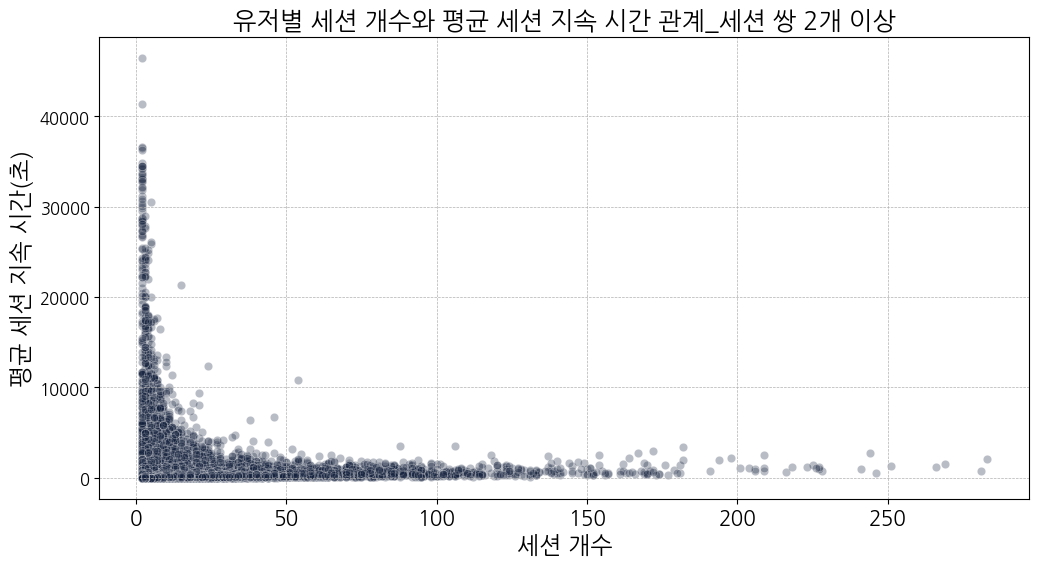

In [ ]:
# 유저별 세션 개수와 평균 세션 지속 시간 관계
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=filtered_df,
    x='session_count',
    y='avg_duration_sec',
    alpha=0.3,
    color='#14213d'
)
plt.xlabel('세션 개수', fontsize = 17)
plt.ylabel('평균 세션 지속 시간(초)', fontsize = 17)
plt.title('유저별 세션 개수와 평균 세션 지속 시간 관계_세션 쌍 2개 이상', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 12)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

In [169]:
show_df_info(filtered_df, 'filtered_df')


filtered_df 형태:


(58520, 3)


filtered_df 첫 5행:


,user_id,avg_duration_sec,session_count
1,03dEZCajSgbBSj7wPNeXjBp8QnI2,2.200000,5
7,0EdWWnQysUhSo2IyRy2PEoCmHfG2,312.142857,7
8,0FjtUACA86Qxiei4xRDuxuw1wco2,466.500000,2
10,0JaxYxyAuNQpxoc5SCkkFvaFcwe2,220.600000,5
11,0L7zluql9iUHjZKdU0xJcF1j1zM2,3.000000,3



filtered_df 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 58520 entries, 1 to 116804
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           58520 non-null  object 
 1   avg_duration_sec  58520 non-null  float64
 2   session_count     58520 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.8+ MB

filtered_df 통계 요약:


,avg_duration_sec,session_count
count,58520.000000,58520.000000
mean,376.140957,7.302478
std,1434.584982,13.734521
min,1.000000,2.000000
25%,51.500000,2.000000
50%,133.333333,3.000000
75%,330.443510,6.000000
max,46499.000000,283.000000



filtered_df 통계 요약:


,user_id
count,58520
unique,58520
top,03dEZCajSgbBSj7wPNeXjBp8QnI2
freq,1



filtered_df 결측치 확인:


user_id             0
avg_duration_sec    0
session_count       0
dtype: int64

In [170]:
# 최대값 탐색
filtered_df[filtered_df['avg_duration_sec'] == 46499.000000]

,user_id,avg_duration_sec,session_count
53267,1284435,46499.0,2


In [171]:
matched_df[matched_df['user_id'] == '1284435']

,user_id,start_time,end_time,session_duration_sec,session_flag
434062,1284435,2023-07-24 14:27:57,2023-07-27 12:58:31,253834.0,matched
434064,1284435,2023-08-01 10:30:18,2023-08-01 17:49:11,26333.0,matched
434066,1284435,2023-08-05 20:34:40,2023-08-06 15:05:45,66665.0,matched


In [174]:
final_hackle_df[final_hackle_df['user_id'] == '1284435'].sort_values('event_datetime')

,event_id,event_datetime,event_key,session_id,friend_count,question_id,heart_balance,id,user_id,device_id,osname,osversion
6567285,f7ccc84a-754e-4624-81a2-7459aabcc067,2023-07-21 10:57:43,$session_start,5I2DqPSXovfHbmYzunRZm8qQFnS2,NaN,NaN,NaN,387694,1284435,fd84fd7e-d0ba-4964-969d-ed872f2a94cd,Android,10
6567281,d91dcef9-da04-42b3-a19d-924d0880137a,2023-07-21 10:57:43,$session_end,5I2DqPSXovfHbmYzunRZm8qQFnS2,NaN,NaN,NaN,387694,1284435,fd84fd7e-d0ba-4964-969d-ed872f2a94cd,Android,10
6567276,b3b6fcf1-2aec-44ba-b956-a557cbdce0ca,2023-07-21 10:57:43,launch_app,5I2DqPSXovfHbmYzunRZm8qQFnS2,NaN,NaN,NaN,387694,1284435,fd84fd7e-d0ba-4964-969d-ed872f2a94cd,Android,10
6567270,7a70fcba-c1e3-40ee-83c5-86a6ede966f6,2023-07-21 10:57:47,$session_start,5I2DqPSXovfHbmYzunRZm8qQFnS2,NaN,NaN,NaN,387694,1284435,fd84fd7e-d0ba-4964-969d-ed872f2a94cd,Android,10
6567264,3e3fbdb4-eba0-47a9-b817-087adf74a25f,2023-07-21 10:57:55,click_bottom_navigation_questions,5I2DqPSXovfHbmYzunRZm8qQFnS2,35.0,NaN,661.0,387694,1284435,fd84fd7e-d0ba-4964-969d-ed872f2a94cd,Android,10
6567256,02426b52-7255-45c5-9c49-c487ca1109ca,2023-07-24 09:47:52,$session_end,5I2DqPSXovfHbmYzunRZm8qQFnS2,35.0,NaN,661.0,387694,1284435,fd84fd7e-d0ba-4964-969d-ed872f2a94cd,Android,10
6567258,0789d60e-03ba-4048-adc5-d6a8486587ae,2023-07-24 09:47:52,launch_app,5I2DqPSXovfHbmYzunRZm8qQFnS2,35.0,NaN,661.0,387694,1284435,fd84fd7e-d0ba-4964-969d-ed872f2a94cd,Android,10
6567267,520b2fe4-13fa-43df-9ca0-4c9a5d383844,2023-07-24 09:47:52,$session_start,5I2DqPSXovfHbmYzunRZm8qQFnS2,35.0,NaN,661.0,387694,1284435,fd84fd7e-d0ba-4964-969d-ed872f2a94cd,Android,10
6567279,c1845835-8c39-49cc-ab05-13342f2c29f7,2023-07-24 14:27:57,$session_start,5I2DqPSXovfHbmYzunRZm8qQFnS2,35.0,NaN,661.0,387694,1284435,fd84fd7e-d0ba-4964-969d-ed872f2a94cd,Android,10
6567269,727ea177-d643-46ed-8f6f-1beeea37d646,2023-07-24 14:27:57,launch_app,5I2DqPSXovfHbmYzunRZm8qQFnS2,35.0,NaN,661.0,387694,1284435,fd84fd7e-d0ba-4964-969d-ed872f2a94cd,Android,10


# 가설 확인
- 유저별 세션 쌍 개수 & 평균 세션 지속 시간에 따라 세그먼트 분류 -> 각 세그먼트 별 주 활동 시간대에는 차이가 있을 것이다.
- 주 활동 시간대 == session_start의 시간대?
- 주 활동 시간대 == session_start의 시간대의 최빈값?
- 주 활동 시간대 == start_time, end_time의 시간대 모두 ?

In [38]:
show_df_info(session_cnt_duration_df,'session_cnt_duration_df')


session_cnt_duration_df 형태:


(116812, 3)


session_cnt_duration_df 첫 5행:


,user_id,avg_duration_sec,session_count
0,02QVyNBCraNN7i04MPRQVrGbGPR2,4.0,1
1,03dEZCajSgbBSj7wPNeXjBp8QnI2,2.2,5
2,07JXIRPEnuSSpzQ5cKYrvwrMq3I3,1.0,1
3,08g6HjWIPUZttChnM4McJAlbgyl1,174.0,1
4,08tcnzqYmaZ81F7s29QPu5PUrP13,4.0,1



session_cnt_duration_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116812 entries, 0 to 116811
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           116812 non-null  object 
 1   avg_duration_sec  116812 non-null  float64
 2   session_count     116812 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.7+ MB

session_cnt_duration_df 통계 요약:


,avg_duration_sec,session_count
count,116812.000000,116812.000000
mean,299.900599,4.157390
std,1625.894811,10.219206
min,1.000000,1.000000
25%,18.000000,1.000000
50%,75.333333,2.000000
75%,231.333333,3.000000
max,73566.000000,283.000000



session_cnt_duration_df 통계 요약:


,user_id
count,116812
unique,116812
top,02QVyNBCraNN7i04MPRQVrGbGPR2
freq,1



session_cnt_duration_df 결측치 확인:


user_id             0
avg_duration_sec    0
session_count       0
dtype: int64

## 클러스터 분석

### EDA for 클러스터 분석

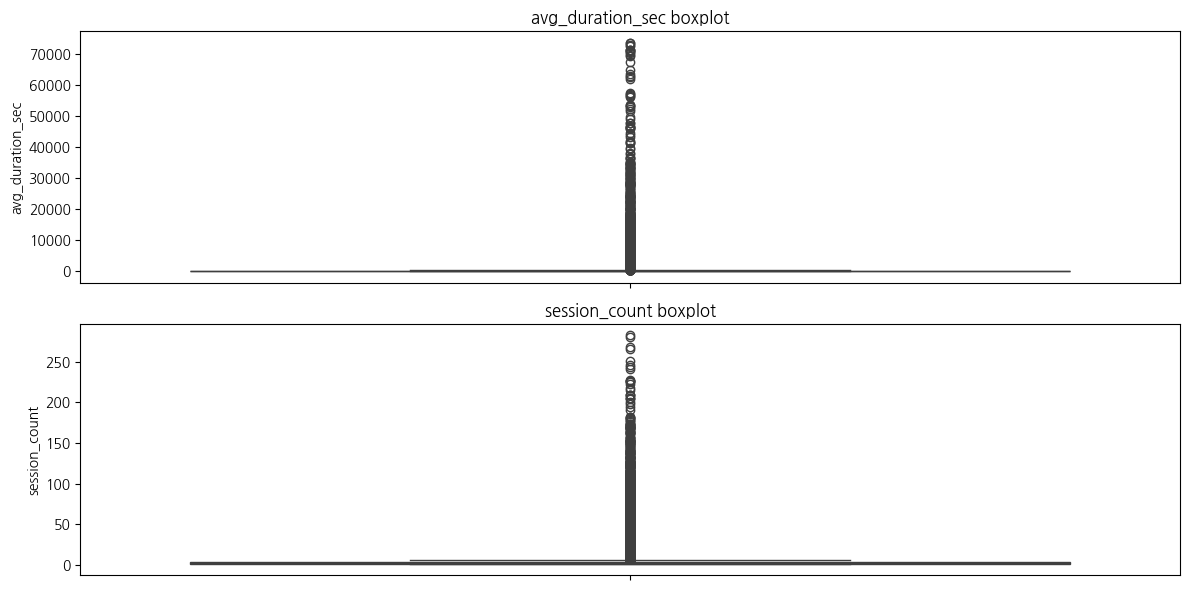

In [26]:
# 이상치 확인
fig, axes = plt.subplots(2,1, figsize = (12,6))

i = 0
for col in session_cnt_duration_df.columns[1:]:
    sns.boxplot(session_cnt_duration_df[col], ax = axes.flat[i])
    axes.flat[i].set_title(f'{col} boxplot')
    i += 1

fig.tight_layout()
plt.show()

In [33]:
# 이상치 확인 함수 
def outliers_idx(df, col):
    q3 = df[col].quantile(0.75)
    q1 = df[col].quantile(0.25)
    
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    outlier_check = (df[col] < lower) | (df[col] > upper)
    return outlier_check

# 컬럼별 이상치가 전체 데이터에서 차지하는 비율 확인
original_size = session_cnt_duration_df.shape[0]
outlier_list = []

for col in session_cnt_duration_df.columns[1:]:
    outlier_mask = outliers_idx(session_cnt_duration_df, col)
    outlier_cnt = outlier_mask.sum() # 이상치 개수
    ratio = outlier_cnt / original_size * 100 # 이상치 비율

    outlier_list.append(
        {'name' : col,
        'cnt' : outlier_cnt,
        'ratio' : ratio.round(2)}
    )

outlier_df = pd.DataFrame(outlier_list)  # 데이터프레임으로 변환
display(outlier_df.sort_values(by = 'ratio', ascending = False))
outlier_df['ratio'].describe()

,name,cnt,ratio
1,session_count,13909,11.91
0,avg_duration_sec,12115,10.37


count     2.000000
mean     11.140000
std       1.088944
min      10.370000
25%      10.755000
50%      11.140000
75%      11.525000
max      11.910000
Name: ratio, dtype: float64

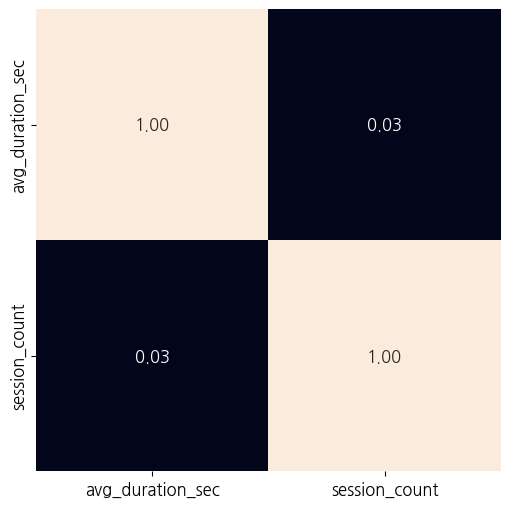

In [32]:
# 상관관계 확인
plt.figure(figsize = (6,6))
sns.heatmap(session_cnt_duration_df.drop(columns = 'user_id').corr(), annot = True, annot_kws = {'size': 12},fmt = '.2f', cbar = False)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

### 스케일러 적용

In [10]:
# 각 변수에서 이상치 비율이 높음 => Robust Scaler
# 변수 간 스케일 차이 큼 => Standard Scaler

data = session_cnt_duration_df.drop(columns = 'user_id')
#numeric_cols = data.columns[(data.dtypes == 'int64') | (data.dtypes == 'float64')].to_list()

rs = RobustScaler()
ss = StandardScaler()

# RobustScaler 적용
rs_scaled_df = pd.DataFrame(rs.fit_transform(data), columns = data.columns)
display(rs_scaled_df.head())

# StandardScaler 적용
ss_scaled_df =  pd.DataFrame(ss.fit_transform(data), columns = data.columns)
display(ss_scaled_df.head())

,avg_duration_sec,session_count
0,-0.334375,-0.5
1,-0.342812,1.5
2,-0.348437,-0.5
3,0.462500,-0.5
4,-0.334375,-0.5


,avg_duration_sec,session_count
0,-0.181993,-0.308968
1,-0.183100,0.082454
2,-0.183838,-0.308968
3,-0.077435,-0.308968
4,-0.181993,-0.308968


### 로그변환 + 스케일러 적용

In [11]:
# 로그 변환
log_transformed_df = np.log1p(session_cnt_duration_df[['session_count', 'avg_duration_sec']])

# Robust Scaler 적용
rs = RobustScaler()
rs_scaled_log_df = pd.DataFrame(rs.fit_transform(log_transformed_df), columns=log_transformed_df.columns)
display(rs_scaled_log_df.head())

# StandardScaler 적용
ss = StandardScaler()
ss_scaled_log_df =  pd.DataFrame(ss.fit_transform(log_transformed_df), columns = log_transformed_df.columns)
display(ss_scaled_log_df.head())

,session_count,avg_duration_sec
0,-0.584963,-1.088643
1,1.000000,-1.266891
2,-0.584963,-1.454612
3,-0.584963,0.331376
4,-0.584963,-1.088643


,session_count,avg_duration_sec
0,-0.684210,-1.413439
1,0.825645,-1.660875
2,-0.684210,-1.921461
3,-0.684210,0.557763
4,-0.684210,-1.413439


### KMEANS
- PCA는 적용 x (변수 2개로 간단함/ 의미가 겹치지도 않음)

In [13]:
# 경고메시지 처리
os.environ['OMP_NUM_THREADS'] = '1'

In [14]:
# 엘보우 기법, 실루엣 점수로 적절한 군집 수 찾기
def elbow_silouette(df, max_range, title_el, title_sil):
    
    # 클러스터링 및 inertias, 실루엣 점수 계산 
    inertias = []
    sil_scores = []
    
    for k in range(1,max_range+1):
        km = KMeans(n_clusters = k, random_state = 42)
        km.fit(df)
        inertias.append(km.inertia_) # inertias에 저장

        if k >= 2: # 실루엣 점수는 k >=2 일 때 가능
            labels = km.predict(df)
            score = silhouette_score(df, labels, sample_size=5000, random_state = 42)
            sil_scores.append(score) # silhouette_scores에 저장
        
    # 엘보우 기법 - k값에 따른 inertia값 시각화
    fig, ax = plt.subplots(1,2, figsize = (10,5))
    
    sns.lineplot(x = range(1, max_range+1), y = inertias, marker='o', ax = ax[0])
    ax[0].set_title(title_el)
    ax[0].set_xlabel('n-clusters')
    ax[0].set_ylabel('inertia')
    ax[0].grid()
    
    # k값에 따른 실루엣 점수 시각화
    sns.lineplot(x = range(2, max_range+1), y = sil_scores, marker = 'o', ax = ax[1])
    ax[1].set_title(title_sil)
    ax[1].set_xlabel('n_clusters')
    ax[1].set_ylabel('Silhouette Score')
    ax[1].grid()

    plt.tight_layout()
    plt.show()

    return df, inertias, sil_scores


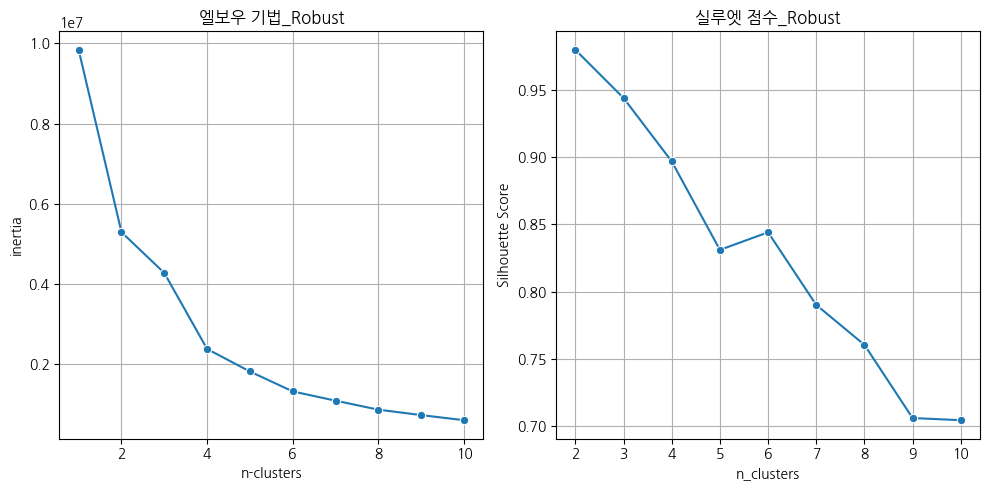

,avg_duration_sec,session_count
0,-0.334375,-0.5
1,-0.342812,1.5
2,-0.348437,-0.5
3,0.462500,-0.5
4,-0.334375,-0.5
...,...,...
116807,0.710938,-0.5
116808,-0.348437,-0.5
116809,-0.343750,-0.5
116810,-0.343750,-0.5


[9834727.800306479, 5295516.889189073, 4278435.260866721, 2384681.1038251165, 1823992.8544536326, 1327725.6862337529, 1097177.0420011128, 873272.2968798628, 738252.8445619792, 610753.1858159415]
[0.9797680273071172, 0.9439570880883422, 0.8968254014550967, 0.8310771798417927, 0.8441569255732269, 0.7901669426341035, 0.7604910667687554, 0.7060504060190584, 0.7044418315075988]


In [15]:
# robust 적용 버전
rs_scaled_df_test, inertias, sil_scores = elbow_silouette(rs_scaled_df, 10, '엘보우 기법_Robust', '실루엣 점수_Robust')
display(rs_scaled_df_test)
print(inertias)
print(sil_scores)

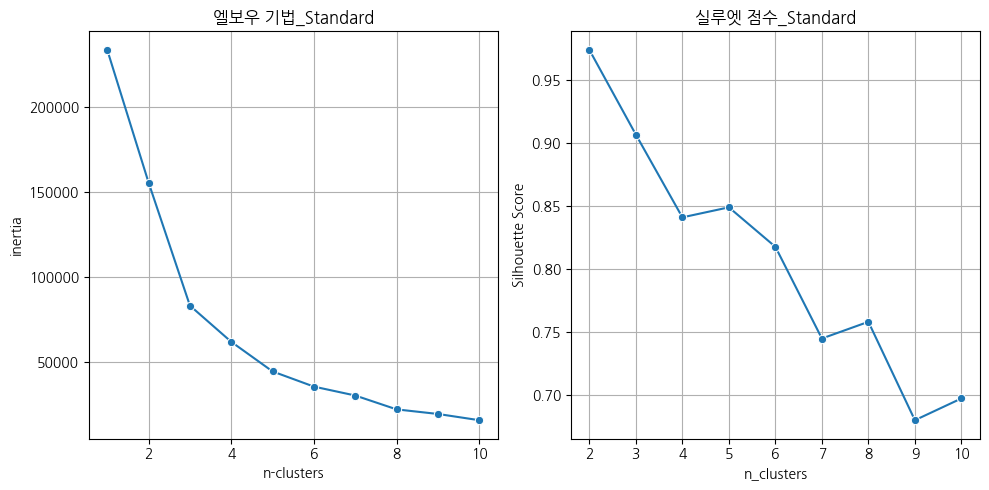

,avg_duration_sec,session_count
0,-0.181993,-0.308968
1,-0.183100,0.082454
2,-0.183838,-0.308968
3,-0.077435,-0.308968
4,-0.181993,-0.308968
...,...,...
116807,-0.044837,-0.308968
116808,-0.183838,-0.308968
116809,-0.183223,-0.308968
116810,-0.183223,-0.308968


[233623.9999999862, 155472.0111956268, 83013.26797377861, 61700.24550105806, 44254.60914625593, 35318.28114787028, 30076.841963899657, 21907.918212071527, 19209.251450654825, 15536.57665112536]
[0.9738584190150088, 0.906576576650023, 0.8408956380821637, 0.8488578190075439, 0.817515271318164, 0.7447184492791199, 0.7579673746912897, 0.6798468179936974, 0.6971332975971263]


In [16]:
# standard 적용 버전
ss_scaled_df_test, inertias, sil_scores = elbow_silouette(ss_scaled_df, 10, '엘보우 기법_Standard', '실루엣 점수_Standard')
display(ss_scaled_df_test)
print(inertias)
print(sil_scores)

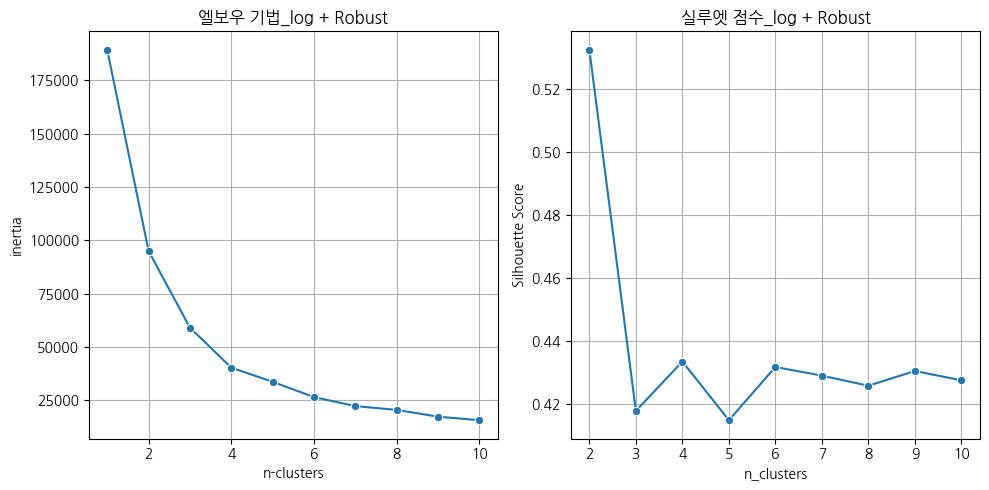

,session_count,avg_duration_sec
0,-0.584963,-1.088643
1,1.000000,-1.266891
2,-0.584963,-1.454612
3,-0.584963,0.331376
4,-0.584963,-1.088643
...,...,...
116807,-0.584963,0.437042
116808,-0.584963,-1.454612
116809,-0.584963,-1.292668
116810,-0.584963,-1.292668


[189342.29950499904, 94958.24980902098, 59011.667568728175, 40265.88005216252, 33581.28052800578, 26430.08965549073, 22185.8423018108, 20417.784741851792, 17237.6300197728, 15570.924967514316]
[0.5324666067563717, 0.4177725933313544, 0.43347185927026055, 0.41482653847571094, 0.43173602075075723, 0.4289875661789656, 0.42578205362363014, 0.430455480987903, 0.4275082348958085]


In [18]:
# 로그 변환 + robust 적용 버전
rs_scaled_log_df_test, inertias, sil_scores = elbow_silouette(rs_scaled_log_df, 10, '엘보우 기법_log + Robust', '실루엣 점수_log + Robust')
display(rs_scaled_log_df_test)
print(inertias)
print(sil_scores)

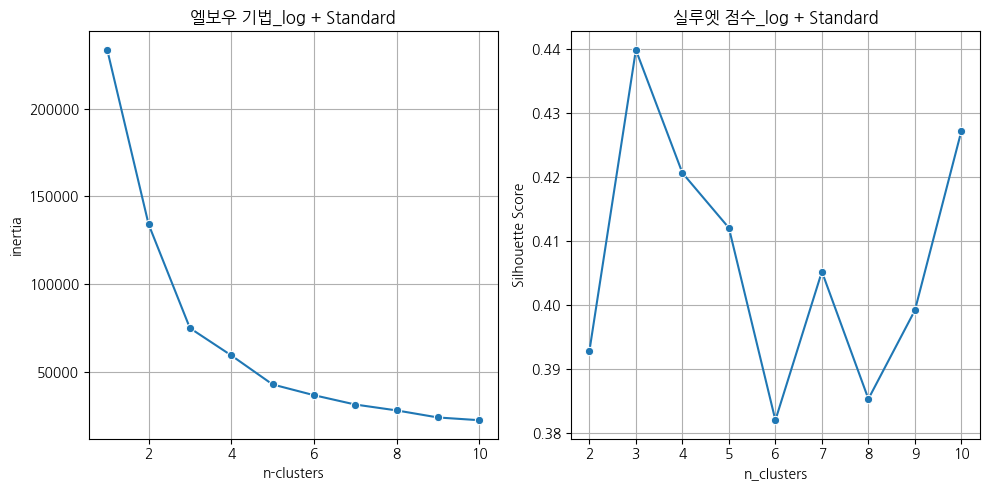

,session_count,avg_duration_sec
0,-0.684210,-1.413439
1,0.825645,-1.660875
2,-0.684210,-1.921461
3,-0.684210,0.557763
4,-0.684210,-1.413439
...,...,...
116807,-0.684210,0.704444
116808,-0.684210,-1.921461
116809,-0.684210,-1.696658
116810,-0.684210,-1.696658


[233624.0000000106, 134128.32300004756, 74883.42443243344, 59310.045307407134, 42737.7829358968, 36608.092546963744, 31271.73370802588, 27919.795211647346, 23893.06496071856, 22331.40959655031]
[0.39280403578133066, 0.43984327126804457, 0.42063012523275595, 0.41204785175616415, 0.38201492786264535, 0.4052167597596361, 0.3853376789563592, 0.39917590291044847, 0.42719513231651207]


In [19]:
# 로그 변환 + standard 적용 버전
ss_scaled_log_df_test, inertias, sil_scores = elbow_silouette(ss_scaled_log_df, 10, '엘보우 기법_log + Standard', '실루엣 점수_log + Standard')
display(ss_scaled_log_df_test)
print(inertias)
print(sil_scores)

- 로그 변환 + 스케일링 적용 한 경우에는, 로그 변환 적용하지 않은 경우보다 실루엣 점수가 확 낮아짐!
- 로그 변환 적용 안한 경우 중, Robust 스케일링이 Standard 스케일링보다 실루엣 점수가 높음
- 가장 점수 높은 건 K = 2일 때지만, 그럼 클러스터가 너무 적어서 적합하지 않다고 판단
- 그 다음으로 높은 점수인 k = 3 우선 적용 -> k=4까지도 시도해볼만함

In [24]:
# KMeans (k = 3)
kmeans = KMeans(n_clusters=2, random_state=42)
# robust 버전
kmeans.fit(rs_scaled_df)
predict = kmeans.predict(rs_scaled_df)
session_cnt_duration_df['cluster'] = predict


# 확인
display(session_cnt_duration_df)


,user_id,avg_duration_sec,session_count,cluster
0,02QVyNBCraNN7i04MPRQVrGbGPR2,4.0,1,0
1,03dEZCajSgbBSj7wPNeXjBp8QnI2,2.2,5,0
2,07JXIRPEnuSSpzQ5cKYrvwrMq3I3,1.0,1,0
3,08g6HjWIPUZttChnM4McJAlbgyl1,174.0,1,0
4,08tcnzqYmaZ81F7s29QPu5PUrP13,4.0,1,0
...,...,...,...,...
116807,zkGvpRUY1sRXZXNW3QfF8b9M6U93,227.0,1,0
116808,zlRu2eL7juSaImYcPIQiN0U4RSg2,1.0,1,0
116809,zpax5JqWpSW5WNHCMbediX7KfxZ2,2.0,1,0
116810,zrbn6Jt89dPg02zWzvUkpvYAoDD3,2.0,1,0


,count
cluster,
0,116601
1,211


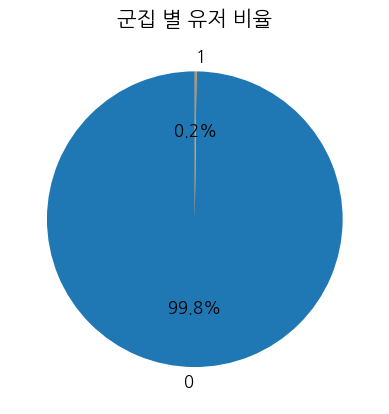

In [25]:
# 각 클러스터별 고객 분포
cluster_df = session_cnt_duration_df['cluster'].value_counts().to_frame()
display(cluster_df)

# 시각화
plt.pie(data = cluster_df, labels = cluster_df.index, x = 'count', autopct='%1.1f%%', startangle = 90, textprops = {'size': 12})
plt.title('군집 별 유저 비율', fontsize = 15)
plt.show()

- k = 2 ~ 4 모두 클러스터 0에 심각하게 많음 // 불균형! 클러스터가 잘 나누어지지 않음
- KMeans는 적합하지 않음
- GMM 시도해보기

### GMM

In [41]:
# AIC, BIC 점수 계산해서 k값 찾기

def gmm_aic_bic_plot(rs_df, ss_df, max_k):
    # AIC, BIC 값 저장 리스트
    results = {
        'Robust' : {'aic': [], 'bic' : []},
        'Standard' : {'aic': [], 'bic' : []}
    }


    for k in range(1,max_k + 1):
        # robust 적용한 경우
        gmm_rs = GaussianMixture(n_components = k, random_state = 24)
        gmm_rs.fit(rs_df)
        results['Robust']['aic'].append(gmm_rs.aic(rs_df))
        results['Robust']['bic'].append(gmm_rs.bic(rs_df))
        
        # standard 적용한 경우
        gmm_ss= GaussianMixture(n_components = k, random_state = 24)
        gmm_ss.fit(ss_df)
        results['Standard']['aic'].append(gmm_ss.aic(ss_df))
        results['Standard']['bic'].append(gmm_ss.bic(ss_df))


    # 시각화
    fig, axes = plt.subplots(1,2,figsize = (12,6))
    scaler_titles = ['Robust','Standard']

    for i, scaler in enumerate(scaler_titles):
        ax = axes[i]
        sns.lineplot(x = range(1,max_k + 1), y = results[scaler]["aic"], label="AIC", marker='o', ax=ax)
        sns.lineplot(x = range(1,max_k + 1), y = results[scaler]["bic"], label="BIC", marker='o', ax=ax)
        ax.set_title(f'{scaler} 스케일러')
        ax.set_xlabel('군집 개수')
        ax.set_ylabel('점수')
        ax.grid()

    fig.suptitle('GMM AIC & BIC 점수 비교')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results

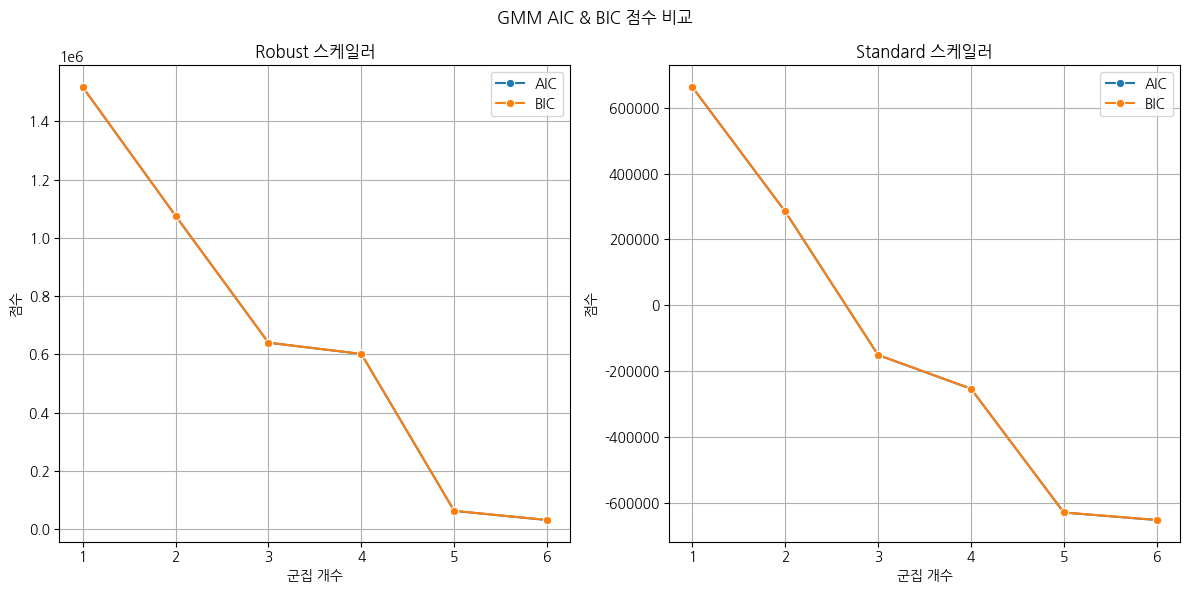

In [53]:
# 로그 변환 적용 안한 버전
results_nolog = gmm_aic_bic_plot(rs_scaled_df, ss_scaled_df, max_k=6)

In [37]:
results_nolog

{'Robust': {'aic': [1518426.2848790367,
   1076398.2806312,
   640502.961795312,
   601768.0567728565,
   62838.263561442676,
   31425.52583056958],
  'bic': [1518474.6264844558,
   1076504.632163122,
   640667.3232537371,
   601990.4281577845,
   63118.6448728736,
   31763.91706850345]},
 'Standard': {'aic': [662878.6329199733,
   284720.8562136957,
   -151259.98635102808,
   -253839.81340382365,
   -629950.9629660194,
   -652845.5222858051],
  'bic': [662926.9745253925,
   284827.2077456178,
   -151095.62489260305,
   -253617.44201889567,
   -629670.5816545885,
   -652507.1310478712]}}

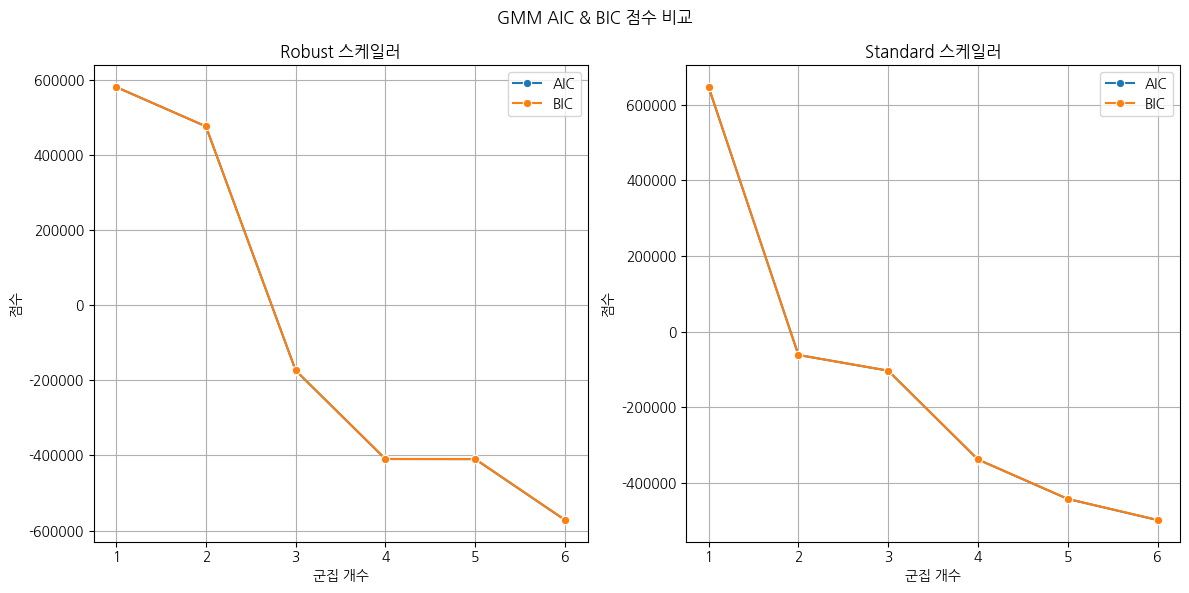

In [38]:
# 로그 변환 적용한 버전
results_log = gmm_aic_bic_plot(rs_scaled_log_df, ss_scaled_log_df, max_k=6)

In [39]:
results_log

{'Robust': {'aic': [581531.6688576853,
   476641.2169599813,
   -173796.28902986305,
   -409575.0154912306,
   -409851.8748289682,
   -572164.9637467678],
  'bic': [581580.0104631045,
   476747.56849190337,
   -173631.92757143802,
   -409352.64410630264,
   -409571.49351753725,
   -571826.572508834]},
 'Standard': {'aic': [646812.4031688896,
   -61237.948444409325,
   -102828.65002072083,
   -337484.08298571245,
   -441697.90843468567,
   -497447.003951407],
  'bic': [646860.7447743088,
   -61131.59691248725,
   -102664.28856229581,
   -337261.7116007845,
   -441417.5271232547,
   -497108.6127134731]}}

- aic, bic는 작을 수록 좋음! -> 로그 변환 한게 더 좋다
- 로그 변환 한 것 중에는 Robust 스케일러 적용한 게 더 작은 숫자 
- 로그 변환 & Robust 스케일러 적용하여 GMM 시행
- k = 3 or 4 정도가 좋을 것이라 예상
- 우선 k = 3 ~ 6까지 테스트

In [57]:
# k = 3~6까지 군집별 비율, 시각화, 통계 등 확인 
def plot_gmm_cluster_summary(scaled_df, k_range, original_df):
    """
    GMM 클러스터링을 여러 k값에 대해 수행하고,
    각 클러스터의 비율, 평균, 통계 요약(describe), 시각화를 출력함.

    Parameters:
    - scaled_df: 스케일링된 입력 데이터
    - k_range: range(3, 7)처럼 클러스터 개수 범위
    - original_df: 원본 데이터프레임 (해석을 위해 사용)
    """

    for k in k_range:
        print(f"\n====================  k = {k}  ====================\n")
        gmm = GaussianMixture(n_components=k, random_state=24)
        clusters = gmm.fit_predict(scaled_df)

        # 군집 분포
        cluster_counts = pd.Series(clusters).value_counts().sort_index()
        cluster_ratio = (cluster_counts / cluster_counts.sum() * 100).round(2)

        print("📌 군집별 개수:")
        print(cluster_counts)
        print("\n📌 군집별 비율 (%):")
        print(cluster_ratio)

        # 시각화
        plt.figure(figsize=(6, 4))
        sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
        plt.title(f'Cluster Size Distribution (k={k})')
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.grid(True)
        plt.show()

        # 군집별 평균 + describe
        temp_df = original_df.copy()
        temp_df['cluster'] = clusters

        # print("\n📌 군집별 평균값:")
        # display(temp_df.groupby('cluster').mean().round(2))

        print("📌 군집별 통계 요약:")
        display(temp_df.groupby('cluster').describe().round(2))



====================  k = 3  ====================



📌 군집별 개수:
0    58292
1    38557
2    19963
Name: count, dtype: int64

📌 군집별 비율 (%):
0    49.90
1    33.01
2    17.09
Name: count, dtype: float64


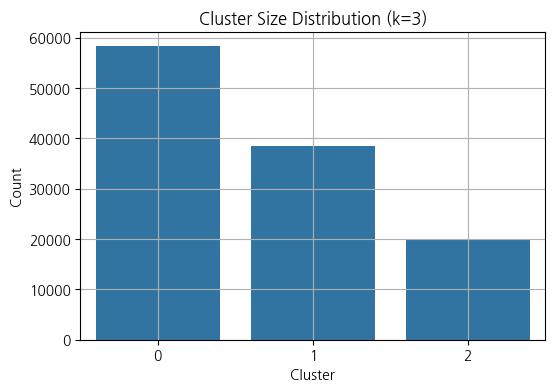

📌 군집별 통계 요약:


avg_duration_sec                                              \
                   count    mean      std  min   25%     50%     75%   
cluster                                                                
0                58292.0  223.36  1794.35  1.0   7.0   32.00  123.00   
1                38557.0  356.98  1638.92  1.0  39.5  101.67  276.00   
2                19963.0  413.15   918.17  1.0  93.4  204.00  400.15   

                  session_count                                            
              max         count   mean    std  min  25%  50%   75%    max  
cluster                                                                    
0        73566.00       58292.0   1.00   0.00  1.0  1.0  1.0   1.0    1.0  
1        46499.00       38557.0   2.57   0.74  2.0  2.0  2.0   3.0    5.0  
2        21301.33       19963.0  16.44  20.62  5.0  6.0  9.0  18.0  283.0


====================  k = 4  ====================

📌 군집별 개수:
0    24516
1    22340
2    11664
3    58292
Name: count, dtype: int64

📌 군집별 비율 (%):
0    20.99
1    19.12
2     9.99
3    49.90
Name: count, dtype: float64


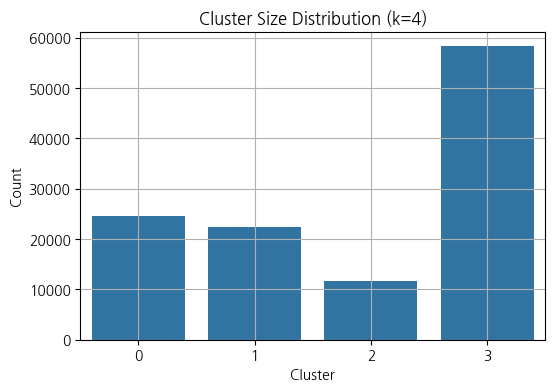

📌 군집별 통계 요약:


avg_duration_sec                                                \
                   count    mean      std  min     25%     50%     75%   
cluster                                                                  
0                24516.0  424.58  1481.62  1.0   60.00  144.33  351.52   
1                22340.0  316.47  1653.03  1.0   32.00   85.50  234.50   
2                11664.0  388.62   682.83  1.1  105.47  222.91  408.65   
3                58292.0  223.36  1794.35  1.0    7.00   32.00  123.00   

                  session_count                                              
              max         count   mean    std  min   25%   50%   75%    max  
cluster                                                                      
0        30533.40       24516.0   4.22   1.37  3.0   3.0   4.0   5.0   11.0  
1        46499.00       22340.0   2.00   0.00  2.0   2.0   2.0   2.0    2.0  
2        21301.33       11664.0  23.94  24.33  8.0  10.0  15.0  27.0  283.0  
3        73566.00       58292.0   1.00   0.00  1.0   1.0   1.0   1.0    1.0


====================  k = 5  ====================

📌 군집별 개수:
0    22340
1    24585
2    11595
3    58292
Name: count, dtype: int64

📌 군집별 비율 (%):
0    19.12
1    21.05
2     9.93
3    49.90
Name: count, dtype: float64


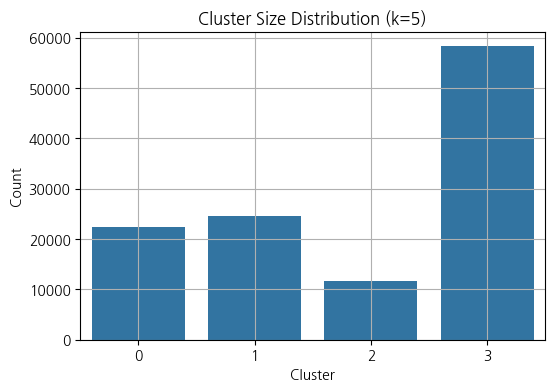

📌 군집별 통계 요약:


avg_duration_sec                                                \
                   count    mean      std  min     25%     50%     75%   
cluster                                                                  
0                22340.0  316.47  1653.03  1.0   32.00   85.50  234.50   
1                24585.0  425.14  1480.24  1.0   60.00  144.75  354.50   
2                11595.0  387.22   681.57  1.1  105.13  222.00  405.24   
3                58292.0  223.36  1794.35  1.0    7.00   32.00  123.00   

                  session_count                                              
              max         count   mean    std  min   25%   50%   75%    max  
cluster                                                                      
0        46499.00       22340.0   2.00   0.00  2.0   2.0   2.0   2.0    2.0  
1        30533.40       24585.0   4.23   1.39  3.0   3.0   4.0   5.0   11.0  
2        21301.33       11595.0  24.03  24.37  8.0  10.0  15.0  27.0  283.0  
3        73566.00       58292.0   1.00   0.00  1.0   1.0   1.0   1.0    1.0


====================  k = 6  ====================

📌 군집별 개수:
0     5767
1    11691
2     8341
3    22340
4    58292
5    10381
Name: count, dtype: int64

📌 군집별 비율 (%):
0     4.94
1    10.01
2     7.14
3    19.12
4    49.90
5     8.89
Name: count, dtype: float64


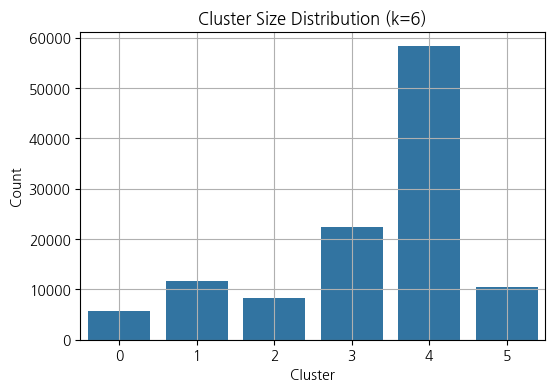

📌 군집별 통계 요약:


avg_duration_sec                                                 \
                   count    mean      std   min     25%     50%     75%   
cluster                                                                   
0                 5767.0  395.37  1374.07  1.00   62.00  147.25  358.50   
1                11691.0  462.26  1318.14  1.00   82.00  180.12  375.17   
2                 8341.0  404.36   631.77  1.86  113.96  238.05  439.47   
3                22340.0  316.47  1653.03  1.00   32.00   85.50  234.50   
4                58292.0  223.36  1794.35  1.00    7.00   32.00  123.00   
5                10381.0  374.21  1542.29  1.00   48.00  117.00  304.00   

                  session_count                                               
              max         count   mean    std   min   25%   50%   75%    max  
cluster                                                                       
0        25255.75        5767.0   4.00   0.00   4.0   4.0   4.0   4.0    4.0  
1        30533.40       11691.0   6.78   1.69   5.0   5.0   6.0   8.0   15.0  
2        12359.00        8341.0  29.88  26.52  11.0  14.0  21.0  35.0  283.0  
3        46499.00       22340.0   2.00   0.00   2.0   2.0   2.0   2.0    2.0  
4        73566.00       58292.0   1.00   0.00   1.0   1.0   1.0   1.0    1.0  
5        28987.33       10381.0   3.00   0.00   3.0   3.0   3.0   3.0    3.0

In [58]:
plot_gmm_cluster_summary(rs_scaled_log_df, range(3, 7), session_cnt_duration_df)


- k = 3은 session_count에서 1, 2~5, 5~283 으로 구간이 너무 큼
- k = 5,6은 의미없이 너무 나뉘어지는 느낌! (게다가 k = 5는 제대로 5개로 나누어지지도 않음)
- 따라서, k = 4 채택

,user_id,avg_duration_sec,session_count,gmm_4_label
0,02QVyNBCraNN7i04MPRQVrGbGPR2,4.0,1,0
1,03dEZCajSgbBSj7wPNeXjBp8QnI2,2.2,5,1
2,07JXIRPEnuSSpzQ5cKYrvwrMq3I3,1.0,1,0
3,08g6HjWIPUZttChnM4McJAlbgyl1,174.0,1,0
4,08tcnzqYmaZ81F7s29QPu5PUrP13,4.0,1,0
...,...,...,...,...
116807,zkGvpRUY1sRXZXNW3QfF8b9M6U93,227.0,1,0
116808,zlRu2eL7juSaImYcPIQiN0U4RSg2,1.0,1,0
116809,zpax5JqWpSW5WNHCMbediX7KfxZ2,2.0,1,0
116810,zrbn6Jt89dPg02zWzvUkpvYAoDD3,2.0,1,0


,count
gmm_4_label,
0,58292
1,24517
2,22340
3,11663


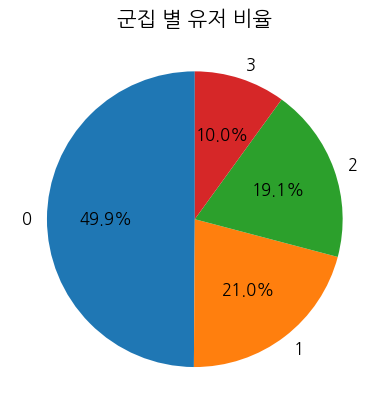

In [12]:
# 군집 4개 
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(rs_scaled_log_df)
session_cnt_duration_df['gmm_4_label'] = gmm_labels

# 확인
display(session_cnt_duration_df)

# 각 클러스터별 고객 분포
gmm_4_cluster_df = session_cnt_duration_df['gmm_4_label'].value_counts().to_frame()
display(gmm_4_cluster_df)

# 시각화
plt.pie(data = gmm_4_cluster_df, labels = gmm_4_cluster_df.index, x = 'count', autopct='%1.1f%%', startangle = 90, textprops = {'size': 12})
plt.title('군집 별 유저 비율', fontsize = 15)
plt.show()

In [13]:
session_cnt_duration_df.drop(columns = 'user_id').groupby('gmm_4_label').mean().round(2)

,avg_duration_sec,session_count
gmm_4_label,,
0,223.36,1.00
1,424.58,4.22
2,316.47,2.00
3,388.60,23.94


- 🎈 클러스터 0 (49.9%) : 이탈 유저
    - 평균 체류 시간 : 223초 (3분 43초)
    - 평균 세션 쌍 개수 : 1개
    -> 1번만 사용하고 떠난 유저

- 🌱 클러스터 1 (21%) : 잠재 핵심 유저
    - 평균 체류 시간 : 425초 (7분 5초)
    - 평균 세션 쌍 개수 : 4개
    -> 체류 시간 길고, 재방문도 있음

- ⚠️ 클러스터 2 (19.1%) :단발성 사용 유저
    - 평균 체류 시간 : 316초 (5분 16초)
    - 평균 세션 쌍 개수 : 2개
    -> 한두번 정도만 사용하고 안옴

- 👑 클러스터 3 (10%) : 핵심 충성 유저
    - 평균 체류 시간 : 389초 (6분 29초)
    - 평균 세션 쌍 개수 : 24개
    -> 압도적 재방문 횟수, 충성 고객 

---
클러스터 0, 2: 이탈 가능성 높음 → 온보딩/리텐션 개선 대상     
클러스터 1: 전환 여지 있음 → 충성 고객으로 육성 타겟     
클러스터 3: 핵심 유저 → 우대 혜택 및 추천 유도 대상


## 가설 검정

In [78]:
session_cnt_duration_df['user_id'].nunique(), session_cnt_duration_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116812 entries, 0 to 116811
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           116812 non-null  object 
 1   avg_duration_sec  116812 non-null  float64
 2   session_count     116812 non-null  int64  
 3   gmm_4_label       116812 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 3.6+ MB


(116812, None)

In [44]:
cleaned_df['user_id'].nunique(), cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 485633 entries, 4 to 1023818
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   user_id               485633 non-null  object        
 1   start_time            485633 non-null  datetime64[ns]
 2   end_time              485633 non-null  datetime64[ns]
 3   session_duration_sec  485633 non-null  float64       
 4   session_flag          485633 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 22.2+ MB


(116812, None)

In [14]:
# session_cnt_duration_df 와 cleaned_df 병합
session_cluster_df = pd.merge(cleaned_df, session_cnt_duration_df, on = 'user_id', how = 'left')
show_df_info(session_cluster_df,'session_cluster_df')


session_cluster_df 형태:


(485633, 8)


session_cluster_df 첫 5행:


,user_id,start_time,end_time,session_duration_sec,session_flag,avg_duration_sec,session_count,gmm_4_label
0,02QVyNBCraNN7i04MPRQVrGbGPR2,2023-07-21 08:59:54,2023-07-21 08:59:58,4.0,matched,4.0,1,0
1,03dEZCajSgbBSj7wPNeXjBp8QnI2,2023-07-18 07:22:11,2023-07-18 07:22:12,1.0,matched,2.2,5,1
2,03dEZCajSgbBSj7wPNeXjBp8QnI2,2023-07-25 17:01:31,2023-07-25 17:01:32,1.0,matched,2.2,5,1
3,03dEZCajSgbBSj7wPNeXjBp8QnI2,2023-07-25 21:15:39,2023-07-25 21:15:46,7.0,matched,2.2,5,1
4,03dEZCajSgbBSj7wPNeXjBp8QnI2,2023-07-27 14:56:15,2023-07-27 14:56:16,1.0,matched,2.2,5,1



session_cluster_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485633 entries, 0 to 485632
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   user_id               485633 non-null  object        
 1   start_time            485633 non-null  datetime64[ns]
 2   end_time              485633 non-null  datetime64[ns]
 3   session_duration_sec  485633 non-null  float64       
 4   session_flag          485633 non-null  object        
 5   avg_duration_sec      485633 non-null  float64       
 6   session_count         485633 non-null  int64         
 7   gmm_4_label           485633 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(2)
memory usage: 29.6+ MB

session_cluster_df 통계 요약:


,start_time,end_time,session_duration_sec,avg_duration_sec,session_count,gmm_4_label
count,485633,485633,485633.000000,485633.000000,485633.000000,485633.000000
mean,2023-07-28 00:59:54.254381312,2023-07-28 01:07:06.186667520,431.932286,431.932286,29.276826,2.121703
min,2023-07-18 00:00:03,2023-07-18 00:00:09,1.000000,1.000000,1.000000,0.000000
25%,2023-07-21 19:40:53,2023-07-21 19:46:17,10.000000,74.000000,3.000000,1.000000
50%,2023-07-27 00:55:29,2023-07-27 01:02:19,53.000000,207.142857,11.000000,3.000000
75%,2023-08-02 21:56:39,2023-08-02 22:03:14,193.000000,457.878049,38.000000,3.000000
max,2023-08-10 23:58:48,2023-08-10 23:59:34,74415.000000,73566.000000,283.000000,3.000000
std,NaN,NaN,2494.476092,1177.008955,41.708731,1.119503



session_cluster_df 통계 요약:


,user_id,session_flag
count,485633,485633
unique,116812,1
top,1253311,matched
freq,283,485633



session_cluster_df 결측치 확인:


user_id                 0
start_time              0
end_time                0
session_duration_sec    0
session_flag            0
avg_duration_sec        0
session_count           0
gmm_4_label             0
dtype: int64

In [15]:
# 시간대 컬럼 추가 
session_cluster_df['start_hour'] = session_cluster_df['start_time'].dt.hour

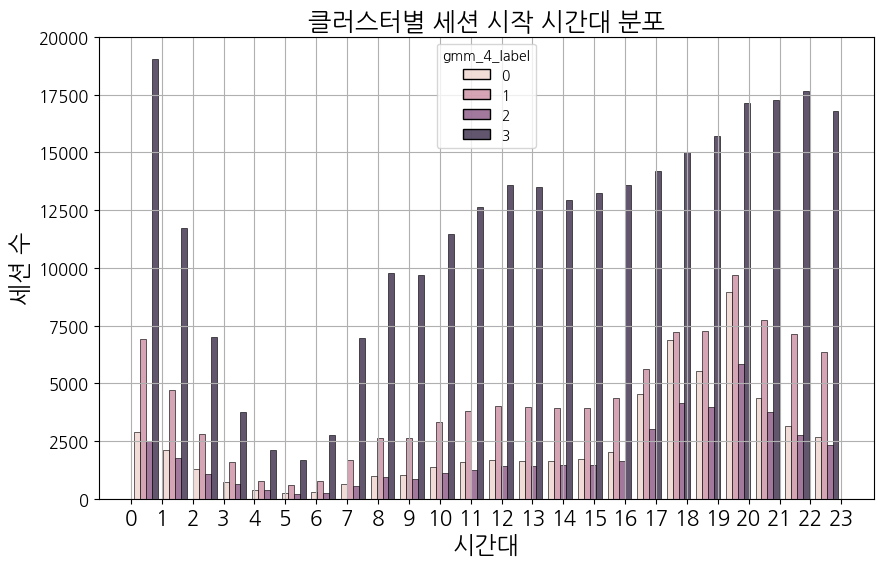

In [36]:
# 클러스터별 session_start_time 분포 
plt.figure(figsize=(10, 6))
sns.histplot(data=session_cluster_df, x='start_hour', hue='gmm_4_label', bins=24, multiple='dodge', shrink=0.8)
plt.title('클러스터별 세션 시작 시간대 분포', fontsize = 18)
plt.xlabel('시간대', fontsize = 17)
plt.ylabel('세션 수', fontsize = 17)
plt.xticks(range(0, 24), fontsize = 15)
plt.yticks(fontsize = 12)
plt.grid(True)
plt.show()

In [16]:
# 1. 세션별 활동 시간 리스트 생성 함수
def expand_hours(row):
    start = row['start_time']
    end = row['end_time']

    # 당일 넘는 경우 방지
    if end < start:
        end += pd.Timedelta(days=1)

    return list(range(start.hour, end.hour + 1))

# 2. 각 세션별 활동 시간대 추출
session_cluster_df['active_hours'] = session_cluster_df.apply(expand_hours, axis=1)

# 3. 활동 시간대 단위로 explode (long format)
exploded_df = session_cluster_df.explode('active_hours')

In [32]:
# 4. 클러스터별 시간대별 빈도표 생성
hourly_cluster_table = pd.crosstab(exploded_df['active_hours'], exploded_df['gmm_4_label'])

# 5. 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(hourly_cluster_table)

print(f"\n📌 [카이제곱 검정 결과]")
print(f"Chi2 통계량: {chi2:.2f}")
print(f"p-value: {p}")
print("p-value (지수 표기):", format(p, ".10e")) # p < 5e-324(파이썬에서 가능한 가장 작은 양의 실수) 수준
if p < 0.05:
    print("→ 유의수준 0.05 하에 귀무가설 기각: 클러스터별 활동 시간대에 통계적으로 유의한 차이가 있음!")
else:
    print("→ 유의수준 0.05 하에 귀무가설 채택: 활동 시간대 분포 차이가 유의하지 않음.")


📌 [카이제곱 검정 결과]
Chi2 통계량: 20428.61
p-value: 0.0
p-value (지수 표기): 0.0000000000e+00
→ 유의수준 0.05 하에 귀무가설 기각: 클러스터별 활동 시간대에 통계적으로 유의한 차이가 있음!


In [ ]:
hourly_cluster_table

gmm_4_label,0,1,2,3
active_hours,,,,
0,2896,6933,2478,19053
1,2192,5136,1869,13094
2,1369,3144,1146,7897
3,784,1841,685,4359
4,414,963,409,2441
5,282,723,221,1923
6,308,879,276,3006
7,660,1858,585,7394
8,1034,2859,989,10727


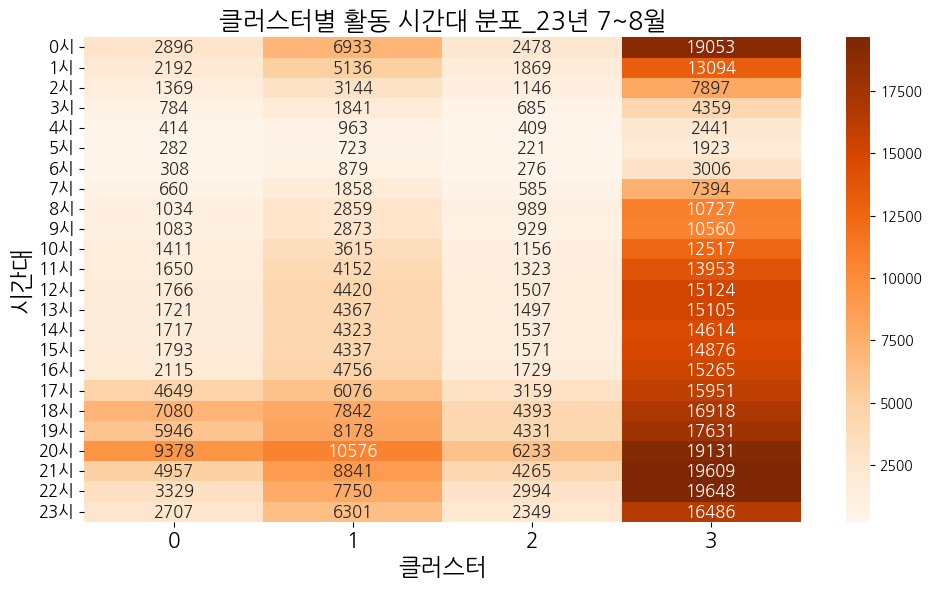

In [26]:
# 6. 시각화: heatmap으로 활동 시간 분포 보기
plt.figure(figsize=(10, 6))
sns.heatmap(hourly_cluster_table, cmap='Oranges', annot=True, annot_kws = {'size': 12}, fmt='d', )
plt.title("클러스터별 활동 시간대 분포_23년 7~8월", fontsize = 18)
plt.xlabel("클러스터", fontsize = 17)
plt.ylabel("시간대", fontsize = 17)
plt.yticks(np.arange(0.5, 24.5), labels=[f"{i}시" for i in range(24)], rotation=0, fontsize = 12)
plt.xticks(rotation=0, fontsize = 15)
plt.tight_layout()
plt.show()

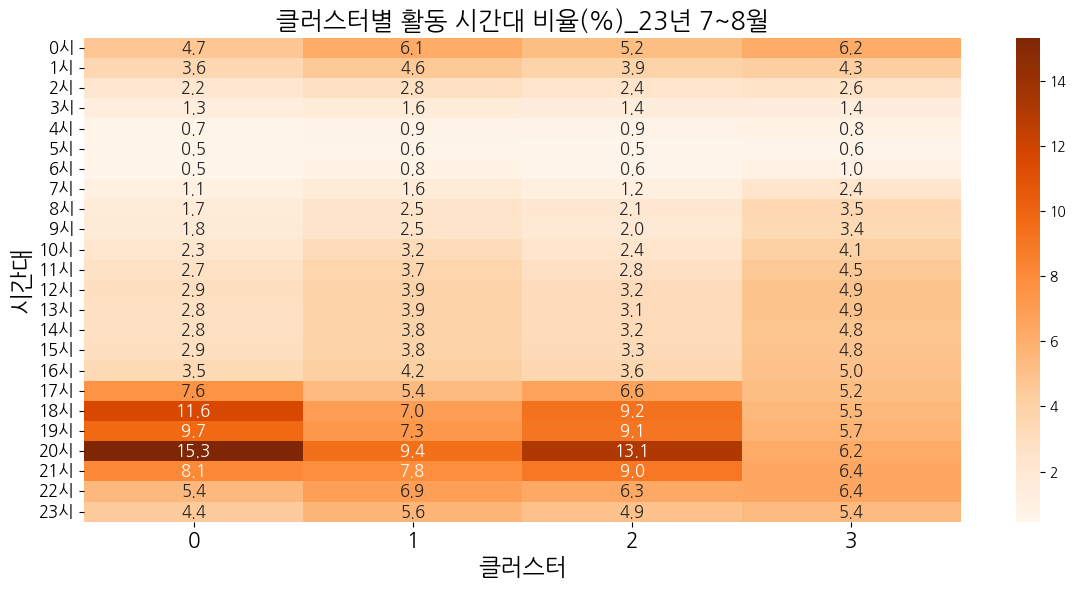

In [20]:
# 비율 계산: 각 클러스터 내에서의 시간대 분포 (column-wise)
hourly_cluster_ratio = hourly_cluster_table.div(hourly_cluster_table.sum(axis=0), axis=1) * 100

# # 색상 맵 설정
# custom_cmap = sns.light_palette("#14213D", as_cmap=True)

# 시각화
plt.figure(figsize=(12, 6))
sns.heatmap(hourly_cluster_ratio, cmap='Oranges', annot=True, fmt=".1f", annot_kws={'size': 12})
plt.title("클러스터별 활동 시간대 비율(%)_23년 7~8월", fontsize=18)
plt.xlabel("클러스터", fontsize=17)
plt.ylabel("시간대", fontsize=17)
plt.yticks(np.arange(0.5, 24.5), labels=[f"{i}시" for i in range(24)], rotation=0, fontsize=12)
plt.xticks(rotation=0, fontsize=15)
plt.tight_layout()
plt.show()

# 성공기 -> 이탈기 군집별 비율 변화 시각화

In [6]:
import plotly.graph_objects as go

# 1. 노드 (군집 이름 리스트)
labels = [
    "성공기_충성(24.2%)",  # 0
    "성공기_지속적활동(38.5%)",  # 1
    "성공기_가벼운반복(11.8%)",  # 2
    "성공기_이탈(25.5%)",  # 3
    "이탈기_충성(10.0%)",  # 4
    "이탈기_지속적활동(21%)",  # 5
    "이탈기_가벼운반복(19.1%)",  # 6
    "이탈기_이탈(49.9%)"   # 7
]

# 2. 흐름 정의 (임의로 구성한 예시: 전환율 기반이 아닌 단순 비율 흐름)
# 출발 노드 (source) → 도착 노드 (target) → 비율 값 (value)
# 예: 성공기_충성 → 이탈기_충성 10%, → 이탈기_단발 8%, → 이탈기_이탈 6.2%
source = [0, 0, 1, 1, 2, 2, 3, 3]  # 성공기 클러스터 index
target = [4, 5, 5, 7, 6, 7, 6, 7]  # 이탈기 클러스터 index
values = [10, 14.2, 21, 17.5, 10, 1.8, 9.1, 16.4]  # 임의 흐름 수치 (총합 100)

# 3. 색상 선택 (선택사항)
colors = [
    "royalblue", "lightblue", "orange", "tomato",  # 성공기
    "darkblue", "mediumseagreen", "orange", "firebrick"  # 이탈기
]

# 4. Sankey 그래프 생성
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=colors
    ),
    link=dict(
        source=source,
        target=target,
        value=values
    )
)])

# 5. 출력 (Jupyter 환경에서는 fig.show())
fig.update_layout(title_text="성공기 → 이탈기 군집 변화 Sankey 다이어그램", font_size=12)
fig.show()

# Optional: PNG 파일로 저장 (설치 필요: kaleido)
# fig.write_image("sankey_diagram.png", width=1200, height=600)


- 개별 유저의 흐름을 추적할 수는 없어서 (user_id / device_id 문제!) Sankey는 오히려 오해를 불러일으키기 좋을 듯! 
- 제외

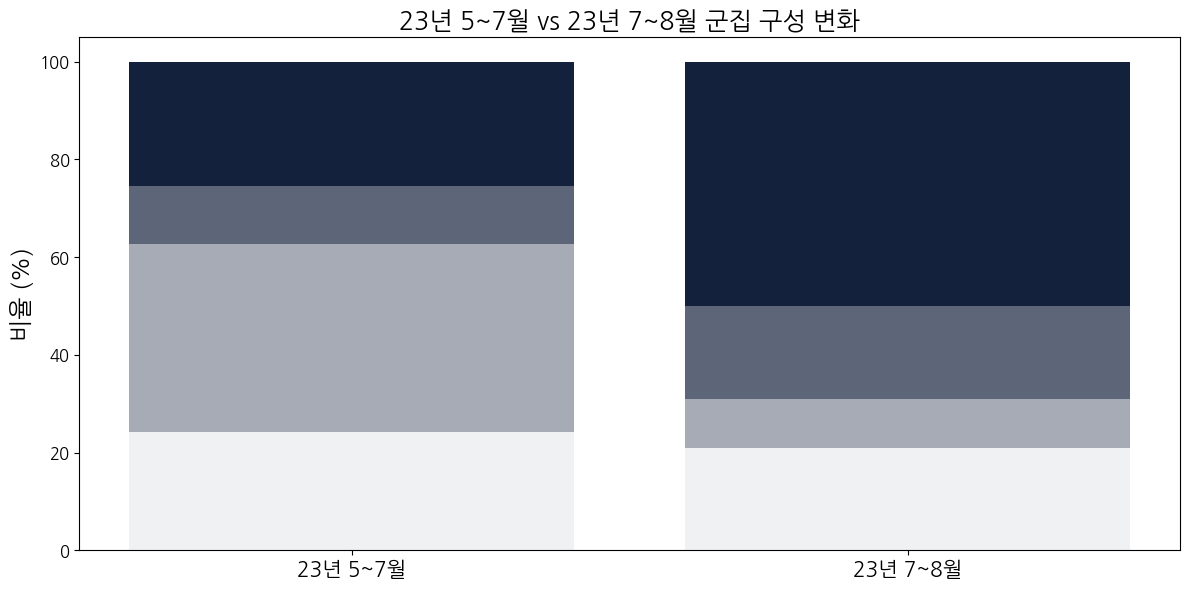

In [27]:
# 백분율 스택 bar 차트 
clusters = ['충성', '지속적 활동', '가벼운 반복', '이탈']
success = [24.2, 38.5, 11.8, 25.5]
decline = [21.0, 10.0, 19.1, 49.9]

labels = ['23년 5~7월', '23년 7~8월']
data = [success, decline]
data = np.array(data)

#colors = ['#14213d', '#fca311', '#14213d', '#fca311']

# ✅ #14213D 기반으로 어두운 계열 색상 4개 추출
colors = sns.light_palette("#14213d", n_colors=len(clusters), reverse=False)

# 시각화
plt.figure(figsize=(12,6))

bottom = np.zeros(2)
for i in range(len(clusters)):
    plt.bar(labels, data[:, i], bottom=bottom, label=clusters[i],color=colors[i])
    bottom += data[:, i]

plt.title('23년 5~7월 vs 23년 7~8월 군집 구성 변화', fontsize = 18)
plt.ylabel('비율 (%)', fontsize = 17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 12)
#plt.legend()
plt.tight_layout()
plt.show()


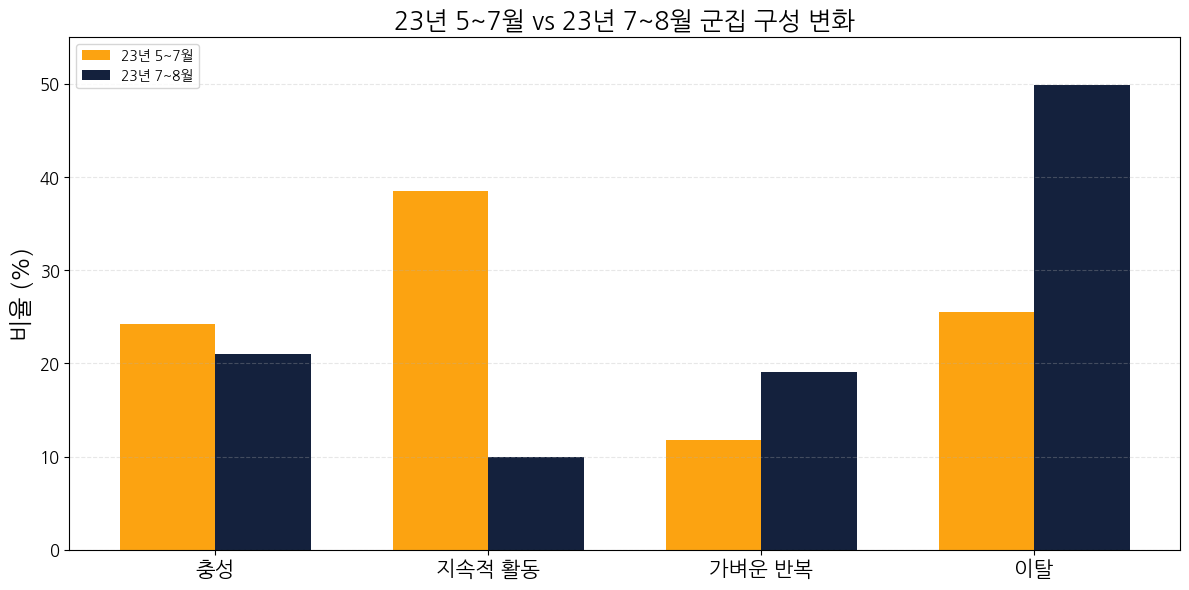

In [6]:
# 막대 그래프 
# 군집 이름
clusters = ['충성', '지속적 활동', '가벼운 반복', '이탈']

# 성공기 (matched_device_df)
success_rates = [24.2, 38.5, 11.8, 25.5]

# 쇠퇴기 (matched_session_df)
decline_rates = [21.0, 10.0, 19.1, 49.9]

x = np.arange(len(clusters))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, success_rates, width, label='23년 5~7월', color = '#fca311')
plt.bar(x + width/2, decline_rates, width, label='23년 7~8월', color = '#14213d')

plt.title('23년 5~7월 vs 23년 7~8월 군집 구성 변화', fontsize = 18)
plt.ylabel('비율 (%)', fontsize = 17)
plt.xticks(x, clusters, fontsize = 15)
plt.yticks(fontsize = 12)
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.ylim(0,55)
plt.tight_layout()
plt.show()



**7~8월**     
	count    
0	58292 (이탈 사용자)    
1	24517 (충성 사용자)    
2	22340 (가벼운 반복 사용자)    
3	11663 (지속적 활동자)    
**5~7월**    
	count    
0	274436 (지속적 활동자)    
1	181654 (이탈 사용자)    
3	172029 (충성사용자)    
2	83807 (가벼운 반복 사용자)    

In [ ]:
# 이 비율간에 진짜 유의미한 차이가 있는 건지 p값 뽑아보기

# 데이터
# contingency = np.array([
#     [172029, 274436, 83807,181654 ],  # 성공기, 충성 - 지속적 - 가벼운 - 이탈 순서
#     [10245170, 11663, 22340,58292 ]   # 쇠퇴기
# ])

# 데이터
contingency = np.array([
    [274436, 181654 ],  # 성공기, 지속적 - 이탈 순서
    [11663, 58292 ]   # 쇠퇴기
])

chi2, p, dof, expected = chi2_contingency(contingency, correction = False)
print("p-value:", p)
print("p-value (지수 표기):", format(p, ".10e")) # p < 5e-324(파이썬에서 가능한 가장 작은 양의 실수) 수준


p-value: 0.0
p-value (지수 표기): 0.0000000000e+00


# 주중 vs 주말로 비교해보기
- 주중 vs 주말로 나눠서 성공기 -> 쇠퇴기 아침 -> 저녁 시간대 변화가 학사일정에 영향 받은건지 확인
- session_start로만 우선 확인

In [58]:
session_cluster_df.head()

,user_id,start_time,end_time,session_duration_sec,session_flag,avg_duration_sec,session_count,gmm_4_label,start_hour,active_hours
0,02QVyNBCraNN7i04MPRQVrGbGPR2,2023-07-21 08:59:54,2023-07-21 08:59:58,4.0,matched,4.0,1,0,8,[8]
1,03dEZCajSgbBSj7wPNeXjBp8QnI2,2023-07-18 07:22:11,2023-07-18 07:22:12,1.0,matched,2.2,5,1,7,[7]
2,03dEZCajSgbBSj7wPNeXjBp8QnI2,2023-07-25 17:01:31,2023-07-25 17:01:32,1.0,matched,2.2,5,1,17,[17]
3,03dEZCajSgbBSj7wPNeXjBp8QnI2,2023-07-25 21:15:39,2023-07-25 21:15:46,7.0,matched,2.2,5,1,21,[21]
4,03dEZCajSgbBSj7wPNeXjBp8QnI2,2023-07-27 14:56:15,2023-07-27 14:56:16,1.0,matched,2.2,5,1,14,[14]


In [22]:
session_cluster_df = session_cluster_df.copy()

# datetime에서 시간, 요일 추출
session_cluster_df['start_hour'] = session_cluster_df['start_time'].dt.hour
session_cluster_df['start_dayofweek'] = session_cluster_df['start_time'].dt.dayofweek

# 주중/주말 구분 (0~4: 주중(weekdays), 5~6: 주말(weekend))
session_cluster_df['is_weekend'] = session_cluster_df['start_dayofweek'].apply(lambda x: 'weekend' if x >= 5 else 'weekdays')

session_cluster_df.head()

,user_id,start_time,end_time,session_duration_sec,session_flag,avg_duration_sec,session_count,gmm_4_label,start_hour,active_hours,start_dayofweek,is_weekend
0,02QVyNBCraNN7i04MPRQVrGbGPR2,2023-07-21 08:59:54,2023-07-21 08:59:58,4.0,matched,4.0,1,0,8,[8],4,weekdays
1,03dEZCajSgbBSj7wPNeXjBp8QnI2,2023-07-18 07:22:11,2023-07-18 07:22:12,1.0,matched,2.2,5,1,7,[7],1,weekdays
2,03dEZCajSgbBSj7wPNeXjBp8QnI2,2023-07-25 17:01:31,2023-07-25 17:01:32,1.0,matched,2.2,5,1,17,[17],1,weekdays
3,03dEZCajSgbBSj7wPNeXjBp8QnI2,2023-07-25 21:15:39,2023-07-25 21:15:46,7.0,matched,2.2,5,1,21,[21],1,weekdays
4,03dEZCajSgbBSj7wPNeXjBp8QnI2,2023-07-27 14:56:15,2023-07-27 14:56:16,1.0,matched,2.2,5,1,14,[14],3,weekdays


In [23]:
# 그룹별 시간대별 활동 수 집계
hourly_activity = (
    session_cluster_df.groupby(['start_hour', 'is_weekend'])
    .size()
    .reset_index(name='count')
)

# 히트맵용 피벗
hourly_week_table  = hourly_activity.pivot(index='start_hour', columns='is_weekend', values='count')
display(hourly_week_table)

# 전체 대비 시간대 비율 정규화 (열 기준 = 주중/주말 별 비율)
hourly_week_ratio = hourly_week_table.div(hourly_week_table.sum(axis=0), axis=1) * 100
hourly_week_ratio

is_weekend,weekdays,weekend
start_hour,,
0,23093,8267
1,14620,5690
2,8696,3482
3,4752,1994
4,2580,1044
5,1929,766
6,3205,833
7,8356,1490
8,11783,2551


is_weekend,weekdays,weekend
start_hour,,
0,6.448289,6.483566
1,4.082362,4.462500
2,2.428196,2.730830
3,1.326907,1.563836
4,0.720417,0.818779
5,0.538637,0.600751
6,0.894936,0.653297
7,2.333257,1.168563
8,3.290183,2.000674


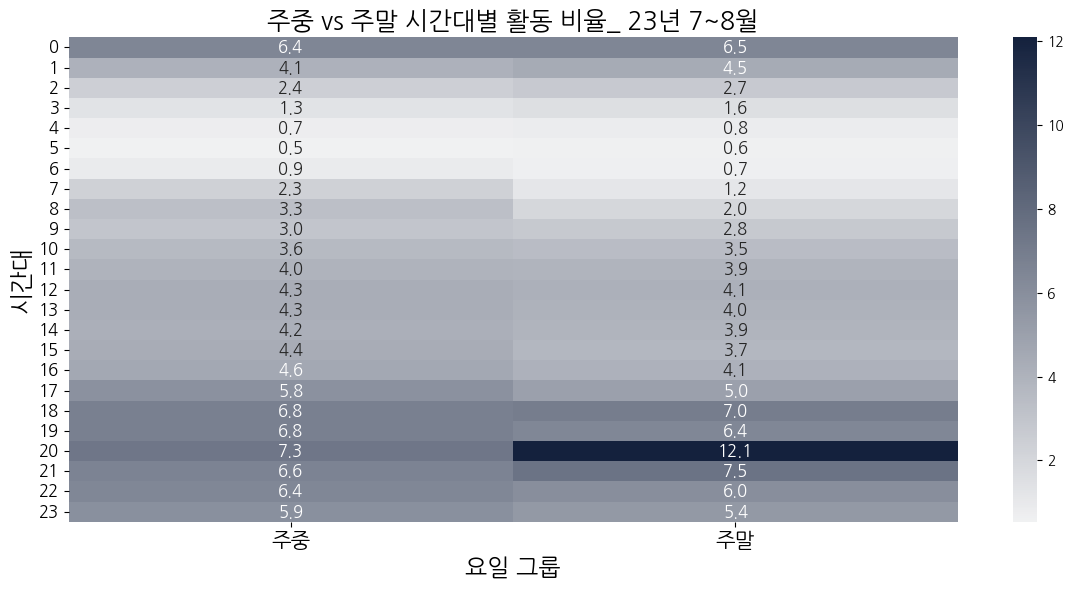

In [24]:
# 단일 색상 계열로 커스텀 컬러맵 만들기
custom_cmap = sns.light_palette("#14213D", as_cmap=True)

# 시각화
plt.figure(figsize=(12, 6))
sns.heatmap(hourly_week_ratio, cmap=custom_cmap, annot=True, fmt=".1f", annot_kws={'size': 12})
plt.title("주중 vs 주말 시간대별 활동 비율_ 23년 7~8월", fontsize = 18)
plt.xlabel("요일 그룹", fontsize=17)
plt.ylabel("시간대", fontsize=17)
plt.xticks([0.5,1.5], ['주중', '주말'],fontsize = 15)
plt.yticks(rotation=0, fontsize = 12)
plt.tight_layout()
plt.show()
